## Completed

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 8.1 MB/s eta 0:00:00


In [2]:
import optuna

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# System and warning configuration
import sys
import os
import warnings
warnings.filterwarnings("ignore")

# For downloading the file
import gdown

# === Step 1: Google Sheets Direct Download ===
# Your Google Sheets link (shared view):
# https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/edit?usp=sharing

# Convert to a direct download link (Excel format)
download_url = "https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx"

# Output filename
output_file = "downloaded_file.xlsx"

# Download the file
gdown.download(download_url, output=output_file, quiet=False)

# === Step 2: Read Excel File ===
data = pd.read_excel(output_file)

# Display the first few rows
print(data.head())

# Copy data
df = data.copy()

# Display column names
print(df.columns)

# Create a new 'Date' column by combining 'Year', 'Month', and 'Day'
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Drop the 'Year', 'Month', and 'Day' columns
df.drop(columns=['Year', 'Month', 'Day'], inplace=True)

#


Downloading...
From: https://docs.google.com/spreadsheets/d/1tjx2ifyUsAAB-yxxuvTIjXNmkomA9OzW/export?format=xlsx
To: /content/downloaded_file.xlsx
16.9kB [00:00, 16.2MB/s]


   Year  Month  Day  Inflation
0  2000      1   31   0.329139
1  2000      2   28   1.940367
2  2000      3   31   4.469678
3  2000      4   30   3.672022
4  2000      5   31   2.382412
Index(['Year', 'Month', 'Day', 'Inflation'], dtype='object')


In [9]:
df

Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]

# ALL

## 1

In [10]:

df=data.copy()
df = df.astype(float)


In [11]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [12]:
# Number of lags to create
lags = 1
lagged_features = create_lagged_features(df, lags)


In [13]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [14]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Month_lag_1  Day_lag_1  \
0    2000.0    1.0  31.0   0.329139         NaN          NaN        NaN   
1    2000.0    2.0  28.0   1.940367      2000.0          1.0       31.0   
2    2000.0    3.0  31.0   4.469678      2000.0          2.0       28.0   
3    2000.0    4.0  30.0   3.672022      2000.0          3.0       31.0   
4    2000.0    5.0  31.0   2.382412      2000.0          4.0       30.0   
..      ...    ...   ...        ...         ...          ...        ...   
298  2024.0   11.0  30.0  -2.068252      2024.0         10.0       31.0   
299  2024.0   12.0  31.0  -1.742696      2024.0         11.0       30.0   
300  2025.0    1.0  31.0  -4.035874      2024.0         12.0       31.0   
301  2025.0    2.0  28.0  -4.187438      2025.0          1.0       31.0   
302  2025.0    3.0  31.0  -2.592781      2025.0          2.0       28.0   

     Inflation_lag_1  
0                NaN  
1           0.329139

In [15]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Month_lag_1',
       'Day_lag_1', 'Inflation_lag_1'],
      dtype='object')


In [17]:
df2=lagged_features.dropna()

In [18]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Month_lag_1  Day_lag_1  \
1    2000.0    2.0  28.0   1.940367      2000.0          1.0       31.0   
2    2000.0    3.0  31.0   4.469678      2000.0          2.0       28.0   
3    2000.0    4.0  30.0   3.672022      2000.0          3.0       31.0   
4    2000.0    5.0  31.0   2.382412      2000.0          4.0       30.0   
5    2000.0    6.0  30.0   6.799835      2000.0          5.0       31.0   
..      ...    ...   ...        ...         ...          ...        ...   
298  2024.0   11.0  30.0  -2.068252      2024.0         10.0       31.0   
299  2024.0   12.0  31.0  -1.742696      2024.0         11.0       30.0   
300  2025.0    1.0  31.0  -4.035874      2024.0         12.0       31.0   
301  2025.0    2.0  28.0  -4.187438      2025.0          1.0       31.0   
302  2025.0    3.0  31.0  -2.592781      2025.0          2.0       28.0   

     Inflation_lag_1  
1           0.329139  
2           1.940367  
3           4.469678  
4      

302

In [19]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Month_lag_1        0
Day_lag_1          0
Inflation_lag_1    0
dtype: int64

In [20]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
df2

Year  Month   Day  Inflation  Year_lag_1  Month_lag_1  Day_lag_1  \
1    2000.0    2.0  28.0   1.940367      2000.0          1.0       31.0   
2    2000.0    3.0  31.0   4.469678      2000.0          2.0       28.0   
3    2000.0    4.0  30.0   3.672022      2000.0          3.0       31.0   
4    2000.0    5.0  31.0   2.382412      2000.0          4.0       30.0   
5    2000.0    6.0  30.0   6.799835      2000.0          5.0       31.0   
..      ...    ...   ...        ...         ...          ...        ...   
298  2024.0   11.0  30.0  -2.068252      2024.0         10.0       31.0   
299  2024.0   12.0  31.0  -1.742696      2024.0         11.0       30.0   
300  2025.0    1.0  31.0  -4.035874      2024.0         12.0       31.0   
301  2025.0    2.0  28.0  -4.187438      2025.0          1.0       31.0   
302  2025.0    3.0  31.0  -2.592781      2025.0          2.0       28.0   

     Inflation_lag_1  
1           0.329139  
2           1.940367  
3           4.469678  
4           3.672022  
5           2.382412  
..               ...  
298        -0.783699  
299        -2.068252  
300        -1.742696  
301        -4.035874  
302        -4.187438  

[302 rows x 8 columns]

In [22]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [23]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Month_lag_1  Day_lag_1  \
1    2000.0    2.0  28.0   1.940367      2000.0          1.0       31.0   
2    2000.0    3.0  31.0   4.469678      2000.0          2.0       28.0   
3    2000.0    4.0  30.0   3.672022      2000.0          3.0       31.0   
4    2000.0    5.0  31.0   2.382412      2000.0          4.0       30.0   
5    2000.0    6.0  30.0   6.799835      2000.0          5.0       31.0   
..      ...    ...   ...        ...         ...          ...        ...   
237  2019.0   10.0  31.0   5.377207      2019.0          9.0       30.0   
238  2019.0   11.0  30.0   4.358162      2019.0         10.0       31.0   
239  2019.0   12.0  31.0   4.829770      2019.0         11.0       30.0   
240  2020.0    1.0  31.0   5.651491      2019.0         12.0       31.0   
241  2020.0    2.0  28.0   6.151420      2020.0          1.0       31.0   

     Inflation_lag_1  
1           0.329139  
2           1.940367  
3           4.469678  
4           3.672022  
5           2.382412  
..               ...  
237         4.963971  
238         5.377207  
239         4.358162  
240         4.829770  
241         5.651491  

[241 rows x 8 columns]

In [24]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [25]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Month_lag_1  Day_lag_1  \
1    2000.0    2.0  28.0   1.940367      2000.0          1.0       31.0   
2    2000.0    3.0  31.0   4.469678      2000.0          2.0       28.0   
3    2000.0    4.0  30.0   3.672022      2000.0          3.0       31.0   
4    2000.0    5.0  31.0   2.382412      2000.0          4.0       30.0   
5    2000.0    6.0  30.0   6.799835      2000.0          5.0       31.0   
..      ...    ...   ...        ...         ...          ...        ...   
237  2019.0   10.0  31.0   5.377207      2019.0          9.0       30.0   
238  2019.0   11.0  30.0   4.358162      2019.0         10.0       31.0   
239  2019.0   12.0  31.0   4.829770      2019.0         11.0       30.0   
240  2020.0    1.0  31.0   5.651491      2019.0         12.0       31.0   
241  2020.0    2.0  28.0   6.151420      2020.0          1.0       31.0   

     Inflation_lag_1  
1           0.329139  
2           1.940367  
3           4.469678  
4           3.672022  
5           2.382412  
..               ...  
237         4.963971  
238         5.377207  
239         4.358162  
240         4.829770  
241         5.651491  

[241 rows x 8 columns]

In [26]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

242    5.371248
243    5.196850
244    4.031008
245    3.917051
246    4.153846
         ...   
298   -2.068252
299   -1.742696
300   -4.035874
301   -4.187438
302   -2.592781
Name: Inflation, Length: 61, dtype: float64

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Month_lag_1', 'Day_lag_1',
       'Inflation_lag_1'],
      dtype='object')

In [29]:
ytrain

1      1.940367
2      4.469678
3      3.672022
4      2.382412
5      6.799835
         ...   
237    5.377207
238    4.358162
239    4.829770
240    5.651491
241    6.151420
Name: Inflation, Length: 241, dtype: float64

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [31]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [32]:
xtrain

Year  Month   Day  Year_lag_1  Month_lag_1  Day_lag_1  Inflation_lag_1
1    2000.0    2.0  28.0      2000.0          1.0       31.0         0.329139
2    2000.0    3.0  31.0      2000.0          2.0       28.0         1.940367
3    2000.0    4.0  30.0      2000.0          3.0       31.0         4.469678
4    2000.0    5.0  31.0      2000.0          4.0       30.0         3.672022
5    2000.0    6.0  30.0      2000.0          5.0       31.0         2.382412
..      ...    ...   ...         ...          ...        ...              ...
237  2019.0   10.0  31.0      2019.0          9.0       30.0         4.963971
238  2019.0   11.0  30.0      2019.0         10.0       31.0         5.377207
239  2019.0   12.0  31.0      2019.0         11.0       30.0         4.358162
240  2020.0    1.0  31.0      2019.0         12.0       31.0         4.829770
241  2020.0    2.0  28.0      2020.0          1.0       31.0         5.651491

[241 rows x 7 columns]

In [33]:
df1=pd.DataFrame(ytrain)

In [34]:
X_train_scaled

array([[0.        , 0.09090909, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.18181818, 1.        , ..., 0.09090909, 0.        ,
        0.05779654],
       [0.        , 0.27272727, 0.66666667, ..., 0.18181818, 1.        ,
        0.14852572],
       ...,
       [0.95      , 1.        , 1.        , ..., 0.90909091, 0.66666667,
        0.14452552],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.16144265],
       [1.        , 0.09090909, 0.        , ..., 0.        , 1.        ,
        0.19091869]])

In [35]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [36]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Month_lag_1  Day_lag_1  \
1    0.00  0.090909  0.000000        0.00     0.000000   1.000000   
2    0.00  0.181818  1.000000        0.00     0.090909   0.000000   
3    0.00  0.272727  0.666667        0.00     0.181818   1.000000   
4    0.00  0.363636  1.000000        0.00     0.272727   0.666667   
5    0.00  0.454545  0.666667        0.00     0.363636   1.000000   
..    ...       ...       ...         ...          ...        ...   
237  0.95  0.818182  1.000000        0.95     0.727273   0.666667   
238  0.95  0.909091  0.666667        0.95     0.818182   1.000000   
239  0.95  1.000000  1.000000        0.95     0.909091   0.666667   
240  1.00  0.000000  1.000000        0.95     1.000000   1.000000   
241  1.00  0.090909  0.000000        1.00     0.000000   1.000000   

     Inflation_lag_1  
1           0.000000  
2           0.057797  
3           0.148526  
4           0.119913  
5           0.073653  
..               ...  
237         0.166257  
238         0.181080  
239         0.144526  
240         0.161443  
241         0.190919  

[241 rows x 7 columns]

In [37]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [38]:
df3

Inflation  Year     Month       Day  Year_lag_1  Month_lag_1  Day_lag_1  \
1     1.940367  0.00  0.090909  0.000000        0.00     0.000000   1.000000   
2     4.469678  0.00  0.181818  1.000000        0.00     0.090909   0.000000   
3     3.672022  0.00  0.272727  0.666667        0.00     0.181818   1.000000   
4     2.382412  0.00  0.363636  1.000000        0.00     0.272727   0.666667   
5     6.799835  0.00  0.454545  0.666667        0.00     0.363636   1.000000   
..         ...   ...       ...       ...         ...          ...        ...   
237   5.377207  0.95  0.818182  1.000000        0.95     0.727273   0.666667   
238   4.358162  0.95  0.909091  0.666667        0.95     0.818182   1.000000   
239   4.829770  0.95  1.000000  1.000000        0.95     0.909091   0.666667   
240   5.651491  1.00  0.000000  1.000000        0.95     1.000000   1.000000   
241   6.151420  1.00  0.090909  0.000000        1.00     0.000000   1.000000   

     Inflation_lag_1  
1           0.000000  
2           0.057797  
3           0.148526  
4           0.119913  
5           0.073653  
..               ...  
237         0.166257  
238         0.181080  
239         0.144526  
240         0.161443  
241         0.190919  

[241 rows x 8 columns]

In [39]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Month_lag_1  Day_lag_1  \
1    0.00  0.090909  0.000000        0.00     0.000000   1.000000   
2    0.00  0.181818  1.000000        0.00     0.090909   0.000000   
3    0.00  0.272727  0.666667        0.00     0.181818   1.000000   
4    0.00  0.363636  1.000000        0.00     0.272727   0.666667   
5    0.00  0.454545  0.666667        0.00     0.363636   1.000000   
..    ...       ...       ...         ...          ...        ...   
237  0.95  0.818182  1.000000        0.95     0.727273   0.666667   
238  0.95  0.909091  0.666667        0.95     0.818182   1.000000   
239  0.95  1.000000  1.000000        0.95     0.909091   0.666667   
240  1.00  0.000000  1.000000        0.95     1.000000   1.000000   
241  1.00  0.090909  0.000000        1.00     0.000000   1.000000   

     Inflation_lag_1  
1           0.000000  
2           0.057797  
3           0.148526  
4           0.119913  
5           0.073653  
..               ...  
237         0.166257  
238         0.181080  
239         0.144526  
240         0.161443  
241         0.190919  

[241 rows x 7 columns]

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 03:29:22,500] A new study created in memory with name: no-name-e257ec58-0cbc-4396-8281-bdb12d663b0e
[I 2025-05-29 03:29:46,577] Trial 0 finished with value: 0.04059724528342486 and parameters: {'input_units': 48, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 64, 'dropout_rate_0': 0.00018412356022518006, 'n_units_1': 48, 'dropout_rate_1': 0.21064152444804068, 'n_units_2': 80, 'dropout_rate_2': 0.23528321260232643, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 40}. Best is trial 0 with value: 0.04059724528342486.
[I 2025-05-29 03:30:34,544] Trial 1 finished with value: 0.0071896889712661505 and parameters: {'input_units': 16, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.3259696228470117, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 90}. Best is trial 1 with value: 0.0071896889712661505.
[I 2025-05-29 03:30:46,749] Trial 2 finished with value: 0.038459732010960576 and parameters: {'input_units': 48, 'activation': 'relu', '

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.1587785679615794, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 80}


Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.4911298147309582, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.1587785679615794, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 80}
Epoch 1/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0827 - mae: 0.2206 - val_loss: 0.0037 - val_mae: 0.0450
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0406 - mae: 0.1513 - val_loss: 0.0122 - val_mae: 0.0917
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0289 - mae: 0.1332 - val_loss: 0.0076 - val_mae: 0.0747
Epoch 4/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0147 - mae: 0.0969 - val_loss: 0.0169 - val_mae: 0.1166
Epoch 5/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0197 - mae: 0.1058 - val_loss: 0.0027 - val_mae: 0.0450
Epoch 6/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0099 - mae: 0.0796 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 7/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0089 - mae: 0.0768 - val_loss: 0.0025 - val_mae: 0.0416
Epoc

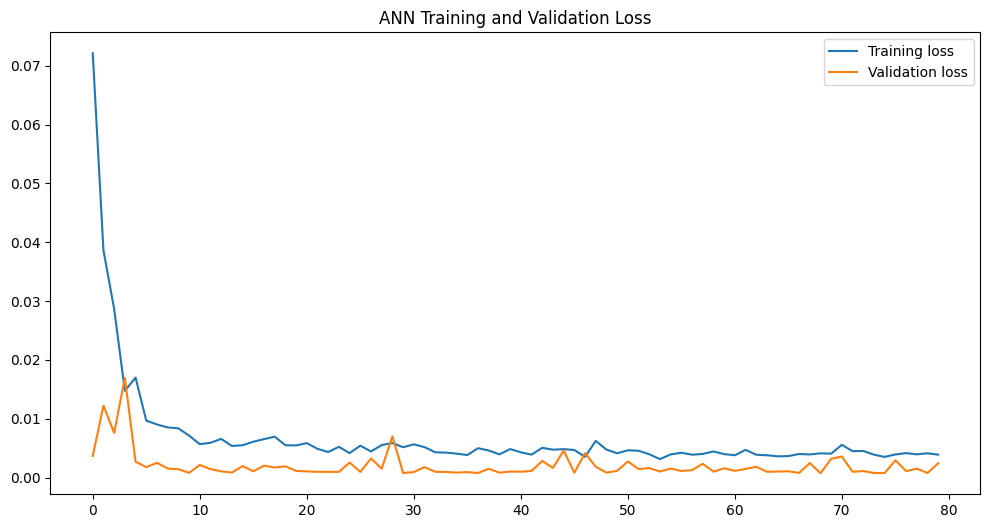

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [42]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [43]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 35.1709
RMSE: 5.9305
MAE: 3.8318
MAPE: 44.01%
R²: 0.9212


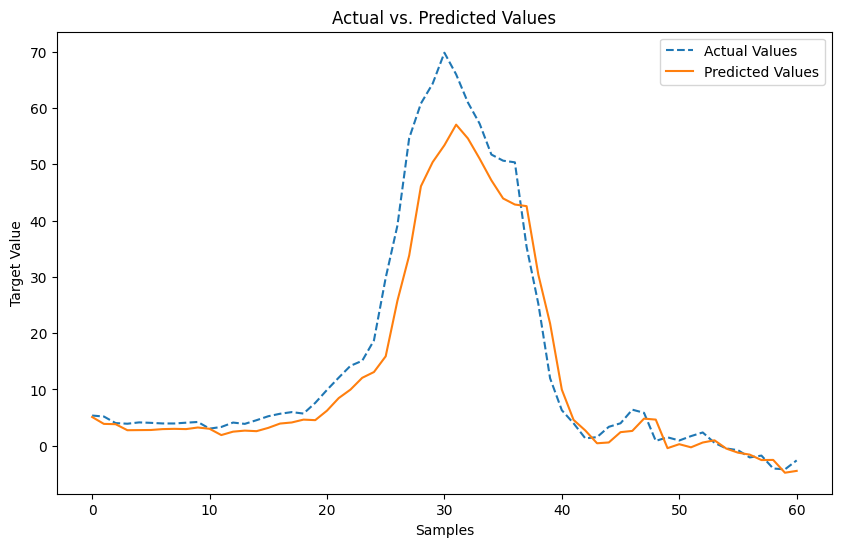

In [44]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 2

In [45]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [46]:

df=data.copy()
df = df.astype(float)


In [47]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [48]:
# Number of lags to create
lags = 2
lagged_features = create_lagged_features(df, lags)


In [49]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [50]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Month_lag_1  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN          NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN          1.0   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0          2.0   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0          4.0   
..      ...    ...   ...        ...         ...         ...          ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0         10.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0         11.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0         12.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0          1.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0          2.0   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_

In [51]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Month_lag_1', 'Month_lag_2', 'Day_lag_1', 'Day_lag_2',
       'Inflation_lag_1', 'Inflation_lag_2'],
      dtype='object')


In [52]:
df2=lagged_features.dropna()

In [53]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Month_lag_1  \
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0          2.0   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0          4.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0          5.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0          6.0   
..      ...    ...   ...        ...         ...         ...          ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0         10.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0         11.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0         12.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0          1.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0          2.0   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2           

301

In [54]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Month_lag_1        0
Month_lag_2        0
Day_lag_1          0
Day_lag_2          0
Inflation_lag_1    0
Inflation_lag_2    0
dtype: int64

In [55]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [56]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Month_lag_1  \
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0          2.0   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0          4.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0          5.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0          6.0   
..      ...    ...   ...        ...         ...         ...          ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0         10.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0         11.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0         12.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0          1.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0          2.0   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2            1.0       28.0       31.0         1.940367         0.329139  
3            2.0       31.0       28.0         4.469678         1.940367  
4            3.0       30.0       31.0         3.672022         4.469678  
5            4.0       31.0       30.0         2.382412         3.672022  
6            5.0       30.0       31.0         6.799835         2.382412  
..           ...        ...        ...              ...              ...  
298          9.0       31.0       30.0        -0.783699        -0.469239  
299         10.0       30.0       31.0        -2.068252        -0.783699  
300         11.0       31.0       30.0        -1.742696        -2.068252  
301         12.0       31.0       31.0        -4.035874        -1.742696  
302          1.0       28.0       31.0        -4.187438        -4.035874  

[301 rows x 12 columns]

In [57]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [58]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Month_lag_1  \
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0          2.0   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0          4.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0          5.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0          6.0   
..      ...    ...   ...        ...         ...         ...          ...   
237  2019.0   10.0  31.0   5.377207      2019.0      2019.0          9.0   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0         10.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0         11.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0         12.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0          1.0   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2            1.0       28.0       31.0         1.940367         0.329139  
3            2.0       31.0       28.0         4.469678         1.940367  
4            3.0       30.0       31.0         3.672022         4.469678  
5            4.0       31.0       30.0         2.382412         3.672022  
6            5.0       30.0       31.0         6.799835         2.382412  
..           ...        ...        ...              ...              ...  
237          8.0       30.0       31.0         4.963971         3.418124  
238          9.0       31.0       30.0         5.377207         4.963971  
239         10.0       30.0       31.0         4.358162         5.377207  
240         11.0       31.0       30.0         4.829770         4.358162  
241         12.0       31.0       31.0         5.651491         4.829770  

[240 rows x 12 columns]

In [59]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [60]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Month_lag_1  \
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0          2.0   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0          4.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0          5.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0          6.0   
..      ...    ...   ...        ...         ...         ...          ...   
237  2019.0   10.0  31.0   5.377207      2019.0      2019.0          9.0   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0         10.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0         11.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0         12.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0          1.0   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2            1.0       28.0       31.0         1.940367         0.329139  
3            2.0       31.0       28.0         4.469678         1.940367  
4            3.0       30.0       31.0         3.672022         4.469678  
5            4.0       31.0       30.0         2.382412         3.672022  
6            5.0       30.0       31.0         6.799835         2.382412  
..           ...        ...        ...              ...              ...  
237          8.0       30.0       31.0         4.963971         3.418124  
238          9.0       31.0       30.0         5.377207         4.963971  
239         10.0       30.0       31.0         4.358162         5.377207  
240         11.0       31.0       30.0         4.829770         4.358162  
241         12.0       31.0       31.0         5.651491         4.829770  

[240 rows x 12 columns]

In [61]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

242    5.371248
243    5.196850
244    4.031008
245    3.917051
246    4.153846
         ...   
298   -2.068252
299   -1.742696
300   -4.035874
301   -4.187438
302   -2.592781
Name: Inflation, Length: 61, dtype: float64

In [62]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Month_lag_1',
       'Month_lag_2', 'Day_lag_1', 'Day_lag_2', 'Inflation_lag_1',
       'Inflation_lag_2'],
      dtype='object')

In [64]:
ytrain

2       4.469678
3       3.672022
4       2.382412
5       6.799835
6      10.139831
         ...    
237     5.377207
238     4.358162
239     4.829770
240     5.651491
241     6.151420
Name: Inflation, Length: 240, dtype: float64

In [65]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [66]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [67]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Month_lag_1  Month_lag_2  \
2    2000.0    3.0  31.0      2000.0      2000.0          2.0          1.0   
3    2000.0    4.0  30.0      2000.0      2000.0          3.0          2.0   
4    2000.0    5.0  31.0      2000.0      2000.0          4.0          3.0   
5    2000.0    6.0  30.0      2000.0      2000.0          5.0          4.0   
6    2000.0    7.0  31.0      2000.0      2000.0          6.0          5.0   
..      ...    ...   ...         ...         ...          ...          ...   
237  2019.0   10.0  31.0      2019.0      2019.0          9.0          8.0   
238  2019.0   11.0  30.0      2019.0      2019.0         10.0          9.0   
239  2019.0   12.0  31.0      2019.0      2019.0         11.0         10.0   
240  2020.0    1.0  31.0      2019.0      2019.0         12.0         11.0   
241  2020.0    2.0  28.0      2020.0      2019.0          1.0         12.0   

     Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2         28.0       31.0         1.940367         0.329139  
3         31.0       28.0         4.469678         1.940367  
4         30.0       31.0         3.672022         4.469678  
5         31.0       30.0         2.382412         3.672022  
6         30.0       31.0         6.799835         2.382412  
..         ...        ...              ...              ...  
237       30.0       31.0         4.963971         3.418124  
238       31.0       30.0         5.377207         4.963971  
239       30.0       31.0         4.358162         5.377207  
240       31.0       30.0         4.829770         4.358162  
241       31.0       31.0         5.651491         4.829770  

[240 rows x 11 columns]

In [68]:
df1=pd.DataFrame(ytrain)

In [69]:
X_train_scaled

array([[0.        , 0.18181818, 1.        , ..., 1.        , 0.04334777,
        0.        ],
       [0.        , 0.27272727, 0.66666667, ..., 0.        , 0.13546829,
        0.05779654],
       [0.        , 0.36363636, 1.        , ..., 1.        , 0.1064167 ,
        0.14852572],
       ...,
       [0.95      , 1.        , 1.        , ..., 1.        , 0.13140674,
        0.18107981],
       [1.        , 0.        , 1.        , ..., 0.66666667, 0.1485833 ,
        0.14452552],
       [1.        , 0.09090909, 0.        , ..., 1.        , 0.17851136,
        0.16144265]])

In [70]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [71]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Month_lag_1  \
2    0.00  0.181818  1.000000        0.00         0.0     0.090909   
3    0.00  0.272727  0.666667        0.00         0.0     0.181818   
4    0.00  0.363636  1.000000        0.00         0.0     0.272727   
5    0.00  0.454545  0.666667        0.00         0.0     0.363636   
6    0.00  0.545455  1.000000        0.00         0.0     0.454545   
..    ...       ...       ...         ...         ...          ...   
237  0.95  0.818182  1.000000        0.95         1.0     0.727273   
238  0.95  0.909091  0.666667        0.95         1.0     0.818182   
239  0.95  1.000000  1.000000        0.95         1.0     0.909091   
240  1.00  0.000000  1.000000        0.95         1.0     1.000000   
241  1.00  0.090909  0.000000        1.00         1.0     0.000000   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2       0.000000   0.000000   1.000000         0.043348         0.000000  
3       0.090909   1.000000   0.000000         0.135468         0.057797  
4       0.181818   0.666667   1.000000         0.106417         0.148526  
5       0.272727   1.000000   0.666667         0.059448         0.119913  
6       0.363636   0.666667   1.000000         0.220335         0.073653  
..           ...        ...        ...              ...              ...  
237     0.636364   0.666667   1.000000         0.153471         0.110805  
238     0.727273   1.000000   0.666667         0.168522         0.166257  
239     0.818182   0.666667   1.000000         0.131407         0.181080  
240     0.909091   1.000000   0.666667         0.148583         0.144526  
241     1.000000   1.000000   1.000000         0.178511         0.161443  

[240 rows x 11 columns]

In [72]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [73]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Month_lag_1  \
2     4.469678  0.00  0.181818  1.000000        0.00         0.0     0.090909   
3     3.672022  0.00  0.272727  0.666667        0.00         0.0     0.181818   
4     2.382412  0.00  0.363636  1.000000        0.00         0.0     0.272727   
5     6.799835  0.00  0.454545  0.666667        0.00         0.0     0.363636   
6    10.139831  0.00  0.545455  1.000000        0.00         0.0     0.454545   
..         ...   ...       ...       ...         ...         ...          ...   
237   5.377207  0.95  0.818182  1.000000        0.95         1.0     0.727273   
238   4.358162  0.95  0.909091  0.666667        0.95         1.0     0.818182   
239   4.829770  0.95  1.000000  1.000000        0.95         1.0     0.909091   
240   5.651491  1.00  0.000000  1.000000        0.95         1.0     1.000000   
241   6.151420  1.00  0.090909  0.000000        1.00         1.0     0.000000   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2       0.000000   0.000000   1.000000         0.043348         0.000000  
3       0.090909   1.000000   0.000000         0.135468         0.057797  
4       0.181818   0.666667   1.000000         0.106417         0.148526  
5       0.272727   1.000000   0.666667         0.059448         0.119913  
6       0.363636   0.666667   1.000000         0.220335         0.073653  
..           ...        ...        ...              ...              ...  
237     0.636364   0.666667   1.000000         0.153471         0.110805  
238     0.727273   1.000000   0.666667         0.168522         0.166257  
239     0.818182   0.666667   1.000000         0.131407         0.181080  
240     0.909091   1.000000   0.666667         0.148583         0.144526  
241     1.000000   1.000000   1.000000         0.178511         0.161443  

[240 rows x 12 columns]

In [74]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Month_lag_1  \
2    0.00  0.181818  1.000000        0.00         0.0     0.090909   
3    0.00  0.272727  0.666667        0.00         0.0     0.181818   
4    0.00  0.363636  1.000000        0.00         0.0     0.272727   
5    0.00  0.454545  0.666667        0.00         0.0     0.363636   
6    0.00  0.545455  1.000000        0.00         0.0     0.454545   
..    ...       ...       ...         ...         ...          ...   
237  0.95  0.818182  1.000000        0.95         1.0     0.727273   
238  0.95  0.909091  0.666667        0.95         1.0     0.818182   
239  0.95  1.000000  1.000000        0.95         1.0     0.909091   
240  1.00  0.000000  1.000000        0.95         1.0     1.000000   
241  1.00  0.090909  0.000000        1.00         1.0     0.000000   

     Month_lag_2  Day_lag_1  Day_lag_2  Inflation_lag_1  Inflation_lag_2  
2       0.000000   0.000000   1.000000         0.043348         0.000000  
3       0.090909   1.000000   0.000000         0.135468         0.057797  
4       0.181818   0.666667   1.000000         0.106417         0.148526  
5       0.272727   1.000000   0.666667         0.059448         0.119913  
6       0.363636   0.666667   1.000000         0.220335         0.073653  
..           ...        ...        ...              ...              ...  
237     0.636364   0.666667   1.000000         0.153471         0.110805  
238     0.727273   1.000000   0.666667         0.168522         0.166257  
239     0.818182   0.666667   1.000000         0.131407         0.181080  
240     0.909091   1.000000   0.666667         0.148583         0.144526  
241     1.000000   1.000000   1.000000         0.178511         0.161443  

[240 rows x 11 columns]

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 03:59:32,751] A new study created in memory with name: no-name-76ef9fa5-6198-498b-b725-35f11f2097f7
[I 2025-05-29 04:00:15,193] Trial 0 finished with value: 0.0053812358528375626 and parameters: {'input_units': 112, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 48, 'dropout_rate_0': 0.09086364159691585, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 80}. Best is trial 0 with value: 0.0053812358528375626.
[I 2025-05-29 04:00:22,802] Trial 1 finished with value: 0.038863615691661836 and parameters: {'input_units': 112, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 112, 'dropout_rate_0': 0.12311254649525777, 'n_units_1': 80, 'dropout_rate_1': 0.4842227445415876, 'n_units_2': 112, 'dropout_rate_2': 0.499027049227447, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.0053812358528375626.
[I 2025-05-29 04:00:43,709] Trial 2 finished with value: 0.031916453037410975 and parameters: {'input_units': 96, 'activation': 'relu', 'n

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.03151951444470963, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 100}


Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.17002752103955923, 'n_units_1': 128, 'dropout_rate_1': 0.34985530992621416, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.03151951444470963, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 100}
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.1557 - mae: 0.3232 - val_loss: 0.0591 - val_mae: 0.2324
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0481 - mae: 0.1707 - val_loss: 0.0324 - val_mae: 0.1745
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0300 - mae: 0.1343 - val_loss: 0.0101 - val_mae: 0.0904
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0351 - mae: 0.1605 - val_loss: 0.0390 - val_mae: 0.1943
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0204 - mae: 0.1151 - val_loss: 0.0189 - val_mae: 0.1323
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0144 - mae: 0.1001 - val_loss: 0.0029 - val_mae: 0.0468
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0159 - mae: 0.0986 - val_loss: 0.0129 - val_mae: 

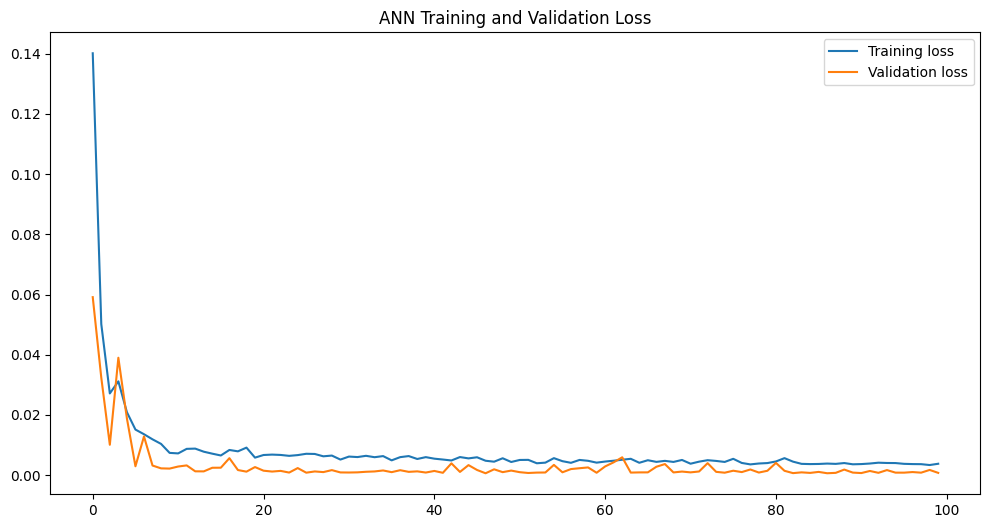

In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [77]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [78]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 30.9772
RMSE: 5.5657
MAE: 3.3260
MAPE: 46.43%
R²: 0.9306


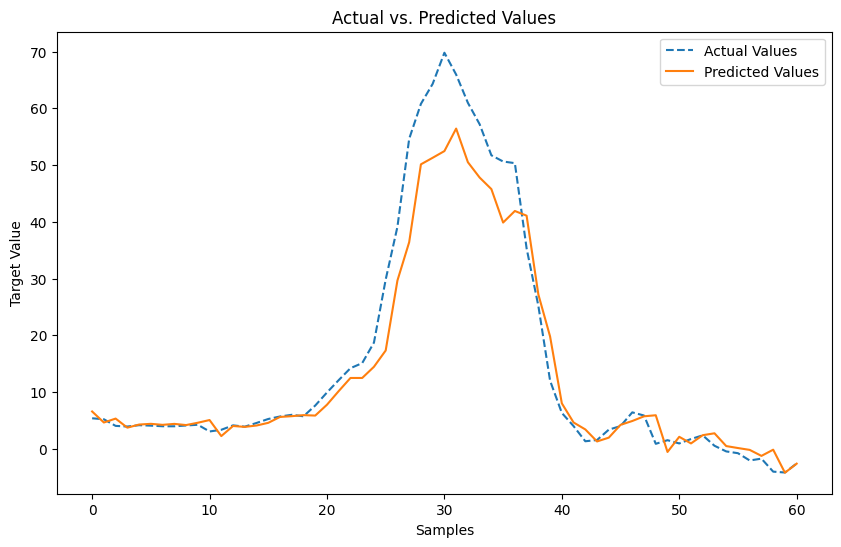

In [79]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 3

In [80]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [81]:

df=data.copy()
df = df.astype(float)


In [82]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [83]:
# Number of lags to create
lags = 3
lagged_features = create_lagged_features(df, lags)


In [84]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [85]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  

In [86]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3', 'Day_lag_1',
       'Day_lag_2', 'Day_lag_3', 'Inflation_lag_1', 'Inflation_lag_2',
       'Inflation_lag_3'],
      dtype='object')


In [87]:
df2=lagged_features.dropna()

In [88]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3            3.0    

300

In [89]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
dtype: int64

In [90]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [91]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3            3.0          2.0          1.0       31.0       28.0       31.0   
4            4.0          3.0          2.0       30.0       31.0       28.0   
5            5.0          4.0          3.0       31.0       30.0       31.0   
6            6.0          5.0          4.0       30.0       31.0       30.0   
7            7.0          6.0          5.0       31.0       30.0       31.0   
..           ...          ...          ...        ...        ...        ...   
298         10.0          9.0          8.0       31.0       30.0       31.0   
299         11.0         10.0          9.0       30.0       31.0       30.0   
300         12.0         11.0         10.0       31.0       30.0       31.0   
301          1.0         12.0         11.0       31.0       31.0       30.0   
302          2.0          1.0         12.0       28.0       31.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           4.469678         1.940367         0.329139  
4           3.672022         4.469678         1.940367  
5           2.382412         3.672022         4.469678  
6           6.799835         2.382412         3.672022  
7          10.139831         6.799835         2.382412  
..               ...              ...              ...  
298        -0.783699        -0.469239         0.526039  
299        -2.068252        -0.783699        -0.469239  
300        -1.742696        -2.068252        -0.783699  
301        -4.035874        -1.742696        -2.068252  
302        -4.187438        -4.035874        -1.742696  

[300 rows x 16 columns]

In [92]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [93]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3            3.0          2.0          1.0       31.0       28.0       31.0   
4            4.0          3.0          2.0       30.0       31.0       28.0   
5            5.0          4.0          3.0       31.0       30.0       31.0   
6            6.0          5.0          4.0       30.0       31.0       30.0   
7            7.0          6.0          5.0       31.0       30.0       31.0   
..           ...          ...          ...        ...        ...        ...   
238         10.0          9.0          8.0       31.0       30.0       31.0   
239         11.0         10.0          9.0       30.0       31.0       30.0   
240         12.0         11.0         10.0       31.0       30.0       31.0   
241          1.0         12.0         11.0       31.0       31.0       30.0   
242          2.0          1.0         12.0       28.0       31.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           4.469678         1.940367         0.329139  
4           3.672022         4.469678         1.940367  
5           2.382412         3.672022         4.469678  
6           6.799835         2.382412         3.672022  
7          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         5.377207         4.963971         3.418124  
239         4.358162         5.377207         4.963971  
240         4.829770         4.358162         5.377207  
241         5.651491         4.829770         4.358162  
242         6.151420         5.651491         4.829770  

[240 rows x 16 columns]

In [94]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [95]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3            3.0          2.0          1.0       31.0       28.0       31.0   
4            4.0          3.0          2.0       30.0       31.0       28.0   
5            5.0          4.0          3.0       31.0       30.0       31.0   
6            6.0          5.0          4.0       30.0       31.0       30.0   
7            7.0          6.0          5.0       31.0       30.0       31.0   
..           ...          ...          ...        ...        ...        ...   
238         10.0          9.0          8.0       31.0       30.0       31.0   
239         11.0         10.0          9.0       30.0       31.0       30.0   
240         12.0         11.0         10.0       31.0       30.0       31.0   
241          1.0         12.0         11.0       31.0       31.0       30.0   
242          2.0          1.0         12.0       28.0       31.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           4.469678         1.940367         0.329139  
4           3.672022         4.469678         1.940367  
5           2.382412         3.672022         4.469678  
6           6.799835         2.382412         3.672022  
7          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         5.377207         4.963971         3.418124  
239         4.358162         5.377207         4.963971  
240         4.829770         4.358162         5.377207  
241         5.651491         4.829770         4.358162  
242         6.151420         5.651491         4.829770  

[240 rows x 16 columns]

In [96]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

243     5.196850
244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [97]:
from sklearn.preprocessing import MinMaxScaler

In [98]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Month_lag_1', 'Month_lag_2', 'Month_lag_3', 'Day_lag_1', 'Day_lag_2',
       'Day_lag_3', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3'],
      dtype='object')

In [99]:
ytrain

3       3.672022
4       2.382412
5       6.799835
6      10.139831
7       9.876072
         ...    
238     4.358162
239     4.829770
240     5.651491
241     6.151420
242     5.371248
Name: Inflation, Length: 240, dtype: float64

In [100]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [101]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [102]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Month_lag_1  \
3    2000.0    4.0  30.0      2000.0      2000.0      2000.0          3.0   
4    2000.0    5.0  31.0      2000.0      2000.0      2000.0          4.0   
5    2000.0    6.0  30.0      2000.0      2000.0      2000.0          5.0   
6    2000.0    7.0  31.0      2000.0      2000.0      2000.0          6.0   
7    2000.0    8.0  31.0      2000.0      2000.0      2000.0          7.0   
..      ...    ...   ...         ...         ...         ...          ...   
238  2019.0   11.0  30.0      2019.0      2019.0      2019.0         10.0   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0         11.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0         12.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0          1.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0          2.0   

     Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3            2.0          1.0       31.0       28.0       31.0   
4            3.0          2.0       30.0       31.0       28.0   
5            4.0          3.0       31.0       30.0       31.0   
6            5.0          4.0       30.0       31.0       30.0   
7            6.0          5.0       31.0       30.0       31.0   
..           ...          ...        ...        ...        ...   
238          9.0          8.0       31.0       30.0       31.0   
239         10.0          9.0       30.0       31.0       30.0   
240         11.0         10.0       31.0       30.0       31.0   
241         12.0         11.0       31.0       31.0       30.0   
242          1.0         12.0       28.0       31.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           4.469678         1.940367         0.329139  
4           3.672022         4.469678         1.940367  
5           2.382412         3.672022         4.469678  
6           6.799835         2.382412         3.672022  
7          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         5.377207         4.963971         3.418124  
239         4.358162         5.377207         4.963971  
240         4.829770         4.358162         5.377207  
241         5.651491         4.829770         4.358162  
242         6.151420         5.651491         4.829770  

[240 rows x 15 columns]

In [103]:
df1=pd.DataFrame(ytrain)

In [104]:
X_train_scaled

array([[0.        , 0.27272727, 0.66666667, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.36363636, 1.        , ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.45454545, 0.66666667, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.        , 1.        , ..., 0.1485833 , 0.13140674,
        0.18107981],
       [1.        , 0.09090909, 0.        , ..., 0.17851136, 0.1485833 ,
        0.14452552],
       [1.        , 0.18181818, 1.        , ..., 0.19671934, 0.17851136,
        0.16144265]])

In [105]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [106]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
3    0.00  0.272727  0.666667        0.00        0.00         0.0   
4    0.00  0.363636  1.000000        0.00        0.00         0.0   
5    0.00  0.454545  0.666667        0.00        0.00         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3       0.181818     0.090909     0.000000   1.000000   0.000000   1.000000   
4       0.272727     0.181818     0.090909   0.666667   1.000000   0.000000   
5       0.363636     0.272727     0.181818   1.000000   0.666667   1.000000   
6       0.454545     0.363636     0.272727   0.666667   1.000000   0.666667   
7       0.545455     0.454545     0.363636   1.000000   0.666667   1.000000   
..           ...          ...          ...        ...        ...        ...   
238     0.818182     0.727273     0.636364   1.000000   0.666667   1.000000   
239     0.909091     0.818182     0.727273   0.666667   1.000000   0.666667   
240     1.000000     0.909091     0.818182   1.000000   0.666667   1.000000   
241     0.000000     1.000000     0.909091   1.000000   1.000000   0.666667   
242     0.090909     0.000000     1.000000   0.000000   1.000000   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           0.135468         0.043348         0.000000  
4           0.106417         0.135468         0.057797  
5           0.059448         0.106417         0.148526  
6           0.220335         0.059448         0.119913  
7           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.168522         0.153471         0.110805  
239         0.131407         0.168522         0.166257  
240         0.148583         0.131407         0.181080  
241         0.178511         0.148583         0.144526  
242         0.196719         0.178511         0.161443  

[240 rows x 15 columns]

In [107]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [108]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
3     3.672022  0.00  0.272727  0.666667        0.00        0.00         0.0   
4     2.382412  0.00  0.363636  1.000000        0.00        0.00         0.0   
5     6.799835  0.00  0.454545  0.666667        0.00        0.00         0.0   
6    10.139831  0.00  0.545455  1.000000        0.00        0.00         0.0   
7     9.876072  0.00  0.636364  1.000000        0.00        0.00         0.0   
..         ...   ...       ...       ...         ...         ...         ...   
238   4.358162  0.95  0.909091  0.666667        0.95        0.95         1.0   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95         1.0   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95         1.0   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95         1.0   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3       0.181818     0.090909     0.000000   1.000000   0.000000   1.000000   
4       0.272727     0.181818     0.090909   0.666667   1.000000   0.000000   
5       0.363636     0.272727     0.181818   1.000000   0.666667   1.000000   
6       0.454545     0.363636     0.272727   0.666667   1.000000   0.666667   
7       0.545455     0.454545     0.363636   1.000000   0.666667   1.000000   
..           ...          ...          ...        ...        ...        ...   
238     0.818182     0.727273     0.636364   1.000000   0.666667   1.000000   
239     0.909091     0.818182     0.727273   0.666667   1.000000   0.666667   
240     1.000000     0.909091     0.818182   1.000000   0.666667   1.000000   
241     0.000000     1.000000     0.909091   1.000000   1.000000   0.666667   
242     0.090909     0.000000     1.000000   0.000000   1.000000   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           0.135468         0.043348         0.000000  
4           0.106417         0.135468         0.057797  
5           0.059448         0.106417         0.148526  
6           0.220335         0.059448         0.119913  
7           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.168522         0.153471         0.110805  
239         0.131407         0.168522         0.166257  
240         0.148583         0.131407         0.181080  
241         0.178511         0.148583         0.144526  
242         0.196719         0.178511         0.161443  

[240 rows x 16 columns]

In [109]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
3    0.00  0.272727  0.666667        0.00        0.00         0.0   
4    0.00  0.363636  1.000000        0.00        0.00         0.0   
5    0.00  0.454545  0.666667        0.00        0.00         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Day_lag_1  Day_lag_2  Day_lag_3  \
3       0.181818     0.090909     0.000000   1.000000   0.000000   1.000000   
4       0.272727     0.181818     0.090909   0.666667   1.000000   0.000000   
5       0.363636     0.272727     0.181818   1.000000   0.666667   1.000000   
6       0.454545     0.363636     0.272727   0.666667   1.000000   0.666667   
7       0.545455     0.454545     0.363636   1.000000   0.666667   1.000000   
..           ...          ...          ...        ...        ...        ...   
238     0.818182     0.727273     0.636364   1.000000   0.666667   1.000000   
239     0.909091     0.818182     0.727273   0.666667   1.000000   0.666667   
240     1.000000     0.909091     0.818182   1.000000   0.666667   1.000000   
241     0.000000     1.000000     0.909091   1.000000   1.000000   0.666667   
242     0.090909     0.000000     1.000000   0.000000   1.000000   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  
3           0.135468         0.043348         0.000000  
4           0.106417         0.135468         0.057797  
5           0.059448         0.106417         0.148526  
6           0.220335         0.059448         0.119913  
7           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.168522         0.153471         0.110805  
239         0.131407         0.168522         0.166257  
240         0.148583         0.131407         0.181080  
241         0.178511         0.148583         0.144526  
242         0.196719         0.178511         0.161443  

[240 rows x 15 columns]

In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 04:34:44,399] A new study created in memory with name: no-name-346c46c8-ff6e-4066-a066-99763db9012f
[I 2025-05-29 04:34:52,335] Trial 0 finished with value: 0.021570184640586375 and parameters: {'input_units': 80, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 16, 'dropout_rate_0': 0.32012773432476666, 'n_units_1': 96, 'dropout_rate_1': 0.06822547946655877, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 0.021570184640586375.
[I 2025-05-29 04:35:12,818] Trial 1 finished with value: 0.018080039648339152 and parameters: {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.09658235085319328, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 30}. Best is trial 1 with value: 0.018080039648339152.
[I 2025-05-29 04:35:48,402] Trial 2 finished with value: 0.014235303597524762 and parameters: {'input_units': 112, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.28924605274

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.1637626400653951, 'n_units_1': 64, 'dropout_rate_1': 0.04170042086001062, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}


Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.45842415177096446, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 40}

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.1637626400653951, 'n_units_1': 64, 'dropout_rate_1': 0.04170042086001062, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}
Epoch 1/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1498 - mae: 0.2983 - val_loss: 0.0161 - val_mae: 0.1084
Epoch 2/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0488 - mae: 0.1697 - val_loss: 0.0504 - val_mae: 0.2188
Epoch 3/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0323 - mae: 0.1445 - val_loss: 0.0041 - val_mae: 0.0511
Epoch 4/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0263 - mae: 0.1328 - val_loss: 0.0085 - val_mae: 0.0853
Epoch 5/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0216 - mae: 0.1214 - val_loss: 0.0038 - val_mae: 0.0515
Epoch 6/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0210 - mae: 0.1184 - val_loss: 0.0018 - val_mae: 0.0364
Epoch 7/90
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

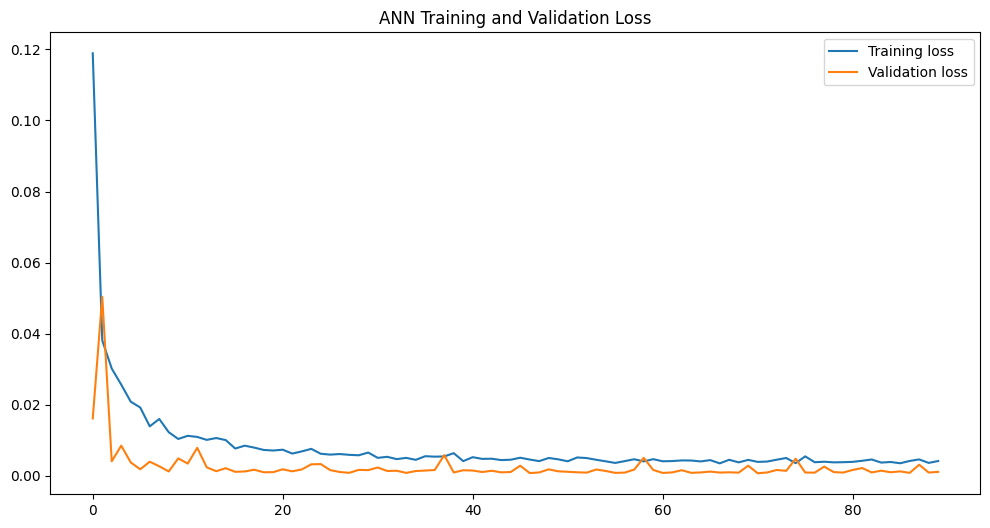

In [111]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [112]:
test_predictions_scaled=model.predict(X_test_scaled)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [113]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 26.6705
RMSE: 5.1643
MAE: 3.1500
MAPE: 45.40%
R²: 0.9410


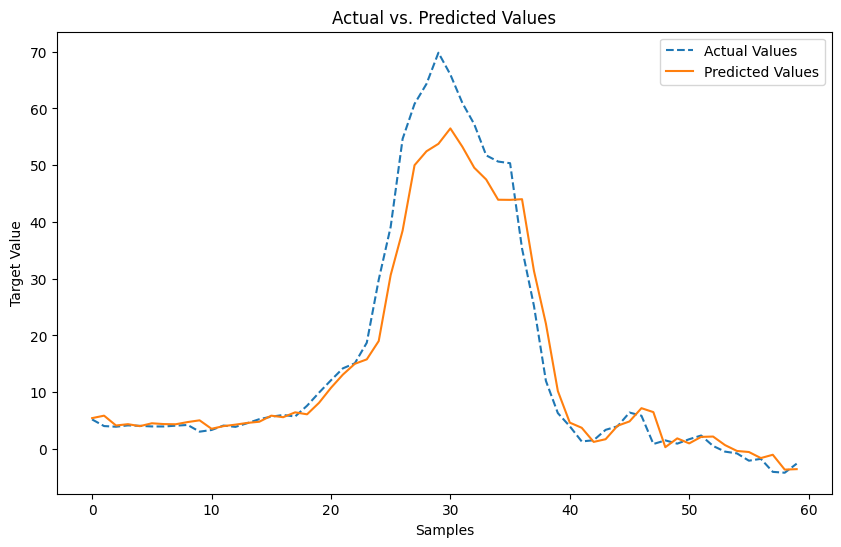

In [114]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 4

In [115]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [116]:

df=data.copy()
df = df.astype(float)


In [117]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [118]:
# Number of lags to create
lags = 4
lagged_features = create_lagged_features(df, lags)


In [119]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [120]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_

In [121]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')


In [122]:
df2=lagged_features.dropna()

In [123]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  \
4        2000.0          4.0

299

In [124]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
dtype: int64

In [125]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [126]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  \
4        2000.0          4.0          3.0          2.0          1.0   
5        2000.0          5.0          4.0          3.0          2.0   
6        2000.0          6.0          5.0          4.0          3.0   
7        2000.0          7.0          6.0          5.0          4.0   
8        2000.0          8.0          7.0          6.0          5.0   
..          ...          ...          ...          ...          ...   
298      2024.0         10.0          9.0          8.0          7.0   
299      2024.0         11.0         10.0          9.0          8.0   
300      2024.0         12.0         11.0         10.0          9.0   
301      2024.0          1.0         12.0         11.0         10.0   
302      2024.0          2.0          1.0         12.0         11.0   

     Day_lag_1  Day_lag_2  Day_lag_3  Day_lag_4  Inflation_lag_1  \
4         30.0       31.0       28.0       31.0         3.672022   
5         31.0       30.0       31.0       28.0         2.382412   
6         30.0       31.0       30.0       31.0         6.799835   
7         31.0       30.0       31.0       30.0        10.139831   
8         31.0       31.0       30.0       31.0         9.876072   
..         ...        ...        ...        ...              ...   
298       31.0       30.0       31.0       31.0        -0.783699   
299       30.0       31.0       30.0       31.0        -2.068252   
300       31.0       30.0       31.0       30.0        -1.742696   
301       31.0       31.0       30.0       31.0        -4.035874   
302       28.0       31.0       31.0       30.0        -4.187438   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  
4           4.469678         1.940367         0.329139  
5           3.672022         4.469678         1.940367  
6           2.382412         3.672022         4.469678  
7           6.799835         2.382412         3.672022  
8          10.139831         6.799835         2.382412  
..               ...              ...              ...  
298        -0.469239         0.526039         2.365931  
299        -0.783699        -0.469239         0.526039  
300        -2.068252        -0.783699        -0.469239  
301        -1.742696        -2.068252        -0.783699  
302        -4.035874        -1.742696        -2.068252  

[299 rows x 20 columns]

In [127]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [128]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  \
4        2000.0          4.0          3.0          2.0          1.0   
5        2000.0          5.0          4.0          3.0          2.0   
6        2000.0          6.0          5.0          4.0          3.0   
7        2000.0          7.0          6.0          5.0          4.0   
8        2000.0          8.0          7.0          6.0          5.0   
..          ...          ...          ...          ...          ...   
238      2019.0         10.0          9.0          8.0          7.0   
239      2019.0         11.0         10.0          9.0          8.0   
240      2019.0         12.0         11.0         10.0          9.0   
241      2019.0          1.0         12.0         11.0         10.0   
242      2019.0          2.0          1.0         12.0         11.0   

     Day_lag_1  Day_lag_2  Day_lag_3  Day_lag_4  Inflation_lag_1  \
4         30.0       31.0       28.0       31.0         3.672022   
5         31.0       30.0       31.0       28.0         2.382412   
6         30.0       31.0       30.0       31.0         6.799835   
7         31.0       30.0       31.0       30.0        10.139831   
8         31.0       31.0       30.0       31.0         9.876072   
..         ...        ...        ...        ...              ...   
238       31.0       30.0       31.0       31.0         5.377207   
239       30.0       31.0       30.0       31.0         4.358162   
240       31.0       30.0       31.0       30.0         4.829770   
241       31.0       31.0       30.0       31.0         5.651491   
242       28.0       31.0       31.0       30.0         6.151420   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  
4           4.469678         1.940367         0.329139  
5           3.672022         4.469678         1.940367  
6           2.382412         3.672022         4.469678  
7           6.799835         2.382412         3.672022  
8          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         4.963971         3.418124         3.338633  
239         5.377207         4.963971         3.418124  
240         4.358162         5.377207         4.963971  
241         4.829770         4.358162         5.377207  
242         5.651491         4.829770         4.358162  

[239 rows x 20 columns]

In [129]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [130]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  \
4        2000.0          4.0          3.0          2.0          1.0   
5        2000.0          5.0          4.0          3.0          2.0   
6        2000.0          6.0          5.0          4.0          3.0   
7        2000.0          7.0          6.0          5.0          4.0   
8        2000.0          8.0          7.0          6.0          5.0   
..          ...          ...          ...          ...          ...   
238      2019.0         10.0          9.0          8.0          7.0   
239      2019.0         11.0         10.0          9.0          8.0   
240      2019.0         12.0         11.0         10.0          9.0   
241      2019.0          1.0         12.0         11.0         10.0   
242      2019.0          2.0          1.0         12.0         11.0   

     Day_lag_1  Day_lag_2  Day_lag_3  Day_lag_4  Inflation_lag_1  \
4         30.0       31.0       28.0       31.0         3.672022   
5         31.0       30.0       31.0       28.0         2.382412   
6         30.0       31.0       30.0       31.0         6.799835   
7         31.0       30.0       31.0       30.0        10.139831   
8         31.0       31.0       30.0       31.0         9.876072   
..         ...        ...        ...        ...              ...   
238       31.0       30.0       31.0       31.0         5.377207   
239       30.0       31.0       30.0       31.0         4.358162   
240       31.0       30.0       31.0       30.0         4.829770   
241       31.0       31.0       30.0       31.0         5.651491   
242       28.0       31.0       31.0       30.0         6.151420   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  
4           4.469678         1.940367         0.329139  
5           3.672022         4.469678         1.940367  
6           2.382412         3.672022         4.469678  
7           6.799835         2.382412         3.672022  
8          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         4.963971         3.418124         3.338633  
239         5.377207         4.963971         3.418124  
240         4.358162         5.377207         4.963971  
241         4.829770         4.358162         5.377207  
242         5.651491         4.829770         4.358162  

[239 rows x 20 columns]

In [131]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

243     5.196850
244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [132]:
from sklearn.preprocessing import MinMaxScaler

In [133]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4'],
      dtype='object')

In [134]:
ytrain

4       2.382412
5       6.799835
6      10.139831
7       9.876072
8       8.455851
         ...    
238     4.358162
239     4.829770
240     5.651491
241     6.151420
242     5.371248
Name: Inflation, Length: 239, dtype: float64

In [135]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [136]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [137]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
4    2000.0    5.0  31.0      2000.0      2000.0      2000.0      2000.0   
5    2000.0    6.0  30.0      2000.0      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0      2000.0      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0      2000.0      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0      2000.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
238  2019.0   11.0  30.0      2019.0      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  Day_lag_1  Day_lag_2  \
4            4.0          3.0          2.0          1.0       30.0       31.0   
5            5.0          4.0          3.0          2.0       31.0       30.0   
6            6.0          5.0          4.0          3.0       30.0       31.0   
7            7.0          6.0          5.0          4.0       31.0       30.0   
8            8.0          7.0          6.0          5.0       31.0       31.0   
..           ...          ...          ...          ...        ...        ...   
238         10.0          9.0          8.0          7.0       31.0       30.0   
239         11.0         10.0          9.0          8.0       30.0       31.0   
240         12.0         11.0         10.0          9.0       31.0       30.0   
241          1.0         12.0         11.0         10.0       31.0       31.0   
242          2.0          1.0         12.0         11.0       28.0       31.0   

     Day_lag_3  Day_lag_4  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
4         28.0       31.0         3.672022         4.469678         1.940367   
5         31.0       28.0         2.382412         3.672022         4.469678   
6         30.0       31.0         6.799835         2.382412         3.672022   
7         31.0       30.0        10.139831         6.799835         2.382412   
8         30.0       31.0         9.876072        10.139831         6.799835   
..         ...        ...              ...              ...              ...   
238       31.0       31.0         5.377207         4.963971         3.418124   
239       30.0       31.0         4.358162         5.377207         4.963971   
240       31.0       30.0         4.829770         4.358162         5.377207   
241       30.0       31.0         5.651491         4.829770         4.358162   
242       31.0       30.0         6.151420         5.651491         4.829770   

     Inflation_lag_4  
4           0.329139  
5           1.940367  
6           4.469678  
7           3.672022  
8           2.382412  
..               ...  
238         3.338633  
239         3.418124  
240         4.963971  
241         5.377207  
242         4.358162  

[239 rows x 19 columns]

In [138]:
df1=pd.DataFrame(ytrain)

In [139]:
X_train_scaled

array([[0.        , 0.36363636, 1.        , ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.45454545, 0.66666667, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.54545455, 1.        , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.        , 1.        , ..., 0.13140674, 0.1685216 ,
        0.16625658],
       [1.        , 0.09090909, 0.        , ..., 0.1485833 , 0.13140674,
        0.18107981],
       [1.        , 0.18181818, 1.        , ..., 0.17851136, 0.1485833 ,
        0.14452552]])

In [140]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [141]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
4    0.00  0.363636  1.000000        0.00        0.00         0.0         0.0   
5    0.00  0.454545  0.666667        0.00        0.00         0.0         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  Day_lag_1  Day_lag_2  \
4       0.272727     0.181818     0.090909     0.000000   0.666667   1.000000   
5       0.363636     0.272727     0.181818     0.090909   1.000000   0.666667   
6       0.454545     0.363636     0.272727     0.181818   0.666667   1.000000   
7       0.545455     0.454545     0.363636     0.272727   1.000000   0.666667   
8       0.636364     0.545455     0.454545     0.363636   1.000000   1.000000   
..           ...          ...          ...          ...        ...        ...   
238     0.818182     0.727273     0.636364     0.545455   1.000000   0.666667   
239     0.909091     0.818182     0.727273     0.636364   0.666667   1.000000   
240     1.000000     0.909091     0.818182     0.727273   1.000000   0.666667   
241     0.000000     1.000000     0.909091     0.818182   1.000000   1.000000   
242     0.090909     0.000000     1.000000     0.909091   0.000000   1.000000   

     Day_lag_3  Day_lag_4  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
4     0.000000   1.000000         0.106417         0.135468         0.043348   
5     1.000000   0.000000         0.059448         0.106417         0.135468   
6     0.666667   1.000000         0.220335         0.059448         0.106417   
7     1.000000   0.666667         0.341982         0.220335         0.059448   
8     0.666667   1.000000         0.332376         0.341982         0.220335   
..         ...        ...              ...              ...              ...   
238   1.000000   1.000000         0.168522         0.153471         0.097169   
239   0.666667   1.000000         0.131407         0.168522         0.153471   
240   1.000000   0.666667         0.148583         0.131407         0.168522   
241   0.666667   1.000000         0.178511         0.148583         0.131407   
242   1.000000   0.666667         0.196719         0.178511         0.148583   

     Inflation_lag_4  
4           0.000000  
5           0.057797  
6           0.148526  
7           0.119913  
8           0.073653  
..               ...  
238         0.107954  
239         0.110805  
240         0.166257  
241         0.181080  
242         0.144526  

[239 rows x 19 columns]

In [142]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [143]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
4     2.382412  0.00  0.363636  1.000000        0.00        0.00         0.0   
5     6.799835  0.00  0.454545  0.666667        0.00        0.00         0.0   
6    10.139831  0.00  0.545455  1.000000        0.00        0.00         0.0   
7     9.876072  0.00  0.636364  1.000000        0.00        0.00         0.0   
8     8.455851  0.00  0.727273  0.666667        0.00        0.00         0.0   
..         ...   ...       ...       ...         ...         ...         ...   
238   4.358162  0.95  0.909091  0.666667        0.95        0.95         1.0   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95         1.0   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95         1.0   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95         1.0   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Year_lag_4  Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  \
4           0.0     0.272727     0.181818     0.090909     0.000000   
5           0.0     0.363636     0.272727     0.181818     0.090909   
6           0.0     0.454545     0.363636     0.272727     0.181818   
7           0.0     0.545455     0.454545     0.363636     0.272727   
8           0.0     0.636364     0.545455     0.454545     0.363636   
..          ...          ...          ...          ...          ...   
238         1.0     0.818182     0.727273     0.636364     0.545455   
239         1.0     0.909091     0.818182     0.727273     0.636364   
240         1.0     1.000000     0.909091     0.818182     0.727273   
241         1.0     0.000000     1.000000     0.909091     0.818182   
242         1.0     0.090909     0.000000     1.000000     0.909091   

     Day_lag_1  Day_lag_2  Day_lag_3  Day_lag_4  Inflation_lag_1  \
4     0.666667   1.000000   0.000000   1.000000         0.106417   
5     1.000000   0.666667   1.000000   0.000000         0.059448   
6     0.666667   1.000000   0.666667   1.000000         0.220335   
7     1.000000   0.666667   1.000000   0.666667         0.341982   
8     1.000000   1.000000   0.666667   1.000000         0.332376   
..         ...        ...        ...        ...              ...   
238   1.000000   0.666667   1.000000   1.000000         0.168522   
239   0.666667   1.000000   0.666667   1.000000         0.131407   
240   1.000000   0.666667   1.000000   0.666667         0.148583   
241   1.000000   1.000000   0.666667   1.000000         0.178511   
242   0.000000   1.000000   1.000000   0.666667         0.196719   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  
4           0.135468         0.043348         0.000000  
5           0.106417         0.135468         0.057797  
6           0.059448         0.106417         0.148526  
7           0.220335         0.059448         0.119913  
8           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.153471         0.097169         0.107954  
239         0.168522         0.153471         0.110805  
240         0.131407         0.168522         0.166257  
241         0.148583         0.131407         0.181080  
242         0.178511         0.148583         0.144526  

[239 rows x 20 columns]

In [144]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
4    0.00  0.363636  1.000000        0.00        0.00         0.0         0.0   
5    0.00  0.454545  0.666667        0.00        0.00         0.0         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Month_lag_1  Month_lag_2  Month_lag_3  Month_lag_4  Day_lag_1  Day_lag_2  \
4       0.272727     0.181818     0.090909     0.000000   0.666667   1.000000   
5       0.363636     0.272727     0.181818     0.090909   1.000000   0.666667   
6       0.454545     0.363636     0.272727     0.181818   0.666667   1.000000   
7       0.545455     0.454545     0.363636     0.272727   1.000000   0.666667   
8       0.636364     0.545455     0.454545     0.363636   1.000000   1.000000   
..           ...          ...          ...          ...        ...        ...   
238     0.818182     0.727273     0.636364     0.545455   1.000000   0.666667   
239     0.909091     0.818182     0.727273     0.636364   0.666667   1.000000   
240     1.000000     0.909091     0.818182     0.727273   1.000000   0.666667   
241     0.000000     1.000000     0.909091     0.818182   1.000000   1.000000   
242     0.090909     0.000000     1.000000     0.909091   0.000000   1.000000   

     Day_lag_3  Day_lag_4  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
4     0.000000   1.000000         0.106417         0.135468         0.043348   
5     1.000000   0.000000         0.059448         0.106417         0.135468   
6     0.666667   1.000000         0.220335         0.059448         0.106417   
7     1.000000   0.666667         0.341982         0.220335         0.059448   
8     0.666667   1.000000         0.332376         0.341982         0.220335   
..         ...        ...              ...              ...              ...   
238   1.000000   1.000000         0.168522         0.153471         0.097169   
239   0.666667   1.000000         0.131407         0.168522         0.153471   
240   1.000000   0.666667         0.148583         0.131407         0.168522   
241   0.666667   1.000000         0.178511         0.148583         0.131407   
242   1.000000   0.666667         0.196719         0.178511         0.148583   

     Inflation_lag_4  
4           0.000000  
5           0.057797  
6           0.148526  
7           0.119913  
8           0.073653  
..               ...  
238         0.107954  
239         0.110805  
240         0.166257  
241         0.181080  
242         0.144526  

[239 rows x 19 columns]

In [145]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 05:08:38,453] A new study created in memory with name: no-name-466f90e2-78c5-4960-b44e-6df70d025172
[I 2025-05-29 05:09:18,622] Trial 0 finished with value: 0.03861467409878969 and parameters: {'input_units': 32, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 16, 'dropout_rate_0': 0.13669491396682037, 'n_units_1': 16, 'dropout_rate_1': 0.05917295101662712, 'n_units_2': 128, 'dropout_rate_2': 0.39603941263537934, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 70}. Best is trial 0 with value: 0.03861467409878969.
[I 2025-05-29 05:10:02,252] Trial 1 finished with value: 0.012244429369457067 and parameters: {'input_units': 96, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.01483319069729977, 'optimizer': 'RMSprop', 'batch_size': 48, 'epochs': 100}. Best is trial 1 with value: 0.012244429369457067.
[I 2025-05-29 05:10:36,153] Trial 2 finished with value: 0.013344865944236516 and parameters: {'input_units': 32, 'activation': 'relu', 'num_la

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 32, 'dropout_rate_0': 0.08639153554185422, 'n_units_1': 128, 'dropout_rate_1': 0.46497257665301456, 'n_units_2': 96, 'dropout_rate_2': 0.17210761940246389, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 3, 'n_units_0': 32, 'dropout_rate_0': 0.08639153554185422, 'n_units_1': 128, 'dropout_rate_1': 0.46497257665301456, 'n_units_2': 96, 'dropout_rate_2': 0.17210761940246389, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 90}
Epoch 1/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.1293 - mae: 0.2826 - val_loss: 0.0152 - val_mae: 0.1084
Epoch 2/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0544 - mae: 0.1888 - val_loss: 0.0202 - val_mae: 0.1321
Epoch 3/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0405 - mae: 0.1515 - val_loss: 0.0054 - val_mae: 0.0592
Epoch 4/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0263 - mae: 0.1326 - val_loss: 0.0031 - val_mae: 0.0461
Epoch 5/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0241 - mae: 0.1246 - val_loss: 0.0019 - val_mae: 0.0373
Epoch 6/90
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0291 - mae: 0.1284 - val_loss: 0.0044 - val_mae: 0.0582
Ep

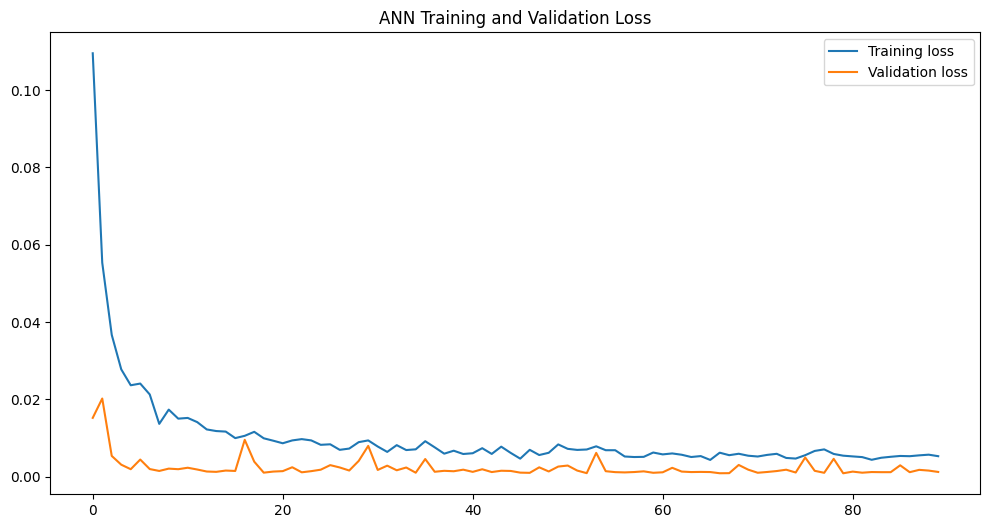

In [146]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [147]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [148]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 39.9366
RMSE: 6.3195
MAE: 3.7780
MAPE: 49.04%
R²: 0.9117


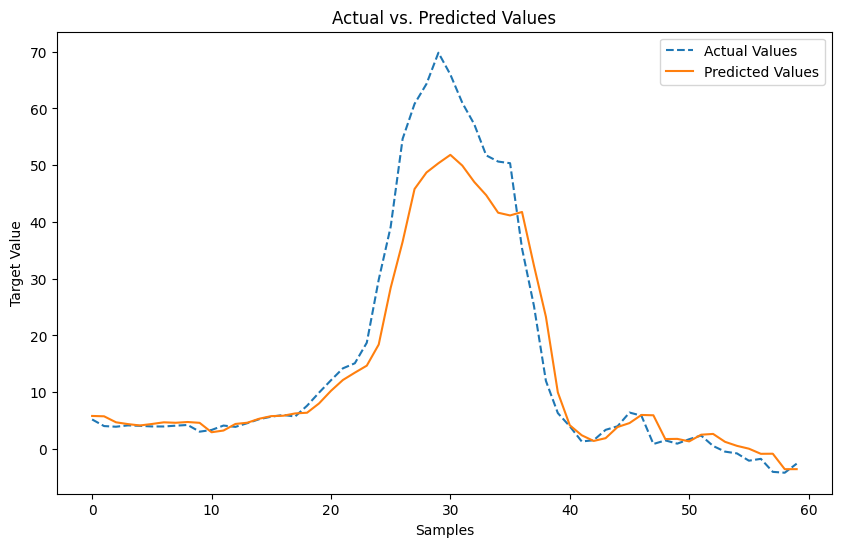

In [149]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 5

In [150]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [151]:

df=data.copy()
df = df.astype(float)


In [152]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [153]:
# Number of lags to create
lags = 5
lagged_features = create_lagged_features(df, lags)


In [154]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [155]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_

In [156]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Month_lag_1', 'Month_lag_2',
       'Month_lag_3', 'Month_lag_4', 'Month_lag_5', 'Day_lag_1', 'Day_lag_2',
       'Day_lag_3', 'Day_lag_4', 'Day_lag_5', 'Inflation_lag_1',
       'Inflation_lag_2', 'Inflation_lag_3', 'Inflation_lag_4',
       'Inflation_lag_5'],
      dtype='object')


In [157]:
df2=lagged_features.dropna()

In [158]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_2  \
5        2000.0      2000.0 

298

In [159]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Year_lag_5         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Month_lag_5        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Day_lag_5          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
Inflation_lag_5    0
dtype: int64

In [160]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [161]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_2  \
5        2000.0      2000.0          5.0  ...       31.0       30.0   
6        2000.0      2000.0          6.0  ...       30.0       31.0   
7        2000.0      2000.0          7.0  ...       31.0       30.0   
8        2000.0      2000.0          8.0  ...       31.0       31.0   
9        2000.0      2000.0          9.0  ...       30.0       31.0   
..          ...         ...          ...  ...        ...        ...   
298      2024.0      2024.0         10.0  ...       31.0       30.0   
299      2024.0      2024.0         11.0  ...       30.0       31.0   
300      2024.0      2024.0         12.0  ...       31.0       30.0   
301      2024.0      2024.0          1.0  ...       31.0       31.0   
302      2024.0      2024.0          2.0  ...       28.0       31.0   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5         31.0       28.0       31.0         2.382412         3.672022   
6         30.0       31.0       28.0         6.799835         2.382412   
7         31.0       30.0       31.0        10.139831         6.799835   
8         30.0       31.0       30.0         9.876072        10.139831   
9         31.0       30.0       31.0         8.455851         9.876072   
..         ...        ...        ...              ...              ...   
298       31.0       31.0       30.0        -0.783699        -0.469239   
299       30.0       31.0       31.0        -2.068252        -0.783699   
300       31.0       30.0       31.0        -1.742696        -2.068252   
301       30.0       31.0       30.0        -4.035874        -1.742696   
302       31.0       30.0       31.0        -4.187438        -4.035874   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           4.469678         1.940367         0.329139  
6           3.672022         4.469678         1.940367  
7           2.382412         3.672022         4.469678  
8           6.799835         2.382412         3.672022  
9          10.139831         6.799835         2.382412  
..               ...              ...              ...  
298         0.526039         2.365931         1.716069  
299        -0.469239         0.526039         2.365931  
300        -0.783699        -0.469239         0.526039  
301        -2.068252        -0.783699        -0.469239  
302        -1.742696        -2.068252        -0.783699  

[298 rows x 24 columns]

In [162]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [163]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_2  \
5        2000.0      2000.0          5.0  ...       31.0       30.0   
6        2000.0      2000.0          6.0  ...       30.0       31.0   
7        2000.0      2000.0          7.0  ...       31.0       30.0   
8        2000.0      2000.0          8.0  ...       31.0       31.0   
9        2000.0      2000.0          9.0  ...       30.0       31.0   
..          ...         ...          ...  ...        ...        ...   
238      2019.0      2019.0         10.0  ...       31.0       30.0   
239      2019.0      2019.0         11.0  ...       30.0       31.0   
240      2019.0      2019.0         12.0  ...       31.0       30.0   
241      2019.0      2019.0          1.0  ...       31.0       31.0   
242      2019.0      2019.0          2.0  ...       28.0       31.0   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5         31.0       28.0       31.0         2.382412         3.672022   
6         30.0       31.0       28.0         6.799835         2.382412   
7         31.0       30.0       31.0        10.139831         6.799835   
8         30.0       31.0       30.0         9.876072        10.139831   
9         31.0       30.0       31.0         8.455851         9.876072   
..         ...        ...        ...              ...              ...   
238       31.0       31.0       30.0         5.377207         4.963971   
239       30.0       31.0       31.0         4.358162         5.377207   
240       31.0       30.0       31.0         4.829770         4.358162   
241       30.0       31.0       30.0         5.651491         4.829770   
242       31.0       30.0       31.0         6.151420         5.651491   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           4.469678         1.940367         0.329139  
6           3.672022         4.469678         1.940367  
7           2.382412         3.672022         4.469678  
8           6.799835         2.382412         3.672022  
9          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.418124         3.338633         3.827751  
239         4.963971         3.418124         3.338633  
240         5.377207         4.963971         3.418124  
241         4.358162         5.377207         4.963971  
242         4.829770         4.358162         5.377207  

[238 rows x 24 columns]

In [164]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [165]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
5    2000.0    6.0  30.0   6.799835      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_2  \
5        2000.0      2000.0          5.0  ...       31.0       30.0   
6        2000.0      2000.0          6.0  ...       30.0       31.0   
7        2000.0      2000.0          7.0  ...       31.0       30.0   
8        2000.0      2000.0          8.0  ...       31.0       31.0   
9        2000.0      2000.0          9.0  ...       30.0       31.0   
..          ...         ...          ...  ...        ...        ...   
238      2019.0      2019.0         10.0  ...       31.0       30.0   
239      2019.0      2019.0         11.0  ...       30.0       31.0   
240      2019.0      2019.0         12.0  ...       31.0       30.0   
241      2019.0      2019.0          1.0  ...       31.0       31.0   
242      2019.0      2019.0          2.0  ...       28.0       31.0   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5         31.0       28.0       31.0         2.382412         3.672022   
6         30.0       31.0       28.0         6.799835         2.382412   
7         31.0       30.0       31.0        10.139831         6.799835   
8         30.0       31.0       30.0         9.876072        10.139831   
9         31.0       30.0       31.0         8.455851         9.876072   
..         ...        ...        ...              ...              ...   
238       31.0       31.0       30.0         5.377207         4.963971   
239       30.0       31.0       31.0         4.358162         5.377207   
240       31.0       30.0       31.0         4.829770         4.358162   
241       30.0       31.0       30.0         5.651491         4.829770   
242       31.0       30.0       31.0         6.151420         5.651491   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           4.469678         1.940367         0.329139  
6           3.672022         4.469678         1.940367  
7           2.382412         3.672022         4.469678  
8           6.799835         2.382412         3.672022  
9          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.418124         3.338633         3.827751  
239         4.963971         3.418124         3.338633  
240         5.377207         4.963971         3.418124  
241         4.358162         5.377207         4.963971  
242         4.829770         4.358162         5.377207  

[238 rows x 24 columns]

In [166]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

243     5.196850
244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [167]:
from sklearn.preprocessing import MinMaxScaler

In [168]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Month_lag_5', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3',
       'Day_lag_4', 'Day_lag_5', 'Inflation_lag_1', 'Inflation_lag_2',
       'Inflation_lag_3', 'Inflation_lag_4', 'Inflation_lag_5'],
      dtype='object')

In [169]:
ytrain

5       6.799835
6      10.139831
7       9.876072
8       8.455851
9       7.794494
         ...    
238     4.358162
239     4.829770
240     5.651491
241     6.151420
242     5.371248
Name: Inflation, Length: 238, dtype: float64

In [170]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [171]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [172]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
5    2000.0    6.0  30.0      2000.0      2000.0      2000.0      2000.0   
6    2000.0    7.0  31.0      2000.0      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0      2000.0      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0      2000.0      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0      2000.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
238  2019.0   11.0  30.0      2019.0      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   

     Year_lag_5  Month_lag_1  Month_lag_2  ...  Day_lag_1  Day_lag_2  \
5        2000.0          5.0          4.0  ...       31.0       30.0   
6        2000.0          6.0          5.0  ...       30.0       31.0   
7        2000.0          7.0          6.0  ...       31.0       30.0   
8        2000.0          8.0          7.0  ...       31.0       31.0   
9        2000.0          9.0          8.0  ...       30.0       31.0   
..          ...          ...          ...  ...        ...        ...   
238      2019.0         10.0          9.0  ...       31.0       30.0   
239      2019.0         11.0         10.0  ...       30.0       31.0   
240      2019.0         12.0         11.0  ...       31.0       30.0   
241      2019.0          1.0         12.0  ...       31.0       31.0   
242      2019.0          2.0          1.0  ...       28.0       31.0   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5         31.0       28.0       31.0         2.382412         3.672022   
6         30.0       31.0       28.0         6.799835         2.382412   
7         31.0       30.0       31.0        10.139831         6.799835   
8         30.0       31.0       30.0         9.876072        10.139831   
9         31.0       30.0       31.0         8.455851         9.876072   
..         ...        ...        ...              ...              ...   
238       31.0       31.0       30.0         5.377207         4.963971   
239       30.0       31.0       31.0         4.358162         5.377207   
240       31.0       30.0       31.0         4.829770         4.358162   
241       30.0       31.0       30.0         5.651491         4.829770   
242       31.0       30.0       31.0         6.151420         5.651491   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           4.469678         1.940367         0.329139  
6           3.672022         4.469678         1.940367  
7           2.382412         3.672022         4.469678  
8           6.799835         2.382412         3.672022  
9          10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.418124         3.338633         3.827751  
239         4.963971         3.418124         3.338633  
240         5.377207         4.963971         3.418124  
241         4.358162         5.377207         4.963971  
242         4.829770         4.358162         5.377207  

[238 rows x 23 columns]

In [173]:
df1=pd.DataFrame(ytrain)

In [174]:
X_train_scaled

array([[0.        , 0.45454545, 0.66666667, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.54545455, 1.        , ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.63636364, 1.        , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.        , 1.        , ..., 0.1685216 , 0.15347105,
        0.11080532],
       [1.        , 0.09090909, 0.        , ..., 0.13140674, 0.1685216 ,
        0.16625658],
       [1.        , 0.18181818, 1.        , ..., 0.1485833 , 0.13140674,
        0.18107981]])

In [175]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [176]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
5    0.00  0.454545  0.666667        0.00        0.00         0.0         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Month_lag_1  Month_lag_2  ...  Day_lag_1  Day_lag_2  \
5           0.0     0.363636     0.272727  ...   1.000000   0.666667   
6           0.0     0.454545     0.363636  ...   0.666667   1.000000   
7           0.0     0.545455     0.454545  ...   1.000000   0.666667   
8           0.0     0.636364     0.545455  ...   1.000000   1.000000   
9           0.0     0.727273     0.636364  ...   0.666667   1.000000   
..          ...          ...          ...  ...        ...        ...   
238         1.0     0.818182     0.727273  ...   1.000000   0.666667   
239         1.0     0.909091     0.818182  ...   0.666667   1.000000   
240         1.0     1.000000     0.909091  ...   1.000000   0.666667   
241         1.0     0.000000     1.000000  ...   1.000000   1.000000   
242         1.0     0.090909     0.000000  ...   0.000000   1.000000   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5     1.000000   0.000000   1.000000         0.059448         0.106417   
6     0.666667   1.000000   0.000000         0.220335         0.059448   
7     1.000000   0.666667   1.000000         0.341982         0.220335   
8     0.666667   1.000000   0.666667         0.332376         0.341982   
9     1.000000   0.666667   1.000000         0.280650         0.332376   
..         ...        ...        ...              ...              ...   
238   1.000000   1.000000   0.666667         0.168522         0.153471   
239   0.666667   1.000000   1.000000         0.131407         0.168522   
240   1.000000   0.666667   1.000000         0.148583         0.131407   
241   0.666667   1.000000   0.666667         0.178511         0.148583   
242   1.000000   0.666667   1.000000         0.196719         0.178511   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           0.135468         0.043348         0.000000  
6           0.106417         0.135468         0.057797  
7           0.059448         0.106417         0.148526  
8           0.220335         0.059448         0.119913  
9           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.097169         0.094274         0.125499  
239         0.153471         0.097169         0.107954  
240         0.168522         0.153471         0.110805  
241         0.131407         0.168522         0.166257  
242         0.148583         0.131407         0.181080  

[238 rows x 23 columns]

In [177]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [178]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
5     6.799835  0.00  0.454545  0.666667        0.00        0.00         0.0   
6    10.139831  0.00  0.545455  1.000000        0.00        0.00         0.0   
7     9.876072  0.00  0.636364  1.000000        0.00        0.00         0.0   
8     8.455851  0.00  0.727273  0.666667        0.00        0.00         0.0   
9     7.794494  0.00  0.818182  1.000000        0.00        0.00         0.0   
..         ...   ...       ...       ...         ...         ...         ...   
238   4.358162  0.95  0.909091  0.666667        0.95        0.95         1.0   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95         1.0   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95         1.0   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95         1.0   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Year_lag_4  Year_lag_5  Month_lag_1  ...  Day_lag_1  Day_lag_2  \
5           0.0         0.0     0.363636  ...   1.000000   0.666667   
6           0.0         0.0     0.454545  ...   0.666667   1.000000   
7           0.0         0.0     0.545455  ...   1.000000   0.666667   
8           0.0         0.0     0.636364  ...   1.000000   1.000000   
9           0.0         0.0     0.727273  ...   0.666667   1.000000   
..          ...         ...          ...  ...        ...        ...   
238         1.0         1.0     0.818182  ...   1.000000   0.666667   
239         1.0         1.0     0.909091  ...   0.666667   1.000000   
240         1.0         1.0     1.000000  ...   1.000000   0.666667   
241         1.0         1.0     0.000000  ...   1.000000   1.000000   
242         1.0         1.0     0.090909  ...   0.000000   1.000000   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5     1.000000   0.000000   1.000000         0.059448         0.106417   
6     0.666667   1.000000   0.000000         0.220335         0.059448   
7     1.000000   0.666667   1.000000         0.341982         0.220335   
8     0.666667   1.000000   0.666667         0.332376         0.341982   
9     1.000000   0.666667   1.000000         0.280650         0.332376   
..         ...        ...        ...              ...              ...   
238   1.000000   1.000000   0.666667         0.168522         0.153471   
239   0.666667   1.000000   1.000000         0.131407         0.168522   
240   1.000000   0.666667   1.000000         0.148583         0.131407   
241   0.666667   1.000000   0.666667         0.178511         0.148583   
242   1.000000   0.666667   1.000000         0.196719         0.178511   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           0.135468         0.043348         0.000000  
6           0.106417         0.135468         0.057797  
7           0.059448         0.106417         0.148526  
8           0.220335         0.059448         0.119913  
9           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.097169         0.094274         0.125499  
239         0.153471         0.097169         0.107954  
240         0.168522         0.153471         0.110805  
241         0.131407         0.168522         0.166257  
242         0.148583         0.131407         0.181080  

[238 rows x 24 columns]

In [179]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
5    0.00  0.454545  0.666667        0.00        0.00         0.0         0.0   
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Month_lag_1  Month_lag_2  ...  Day_lag_1  Day_lag_2  \
5           0.0     0.363636     0.272727  ...   1.000000   0.666667   
6           0.0     0.454545     0.363636  ...   0.666667   1.000000   
7           0.0     0.545455     0.454545  ...   1.000000   0.666667   
8           0.0     0.636364     0.545455  ...   1.000000   1.000000   
9           0.0     0.727273     0.636364  ...   0.666667   1.000000   
..          ...          ...          ...  ...        ...        ...   
238         1.0     0.818182     0.727273  ...   1.000000   0.666667   
239         1.0     0.909091     0.818182  ...   0.666667   1.000000   
240         1.0     1.000000     0.909091  ...   1.000000   0.666667   
241         1.0     0.000000     1.000000  ...   1.000000   1.000000   
242         1.0     0.090909     0.000000  ...   0.000000   1.000000   

     Day_lag_3  Day_lag_4  Day_lag_5  Inflation_lag_1  Inflation_lag_2  \
5     1.000000   0.000000   1.000000         0.059448         0.106417   
6     0.666667   1.000000   0.000000         0.220335         0.059448   
7     1.000000   0.666667   1.000000         0.341982         0.220335   
8     0.666667   1.000000   0.666667         0.332376         0.341982   
9     1.000000   0.666667   1.000000         0.280650         0.332376   
..         ...        ...        ...              ...              ...   
238   1.000000   1.000000   0.666667         0.168522         0.153471   
239   0.666667   1.000000   1.000000         0.131407         0.168522   
240   1.000000   0.666667   1.000000         0.148583         0.131407   
241   0.666667   1.000000   0.666667         0.178511         0.148583   
242   1.000000   0.666667   1.000000         0.196719         0.178511   

     Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  
5           0.135468         0.043348         0.000000  
6           0.106417         0.135468         0.057797  
7           0.059448         0.106417         0.148526  
8           0.220335         0.059448         0.119913  
9           0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.097169         0.094274         0.125499  
239         0.153471         0.097169         0.107954  
240         0.168522         0.153471         0.110805  
241         0.131407         0.168522         0.166257  
242         0.148583         0.131407         0.181080  

[238 rows x 23 columns]

In [180]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 05:43:37,177] A new study created in memory with name: no-name-dfbd7b3b-7147-444d-8ed2-44825752a024
[I 2025-05-29 05:43:44,511] Trial 0 finished with value: 0.04153710417449474 and parameters: {'input_units': 96, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 128, 'dropout_rate_0': 0.328941675435392, 'n_units_1': 48, 'dropout_rate_1': 0.31548750990392743, 'n_units_2': 128, 'dropout_rate_2': 0.32645088788805376, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.04153710417449474.
[I 2025-05-29 05:44:22,768] Trial 1 finished with value: 0.04923410192131996 and parameters: {'input_units': 64, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.44394444659236737, 'n_units_1': 64, 'dropout_rate_1': 0.2857111785323166, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 70}. Best is trial 0 with value: 0.04153710417449474.
[I 2025-05-29 05:45:12,057] Trial 2 finished with value: 0.020186066161841154 and parameters:

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.3784909538964535, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 80}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.3784909538964535, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 80}
Epoch 1/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1961 - mae: 0.3513 - val_loss: 0.0108 - val_mae: 0.0773
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0775 - mae: 0.2198 - val_loss: 0.0037 - val_mae: 0.0496
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0568 - mae: 0.1983 - val_loss: 0.0126 - val_mae: 0.0969
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0532 - mae: 0.1827 - val_loss: 0.0052 - val_mae: 0.0590
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0383 - mae: 0.1546 - val_loss: 0.0261 - val_mae: 0.1532
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0424 - mae: 0.1636 - val_loss: 0.0301 - val_mae: 0.1650
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0398 - mae: 0.1566 - val_loss: 0.0033 - val_ma

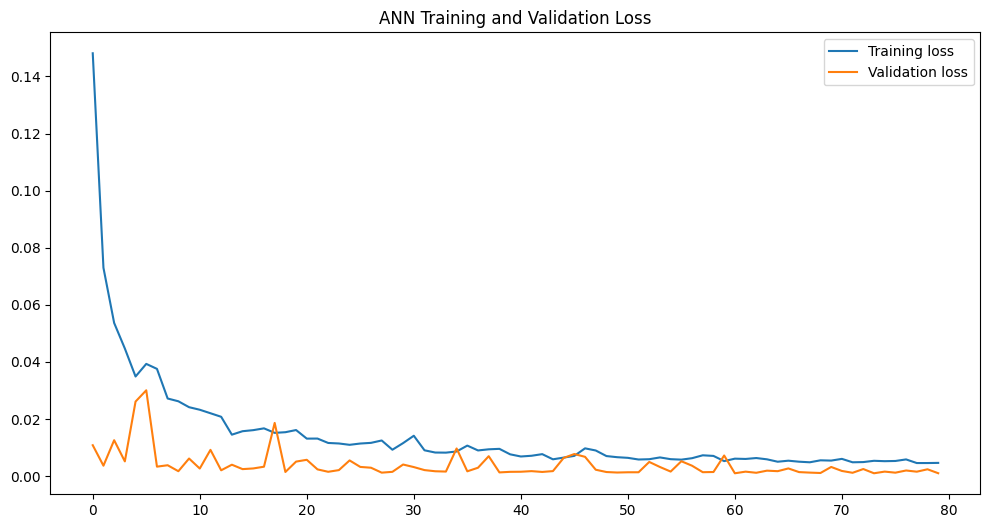

In [181]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [182]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [183]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 42.5088
RMSE: 6.5199
MAE: 3.8496
MAPE: 49.08%
R²: 0.9060


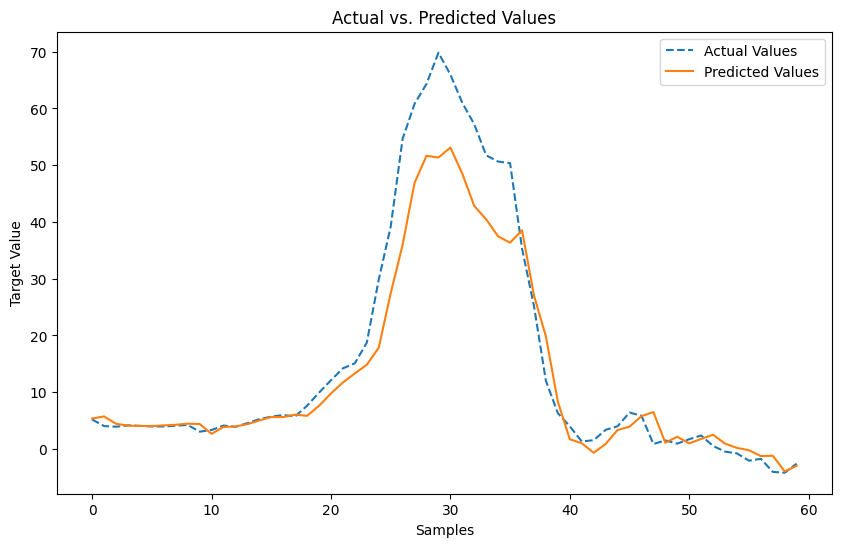

In [184]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 6

In [185]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [186]:

df=data.copy()
df = df.astype(float)


In [187]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [188]:
# Number of lags to create
lags = 6
lagged_features = create_lagged_features(df, lags)


In [189]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [190]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4

In [191]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Month_lag_1',
       'Month_lag_2', 'Month_lag_3', 'Month_lag_4', 'Month_lag_5',
       'Month_lag_6', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4',
       'Day_lag_5', 'Day_lag_6', 'Inflation_lag_1', 'Inflation_lag_2',
       'Inflation_lag_3', 'Inflation_lag_4', 'Inflation_lag_5',
       'Inflation_lag_6'],
      dtype='object')


In [192]:
df2=lagged_features.dropna()

In [193]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4  Day_lag_5  \
6        2000.0   

297

In [194]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Year_lag_5         0
Year_lag_6         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Month_lag_5        0
Month_lag_6        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Day_lag_5          0
Day_lag_6          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
Inflation_lag_5    0
Inflation_lag_6    0
dtype: int64

In [195]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [196]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4  Day_lag_5  \
6        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
7        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       31.0       31.0       30.0   
..          ...         ...         ...  ...        ...        ...        ...   
298      2024.0      2024.0      2024.0  ...       31.0       31.0       30.0   
299      2024.0      2024.0      2024.0  ...       30.0       31.0       31.0   
300      2024.0      2024.0      2024.0  ...       31.0       30.0       31.0   
301      2024.0      2024.0      2024.0  ...       30.0       31.0       30.0   
302      2024.0      2024.0      2024.0  ...       31.0       30.0       31.0   

     Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6         31.0         6.799835         2.382412         3.672022   
7         28.0        10.139831         6.799835         2.382412   
8         31.0         9.876072        10.139831         6.799835   
9         30.0         8.455851         9.876072        10.139831   
10        31.0         7.794494         8.455851         9.876072   
..         ...              ...              ...              ...   
298       31.0        -0.783699        -0.469239         0.526039   
299       30.0        -2.068252        -0.783699        -0.469239   
300       31.0        -1.742696        -2.068252        -0.783699   
301       31.0        -4.035874        -1.742696        -2.068252   
302       30.0        -4.187438        -4.035874        -1.742696   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           4.469678         1.940367         0.329139  
7           3.672022         4.469678         1.940367  
8           2.382412         3.672022         4.469678  
9           6.799835         2.382412         3.672022  
10         10.139831         6.799835         2.382412  
..               ...              ...              ...  
298         2.365931         1.716069         0.936037  
299         0.526039         2.365931         1.716069  
300        -0.469239         0.526039         2.365931  
301        -0.783699        -0.469239         0.526039  
302        -2.068252        -0.783699        -0.469239  

[297 rows x 28 columns]

In [197]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [198]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4  Day_lag_5  \
6        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
7        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       31.0       31.0       30.0   
..          ...         ...         ...  ...        ...        ...        ...   
238      2019.0      2019.0      2019.0  ...       31.0       31.0       30.0   
239      2019.0      2019.0      2019.0  ...       30.0       31.0       31.0   
240      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   
241      2019.0      2019.0      2019.0  ...       30.0       31.0       30.0   
242      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   

     Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6         31.0         6.799835         2.382412         3.672022   
7         28.0        10.139831         6.799835         2.382412   
8         31.0         9.876072        10.139831         6.799835   
9         30.0         8.455851         9.876072        10.139831   
10        31.0         7.794494         8.455851         9.876072   
..         ...              ...              ...              ...   
238       31.0         5.377207         4.963971         3.418124   
239       30.0         4.358162         5.377207         4.963971   
240       31.0         4.829770         4.358162         5.377207   
241       31.0         5.651491         4.829770         4.358162   
242       30.0         6.151420         5.651491         4.829770   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           4.469678         1.940367         0.329139  
7           3.672022         4.469678         1.940367  
8           2.382412         3.672022         4.469678  
9           6.799835         2.382412         3.672022  
10         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.338633         3.827751         4.963385  
239         3.418124         3.338633         3.827751  
240         4.963971         3.418124         3.338633  
241         5.377207         4.963971         3.418124  
242         4.358162         5.377207         4.963971  

[237 rows x 28 columns]

In [199]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [200]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
6    2000.0    7.0  31.0  10.139831      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4  Day_lag_5  \
6        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
7        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       31.0       31.0       30.0   
..          ...         ...         ...  ...        ...        ...        ...   
238      2019.0      2019.0      2019.0  ...       31.0       31.0       30.0   
239      2019.0      2019.0      2019.0  ...       30.0       31.0       31.0   
240      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   
241      2019.0      2019.0      2019.0  ...       30.0       31.0       30.0   
242      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   

     Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6         31.0         6.799835         2.382412         3.672022   
7         28.0        10.139831         6.799835         2.382412   
8         31.0         9.876072        10.139831         6.799835   
9         30.0         8.455851         9.876072        10.139831   
10        31.0         7.794494         8.455851         9.876072   
..         ...              ...              ...              ...   
238       31.0         5.377207         4.963971         3.418124   
239       30.0         4.358162         5.377207         4.963971   
240       31.0         4.829770         4.358162         5.377207   
241       31.0         5.651491         4.829770         4.358162   
242       30.0         6.151420         5.651491         4.829770   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           4.469678         1.940367         0.329139  
7           3.672022         4.469678         1.940367  
8           2.382412         3.672022         4.469678  
9           6.799835         2.382412         3.672022  
10         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.338633         3.827751         4.963385  
239         3.418124         3.338633         3.827751  
240         4.963971         3.418124         3.338633  
241         5.377207         4.963971         3.418124  
242         4.358162         5.377207         4.963971  

[237 rows x 28 columns]

In [201]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

243     5.196850
244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [202]:
from sklearn.preprocessing import MinMaxScaler

In [203]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Month_lag_1', 'Month_lag_2',
       'Month_lag_3', 'Month_lag_4', 'Month_lag_5', 'Month_lag_6', 'Day_lag_1',
       'Day_lag_2', 'Day_lag_3', 'Day_lag_4', 'Day_lag_5', 'Day_lag_6',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6'],
      dtype='object')

In [204]:
ytrain

6      10.139831
7       9.876072
8       8.455851
9       7.794494
10      7.559566
         ...    
238     4.358162
239     4.829770
240     5.651491
241     6.151420
242     5.371248
Name: Inflation, Length: 237, dtype: float64

In [205]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [206]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [207]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
6    2000.0    7.0  31.0      2000.0      2000.0      2000.0      2000.0   
7    2000.0    8.0  31.0      2000.0      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0      2000.0      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0      2000.0      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0      2000.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
238  2019.0   11.0  30.0      2019.0      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   

     Year_lag_5  Year_lag_6  Month_lag_1  ...  Day_lag_3  Day_lag_4  \
6        2000.0      2000.0          6.0  ...       30.0       31.0   
7        2000.0      2000.0          7.0  ...       31.0       30.0   
8        2000.0      2000.0          8.0  ...       30.0       31.0   
9        2000.0      2000.0          9.0  ...       31.0       30.0   
10       2000.0      2000.0         10.0  ...       31.0       31.0   
..          ...         ...          ...  ...        ...        ...   
238      2019.0      2019.0         10.0  ...       31.0       31.0   
239      2019.0      2019.0         11.0  ...       30.0       31.0   
240      2019.0      2019.0         12.0  ...       31.0       30.0   
241      2019.0      2019.0          1.0  ...       30.0       31.0   
242      2019.0      2019.0          2.0  ...       31.0       30.0   

     Day_lag_5  Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6         28.0       31.0         6.799835         2.382412         3.672022   
7         31.0       28.0        10.139831         6.799835         2.382412   
8         30.0       31.0         9.876072        10.139831         6.799835   
9         31.0       30.0         8.455851         9.876072        10.139831   
10        30.0       31.0         7.794494         8.455851         9.876072   
..         ...        ...              ...              ...              ...   
238       30.0       31.0         5.377207         4.963971         3.418124   
239       31.0       30.0         4.358162         5.377207         4.963971   
240       31.0       31.0         4.829770         4.358162         5.377207   
241       30.0       31.0         5.651491         4.829770         4.358162   
242       31.0       30.0         6.151420         5.651491         4.829770   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           4.469678         1.940367         0.329139  
7           3.672022         4.469678         1.940367  
8           2.382412         3.672022         4.469678  
9           6.799835         2.382412         3.672022  
10         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.338633         3.827751         4.963385  
239         3.418124         3.338633         3.827751  
240         4.963971         3.418124         3.338633  
241         5.377207         4.963971         3.418124  
242         4.358162         5.377207         4.963971  

[237 rows x 27 columns]

In [208]:
df1=pd.DataFrame(ytrain)

In [209]:
X_train_scaled

array([[0.        , 0.54545455, 1.        , ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.63636364, 1.        , ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.72727273, 0.66666667, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.        , 1.        , ..., 0.15347105, 0.09716944,
        0.10795388],
       [1.        , 0.09090909, 0.        , ..., 0.1685216 , 0.15347105,
        0.11080532],
       [1.        , 0.18181818, 1.        , ..., 0.13140674, 0.1685216 ,
        0.16625658]])

In [210]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [211]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
10   0.00  0.909091  0.666667        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Year_lag_6  Month_lag_1  ...  Day_lag_3  Day_lag_4  \
6           0.0         0.0     0.454545  ...   0.666667   1.000000   
7           0.0         0.0     0.545455  ...   1.000000   0.666667   
8           0.0         0.0     0.636364  ...   0.666667   1.000000   
9           0.0         0.0     0.727273  ...   1.000000   0.666667   
10          0.0         0.0     0.818182  ...   1.000000   1.000000   
..          ...         ...          ...  ...        ...        ...   
238         1.0         1.0     0.818182  ...   1.000000   1.000000   
239         1.0         1.0     0.909091  ...   0.666667   1.000000   
240         1.0         1.0     1.000000  ...   1.000000   0.666667   
241         1.0         1.0     0.000000  ...   0.666667   1.000000   
242         1.0         1.0     0.090909  ...   1.000000   0.666667   

     Day_lag_5  Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6     0.000000   1.000000         0.220335         0.059448         0.106417   
7     1.000000   0.000000         0.341982         0.220335         0.059448   
8     0.666667   1.000000         0.332376         0.341982         0.220335   
9     1.000000   0.666667         0.280650         0.332376         0.341982   
10    0.666667   1.000000         0.256562         0.280650         0.332376   
..         ...        ...              ...              ...              ...   
238   0.666667   1.000000         0.168522         0.153471         0.097169   
239   1.000000   0.666667         0.131407         0.168522         0.153471   
240   1.000000   1.000000         0.148583         0.131407         0.168522   
241   0.666667   1.000000         0.178511         0.148583         0.131407   
242   1.000000   0.666667         0.196719         0.178511         0.148583   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           0.135468         0.043348         0.000000  
7           0.106417         0.135468         0.057797  
8           0.059448         0.106417         0.148526  
9           0.220335         0.059448         0.119913  
10          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.094274         0.112089         0.166236  
239         0.097169         0.094274         0.125499  
240         0.153471         0.097169         0.107954  
241         0.168522         0.153471         0.110805  
242         0.131407         0.168522         0.166257  

[237 rows x 27 columns]

In [212]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [213]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
6    10.139831  0.00  0.545455  1.000000        0.00        0.00         0.0   
7     9.876072  0.00  0.636364  1.000000        0.00        0.00         0.0   
8     8.455851  0.00  0.727273  0.666667        0.00        0.00         0.0   
9     7.794494  0.00  0.818182  1.000000        0.00        0.00         0.0   
10    7.559566  0.00  0.909091  0.666667        0.00        0.00         0.0   
..         ...   ...       ...       ...         ...         ...         ...   
238   4.358162  0.95  0.909091  0.666667        0.95        0.95         1.0   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95         1.0   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95         1.0   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95         1.0   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_3  Day_lag_4  Day_lag_5  \
6           0.0         0.0         0.0  ...   0.666667   1.000000   0.000000   
7           0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
8           0.0         0.0         0.0  ...   0.666667   1.000000   0.666667   
9           0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
10          0.0         0.0         0.0  ...   1.000000   1.000000   0.666667   
..          ...         ...         ...  ...        ...        ...        ...   
238         1.0         1.0         1.0  ...   1.000000   1.000000   0.666667   
239         1.0         1.0         1.0  ...   0.666667   1.000000   1.000000   
240         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   
241         1.0         1.0         1.0  ...   0.666667   1.000000   0.666667   
242         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   

     Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6     1.000000         0.220335         0.059448         0.106417   
7     0.000000         0.341982         0.220335         0.059448   
8     1.000000         0.332376         0.341982         0.220335   
9     0.666667         0.280650         0.332376         0.341982   
10    1.000000         0.256562         0.280650         0.332376   
..         ...              ...              ...              ...   
238   1.000000         0.168522         0.153471         0.097169   
239   0.666667         0.131407         0.168522         0.153471   
240   1.000000         0.148583         0.131407         0.168522   
241   1.000000         0.178511         0.148583         0.131407   
242   0.666667         0.196719         0.178511         0.148583   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           0.135468         0.043348         0.000000  
7           0.106417         0.135468         0.057797  
8           0.059448         0.106417         0.148526  
9           0.220335         0.059448         0.119913  
10          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.094274         0.112089         0.166236  
239         0.097169         0.094274         0.125499  
240         0.153471         0.097169         0.107954  
241         0.168522         0.153471         0.110805  
242         0.131407         0.168522         0.166257  

[237 rows x 28 columns]

In [214]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
6    0.00  0.545455  1.000000        0.00        0.00         0.0         0.0   
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
10   0.00  0.909091  0.666667        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Year_lag_6  Month_lag_1  ...  Day_lag_3  Day_lag_4  \
6           0.0         0.0     0.454545  ...   0.666667   1.000000   
7           0.0         0.0     0.545455  ...   1.000000   0.666667   
8           0.0         0.0     0.636364  ...   0.666667   1.000000   
9           0.0         0.0     0.727273  ...   1.000000   0.666667   
10          0.0         0.0     0.818182  ...   1.000000   1.000000   
..          ...         ...          ...  ...        ...        ...   
238         1.0         1.0     0.818182  ...   1.000000   1.000000   
239         1.0         1.0     0.909091  ...   0.666667   1.000000   
240         1.0         1.0     1.000000  ...   1.000000   0.666667   
241         1.0         1.0     0.000000  ...   0.666667   1.000000   
242         1.0         1.0     0.090909  ...   1.000000   0.666667   

     Day_lag_5  Day_lag_6  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
6     0.000000   1.000000         0.220335         0.059448         0.106417   
7     1.000000   0.000000         0.341982         0.220335         0.059448   
8     0.666667   1.000000         0.332376         0.341982         0.220335   
9     1.000000   0.666667         0.280650         0.332376         0.341982   
10    0.666667   1.000000         0.256562         0.280650         0.332376   
..         ...        ...              ...              ...              ...   
238   0.666667   1.000000         0.168522         0.153471         0.097169   
239   1.000000   0.666667         0.131407         0.168522         0.153471   
240   1.000000   1.000000         0.148583         0.131407         0.168522   
241   0.666667   1.000000         0.178511         0.148583         0.131407   
242   1.000000   0.666667         0.196719         0.178511         0.148583   

     Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  
6           0.135468         0.043348         0.000000  
7           0.106417         0.135468         0.057797  
8           0.059448         0.106417         0.148526  
9           0.220335         0.059448         0.119913  
10          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.094274         0.112089         0.166236  
239         0.097169         0.094274         0.125499  
240         0.153471         0.097169         0.107954  
241         0.168522         0.153471         0.110805  
242         0.131407         0.168522         0.166257  

[237 rows x 27 columns]

In [215]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 06:13:27,670] A new study created in memory with name: no-name-74e9d339-29f4-401e-a41e-9fd75194d392
[I 2025-05-29 06:14:05,492] Trial 0 finished with value: 0.04020858313888311 and parameters: {'input_units': 128, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 96, 'dropout_rate_0': 0.42424256811806516, 'n_units_1': 128, 'dropout_rate_1': 0.09381299784164926, 'n_units_2': 32, 'dropout_rate_2': 0.25339270820972526, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 80}. Best is trial 0 with value: 0.04020858313888311.
[I 2025-05-29 06:14:39,529] Trial 1 finished with value: 0.017409715242683886 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 112, 'dropout_rate_0': 0.4800366334097908, 'n_units_1': 80, 'dropout_rate_1': 0.13970946134727302, 'n_units_2': 48, 'dropout_rate_2': 0.1510060894611041, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 70}. Best is trial 1 with value: 0.017409715242683886.
[I 2025-05-29 06:15:14,591] Trial

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.044751464630865975, 'n_units_1': 96, 'dropout_rate_1': 0.33002296095609857, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.044751464630865975, 'n_units_1': 96, 'dropout_rate_1': 0.33002296095609857, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 70}
Epoch 1/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.3293 - mae: 0.4533 - val_loss: 0.0069 - val_mae: 0.0671
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1032 - mae: 0.2589 - val_loss: 0.0109 - val_mae: 0.0872
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0585 - mae: 0.1885 - val_loss: 0.0224 - val_mae: 0.1313
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500 - mae: 0.1817 - val_loss: 0.0207 - val_mae: 0.1331
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0428 - mae: 0.1659 - val_loss: 0.0094 - val_mae: 0.0815
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0292 - mae: 0.1359 - val_loss: 0.0035 - val_mae: 0.0507
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

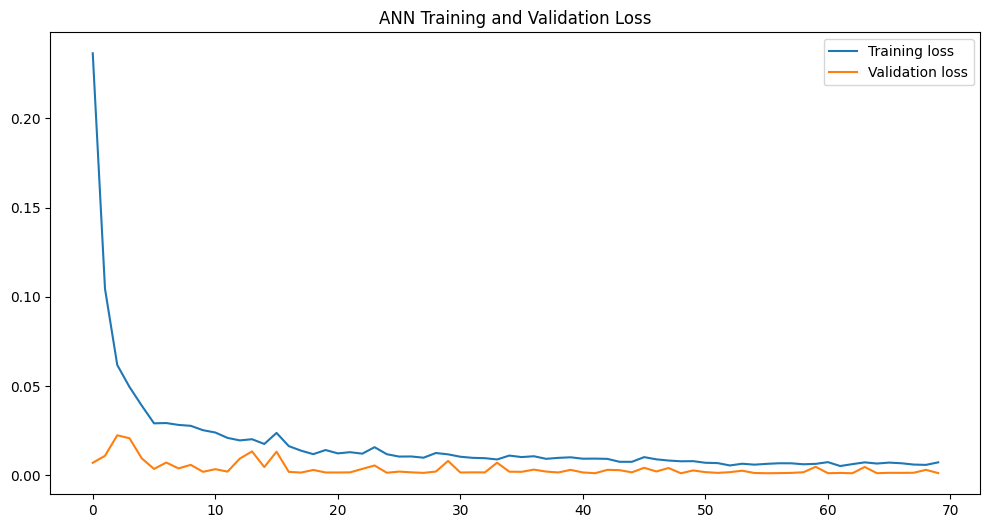

In [216]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [217]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [218]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 59.6508
RMSE: 7.7234
MAE: 4.4905
MAPE: 58.04%
R²: 0.8681


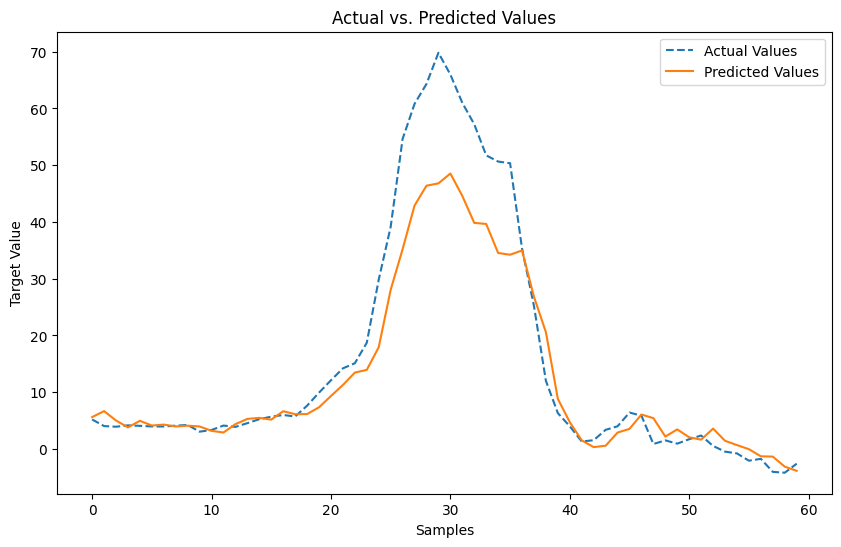

In [219]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 7

In [220]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [221]:

df=data.copy()
df = df.astype(float)


In [222]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [223]:
# Number of lags to create
lags = 7
lagged_features = create_lagged_features(df, lags)


In [224]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [225]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6

In [226]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7',
       'Month_lag_1', 'Month_lag_2', 'Month_lag_3', 'Month_lag_4',
       'Month_lag_5', 'Month_lag_6', 'Month_lag_7', 'Day_lag_1', 'Day_lag_2',
       'Day_lag_3', 'Day_lag_4', 'Day_lag_5', 'Day_lag_6', 'Day_lag_7',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7'],
      dtype='object')


In [227]:
df2=lagged_features.dropna()

In [228]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7        2000.0   

296

In [229]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Year_lag_5         0
Year_lag_6         0
Year_lag_7         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Month_lag_5        0
Month_lag_6        0
Month_lag_7        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Day_lag_5          0
Day_lag_6          0
Day_lag_7          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
Inflation_lag_5    0
Inflation_lag_6    0
Inflation_lag_7    0
dtype: int64

In [230]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [231]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7        2000.0      2000.0      2000.0  ...       31.0       28.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
..          ...         ...         ...  ...        ...        ...        ...   
298      2024.0      2024.0      2024.0  ...       30.0       31.0       30.0   
299      2024.0      2024.0      2024.0  ...       31.0       30.0       31.0   
300      2024.0      2024.0      2024.0  ...       31.0       31.0       30.0   
301      2024.0      2024.0      2024.0  ...       30.0       31.0       31.0   
302      2024.0      2024.0      2024.0  ...       31.0       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7          10.139831         6.799835         2.382412         3.672022   
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
..               ...              ...              ...              ...   
298        -0.783699        -0.469239         0.526039         2.365931   
299        -2.068252        -0.783699        -0.469239         0.526039   
300        -1.742696        -2.068252        -0.783699        -0.469239   
301        -4.035874        -1.742696        -2.068252        -0.783699   
302        -4.187438        -4.035874        -1.742696        -2.068252   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           4.469678         1.940367         0.329139  
8           3.672022         4.469678         1.940367  
9           2.382412         3.672022         4.469678  
10          6.799835         2.382412         3.672022  
11         10.139831         6.799835         2.382412  
..               ...              ...              ...  
298         1.716069         0.936037         1.508060  
299         2.365931         1.716069         0.936037  
300         0.526039         2.365931         1.716069  
301        -0.469239         0.526039         2.365931  
302        -0.783699        -0.469239         0.526039  

[296 rows x 32 columns]

In [232]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [233]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7        2000.0      2000.0      2000.0  ...       31.0       28.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
..          ...         ...         ...  ...        ...        ...        ...   
238      2019.0      2019.0      2019.0  ...       30.0       31.0       30.0   
239      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   
240      2019.0      2019.0      2019.0  ...       31.0       31.0       30.0   
241      2019.0      2019.0      2019.0  ...       30.0       31.0       31.0   
242      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7          10.139831         6.799835         2.382412         3.672022   
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
..               ...              ...              ...              ...   
238         5.377207         4.963971         3.418124         3.338633   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           4.469678         1.940367         0.329139  
8           3.672022         4.469678         1.940367  
9           2.382412         3.672022         4.469678  
10          6.799835         2.382412         3.672022  
11         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.827751         4.963385         4.526749  
239         3.338633         3.827751         4.963385  
240         3.418124         3.338633         3.827751  
241         4.963971         3.418124         3.338633  
242         5.377207         4.963971         3.418124  

[236 rows x 32 columns]

In [234]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [235]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
7    2000.0    8.0  31.0   9.876072      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
238  2019.0   11.0  30.0   4.358162      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7        2000.0      2000.0      2000.0  ...       31.0       28.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
..          ...         ...         ...  ...        ...        ...        ...   
238      2019.0      2019.0      2019.0  ...       30.0       31.0       30.0   
239      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   
240      2019.0      2019.0      2019.0  ...       31.0       31.0       30.0   
241      2019.0      2019.0      2019.0  ...       30.0       31.0       31.0   
242      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7          10.139831         6.799835         2.382412         3.672022   
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
..               ...              ...              ...              ...   
238         5.377207         4.963971         3.418124         3.338633   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           4.469678         1.940367         0.329139  
8           3.672022         4.469678         1.940367  
9           2.382412         3.672022         4.469678  
10          6.799835         2.382412         3.672022  
11         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.827751         4.963385         4.526749  
239         3.338633         3.827751         4.963385  
240         3.418124         3.338633         3.827751  
241         4.963971         3.418124         3.338633  
242         5.377207         4.963971         3.418124  

[236 rows x 32 columns]

In [236]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

243     5.196850
244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [237]:
from sklearn.preprocessing import MinMaxScaler

In [238]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7', 'Month_lag_1',
       'Month_lag_2', 'Month_lag_3', 'Month_lag_4', 'Month_lag_5',
       'Month_lag_6', 'Month_lag_7', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3',
       'Day_lag_4', 'Day_lag_5', 'Day_lag_6', 'Day_lag_7', 'Inflation_lag_1',
       'Inflation_lag_2', 'Inflation_lag_3', 'Inflation_lag_4',
       'Inflation_lag_5', 'Inflation_lag_6', 'Inflation_lag_7'],
      dtype='object')

In [239]:
ytrain

7       9.876072
8       8.455851
9       7.794494
10      7.559566
11     10.836729
         ...    
238     4.358162
239     4.829770
240     5.651491
241     6.151420
242     5.371248
Name: Inflation, Length: 236, dtype: float64

In [240]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [241]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [242]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
7    2000.0    8.0  31.0      2000.0      2000.0      2000.0      2000.0   
8    2000.0    9.0  30.0      2000.0      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0      2000.0      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0      2000.0      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0      2000.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
238  2019.0   11.0  30.0      2019.0      2019.0      2019.0      2019.0   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7        2000.0      2000.0      2000.0  ...       31.0       28.0       31.0   
8        2000.0      2000.0      2000.0  ...       30.0       31.0       28.0   
9        2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0       30.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0       31.0   
..          ...         ...         ...  ...        ...        ...        ...   
238      2019.0      2019.0      2019.0  ...       30.0       31.0       30.0   
239      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   
240      2019.0      2019.0      2019.0  ...       31.0       31.0       30.0   
241      2019.0      2019.0      2019.0  ...       30.0       31.0       31.0   
242      2019.0      2019.0      2019.0  ...       31.0       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7          10.139831         6.799835         2.382412         3.672022   
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
..               ...              ...              ...              ...   
238         5.377207         4.963971         3.418124         3.338633   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           4.469678         1.940367         0.329139  
8           3.672022         4.469678         1.940367  
9           2.382412         3.672022         4.469678  
10          6.799835         2.382412         3.672022  
11         10.139831         6.799835         2.382412  
..               ...              ...              ...  
238         3.827751         4.963385         4.526749  
239         3.338633         3.827751         4.963385  
240         3.418124         3.338633         3.827751  
241         4.963971         3.418124         3.338633  
242         5.377207         4.963971         3.418124  

[236 rows x 31 columns]

In [243]:
df1=pd.DataFrame(ytrain)

In [244]:
X_train_scaled

array([[0.        , 0.63636364, 1.        , ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.72727273, 0.66666667, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.81818182, 1.        , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.        , 1.        , ..., 0.09716944, 0.09427428,
        0.1254991 ],
       [1.        , 0.09090909, 0.        , ..., 0.15347105, 0.09716944,
        0.10795388],
       [1.        , 0.18181818, 1.        , ..., 0.1685216 , 0.15347105,
        0.11080532]])

In [245]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [246]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
10   0.00  0.909091  0.666667        0.00        0.00         0.0         0.0   
11   0.00  1.000000  1.000000        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7           0.0         0.0         0.0  ...   1.000000   0.000000   1.000000   
8           0.0         0.0         0.0  ...   0.666667   1.000000   0.000000   
9           0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   0.666667   
11          0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...        ...   
238         1.0         1.0         1.0  ...   0.666667   1.000000   0.666667   
239         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   
240         1.0         1.0         1.0  ...   1.000000   1.000000   0.666667   
241         1.0         1.0         1.0  ...   0.666667   1.000000   1.000000   
242         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7           0.341982         0.220335         0.059448         0.106417   
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
..               ...              ...              ...              ...   
238         0.168522         0.153471         0.097169         0.094274   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           0.135468         0.043348         0.000000  
8           0.106417         0.135468         0.057797  
9           0.059448         0.106417         0.148526  
10          0.220335         0.059448         0.119913  
11          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.112089         0.153450         0.150573  
239         0.094274         0.112089         0.166236  
240         0.097169         0.094274         0.125499  
241         0.153471         0.097169         0.107954  
242         0.168522         0.153471         0.110805  

[236 rows x 31 columns]

In [247]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [248]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
7     9.876072  0.00  0.636364  1.000000        0.00        0.00         0.0   
8     8.455851  0.00  0.727273  0.666667        0.00        0.00         0.0   
9     7.794494  0.00  0.818182  1.000000        0.00        0.00         0.0   
10    7.559566  0.00  0.909091  0.666667        0.00        0.00         0.0   
11   10.836729  0.00  1.000000  1.000000        0.00        0.00         0.0   
..         ...   ...       ...       ...         ...         ...         ...   
238   4.358162  0.95  0.909091  0.666667        0.95        0.95         1.0   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95         1.0   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95         1.0   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95         1.0   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00         1.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7           0.0         0.0         0.0  ...   1.000000   0.000000   1.000000   
8           0.0         0.0         0.0  ...   0.666667   1.000000   0.000000   
9           0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   0.666667   
11          0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...        ...   
238         1.0         1.0         1.0  ...   0.666667   1.000000   0.666667   
239         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   
240         1.0         1.0         1.0  ...   1.000000   1.000000   0.666667   
241         1.0         1.0         1.0  ...   0.666667   1.000000   1.000000   
242         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7           0.341982         0.220335         0.059448         0.106417   
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
..               ...              ...              ...              ...   
238         0.168522         0.153471         0.097169         0.094274   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           0.135468         0.043348         0.000000  
8           0.106417         0.135468         0.057797  
9           0.059448         0.106417         0.148526  
10          0.220335         0.059448         0.119913  
11          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.112089         0.153450         0.150573  
239         0.094274         0.112089         0.166236  
240         0.097169         0.094274         0.125499  
241         0.153471         0.097169         0.107954  
242         0.168522         0.153471         0.110805  

[236 rows x 32 columns]

In [249]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
7    0.00  0.636364  1.000000        0.00        0.00         0.0         0.0   
8    0.00  0.727273  0.666667        0.00        0.00         0.0         0.0   
9    0.00  0.818182  1.000000        0.00        0.00         0.0         0.0   
10   0.00  0.909091  0.666667        0.00        0.00         0.0         0.0   
11   0.00  1.000000  1.000000        0.00        0.00         0.0         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
238  0.95  0.909091  0.666667        0.95        0.95         1.0         1.0   
239  0.95  1.000000  1.000000        0.95        0.95         1.0         1.0   
240  1.00  0.000000  1.000000        0.95        0.95         1.0         1.0   
241  1.00  0.090909  0.000000        1.00        0.95         1.0         1.0   
242  1.00  0.181818  1.000000        1.00        1.00         1.0         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_5  Day_lag_6  Day_lag_7  \
7           0.0         0.0         0.0  ...   1.000000   0.000000   1.000000   
8           0.0         0.0         0.0  ...   0.666667   1.000000   0.000000   
9           0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   0.666667   
11          0.0         0.0         0.0  ...   1.000000   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...        ...   
238         1.0         1.0         1.0  ...   0.666667   1.000000   0.666667   
239         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   
240         1.0         1.0         1.0  ...   1.000000   1.000000   0.666667   
241         1.0         1.0         1.0  ...   0.666667   1.000000   1.000000   
242         1.0         1.0         1.0  ...   1.000000   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
7           0.341982         0.220335         0.059448         0.106417   
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
..               ...              ...              ...              ...   
238         0.168522         0.153471         0.097169         0.094274   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  
7           0.135468         0.043348         0.000000  
8           0.106417         0.135468         0.057797  
9           0.059448         0.106417         0.148526  
10          0.220335         0.059448         0.119913  
11          0.341982         0.220335         0.073653  
..               ...              ...              ...  
238         0.112089         0.153450         0.150573  
239         0.094274         0.112089         0.166236  
240         0.097169         0.094274         0.125499  
241         0.153471         0.097169         0.107954  
242         0.168522         0.153471         0.110805  

[236 rows x 31 columns]

In [250]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 06:41:56,082] A new study created in memory with name: no-name-d370a3e5-9ae8-4cfd-851d-c5ee67d19f1e
[I 2025-05-29 06:42:03,709] Trial 0 finished with value: 0.030059197917580605 and parameters: {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.24508988207975618, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 0.030059197917580605.
[I 2025-05-29 06:42:20,294] Trial 1 finished with value: 0.03250022642314434 and parameters: {'input_units': 112, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.30014446377321746, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 30}. Best is trial 0 with value: 0.030059197917580605.
[I 2025-05-29 06:42:51,114] Trial 2 finished with value: 0.04508206658065319 and parameters: {'input_units': 80, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.45638997496145584, 'n_units_1': 16, 'dropout_rate_1': 0.0539

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.11875983176512271, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.11875983176512271, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 70}
Epoch 1/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1653 - mae: 0.3342 - val_loss: 0.0579 - val_mae: 0.2215
Epoch 2/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0568 - mae: 0.1885 - val_loss: 0.0059 - val_mae: 0.0621
Epoch 3/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0332 - mae: 0.1410 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 4/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0302 - mae: 0.1345 - val_loss: 0.0024 - val_mae: 0.0391
Epoch 5/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mae: 0.1261 - val_loss: 0.0038 - val_mae: 0.0508
Epoch 6/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mae: 0.1247 - val_loss: 0.0420 - val_mae: 0.2015
Epoch 7/70
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0342 - mae: 0.1473 - val_loss: 0.0527 - val_m

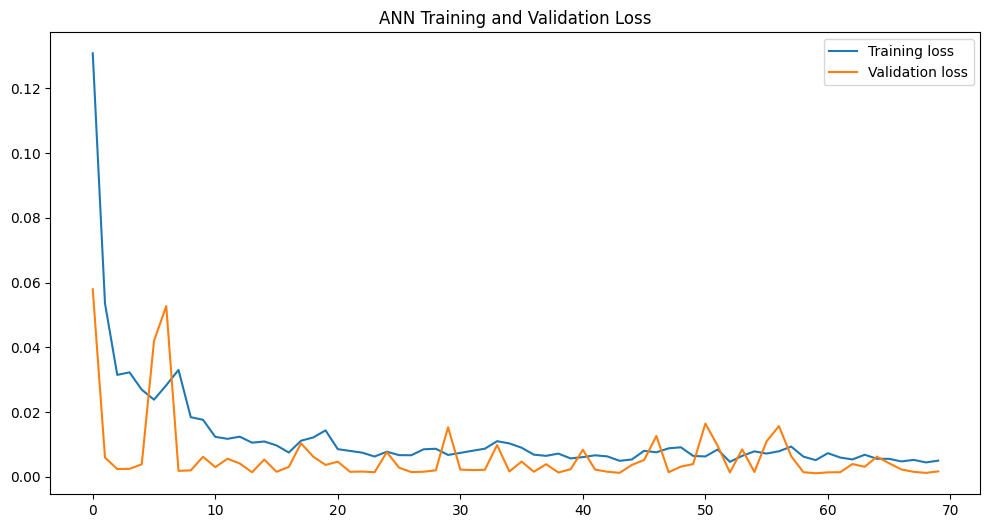

In [251]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [252]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [253]:
len(test_predictions)

60

In [254]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 61.5463
RMSE: 7.8451
MAE: 4.7649
MAPE: 61.86%
R²: 0.8639


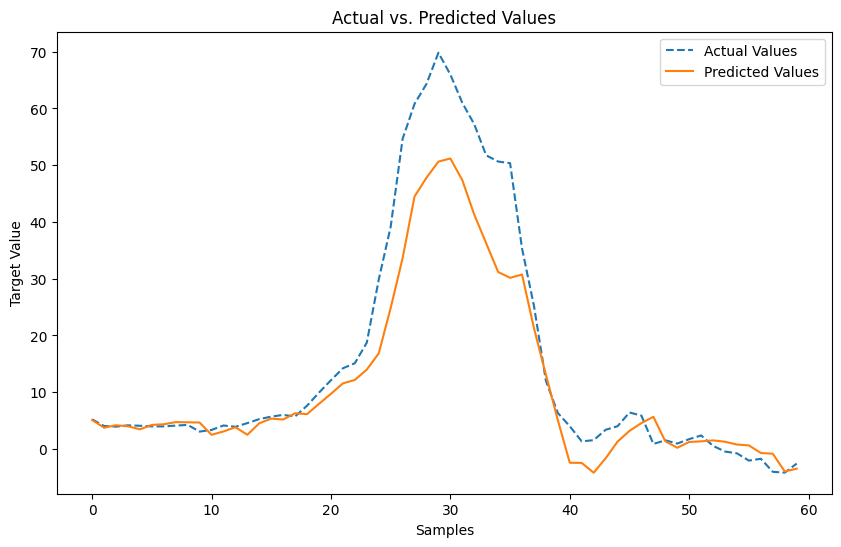

In [255]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 8

In [256]:
data

Year  Month  Day  Inflation
0    2000      1   31   0.329139
1    2000      2   28   1.940367
2    2000      3   31   4.469678
3    2000      4   30   3.672022
4    2000      5   31   2.382412
..    ...    ...  ...        ...
298  2024     11   30  -2.068252
299  2024     12   31  -1.742696
300  2025      1   31  -4.035874
301  2025      2   28  -4.187438
302  2025      3   31  -2.592781

[303 rows x 4 columns]

In [257]:

df=data.copy()
df = df.astype(float)


In [258]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [259]:
# Number of lags to create
lags = 8
lagged_features = create_lagged_features(df, lags)


In [260]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [261]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8

In [262]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7',
       'Year_lag_8', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Month_lag_5', 'Month_lag_6', 'Month_lag_7',
       'Month_lag_8', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4',
       'Day_lag_5', 'Day_lag_6', 'Day_lag_7', 'Day_lag_8', 'Inflation_lag_1',
       'Inflation_lag_2', 'Inflation_lag_3', 'Inflation_lag_4',
       'Inflation_lag_5', 'Inflation_lag_6', 'Inflation_lag_7',
       'Inflation_lag_8'],
      dtype='object')


In [263]:
df2=lagged_features.dropna()

In [264]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8  \
8        2000.0      2000.0  

295

In [265]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Year_lag_5         0
Year_lag_6         0
Year_lag_7         0
Year_lag_8         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Month_lag_5        0
Month_lag_6        0
Month_lag_7        0
Month_lag_8        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Day_lag_5          0
Day_lag_6          0
Day_lag_7          0
Day_lag_8          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
Inflation_lag_5    0
Inflation_lag_6    0
Inflation_lag_7    0
Inflation_lag_8    0
dtype: int64

In [266]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [267]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8  \
8        2000.0      2000.0      2000.0  ...       28.0       31.0   
9        2000.0      2000.0      2000.0  ...       31.0       28.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0   
12       2000.0      2000.0      2000.0  ...       30.0       31.0   
..          ...         ...         ...  ...        ...        ...   
298      2024.0      2024.0      2024.0  ...       30.0       31.0   
299      2024.0      2024.0      2024.0  ...       31.0       30.0   
300      2024.0      2024.0      2024.0  ...       30.0       31.0   
301      2024.0      2024.0      2024.0  ...       31.0       30.0   
302      2024.0      2024.0      2024.0  ...       31.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
12         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
298        -0.783699        -0.469239         0.526039         2.365931   
299        -2.068252        -0.783699        -0.469239         0.526039   
300        -1.742696        -2.068252        -0.783699        -0.469239   
301        -4.035874        -1.742696        -2.068252        -0.783699   
302        -4.187438        -4.035874        -1.742696        -2.068252   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           3.672022         4.469678         1.940367         0.329139  
9           2.382412         3.672022         4.469678         1.940367  
10          6.799835         2.382412         3.672022         4.469678  
11         10.139831         6.799835         2.382412         3.672022  
12          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
298         1.716069         0.936037         1.508060         0.871795  
299         2.365931         1.716069         0.936037         1.508060  
300         0.526039         2.365931         1.716069         0.936037  
301        -0.469239         0.526039         2.365931         1.716069  
302        -0.783699        -0.469239         0.526039         2.365931  

[295 rows x 36 columns]

In [268]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [269]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8  \
8        2000.0      2000.0      2000.0  ...       28.0       31.0   
9        2000.0      2000.0      2000.0  ...       31.0       28.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0   
12       2000.0      2000.0      2000.0  ...       30.0       31.0   
..          ...         ...         ...  ...        ...        ...   
239      2019.0      2019.0      2019.0  ...       31.0       30.0   
240      2019.0      2019.0      2019.0  ...       30.0       31.0   
241      2019.0      2019.0      2019.0  ...       31.0       30.0   
242      2019.0      2019.0      2019.0  ...       31.0       31.0   
243      2019.0      2019.0      2019.0  ...       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
12         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   
243         5.371248         6.151420         5.651491         4.829770   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           3.672022         4.469678         1.940367         0.329139  
9           2.382412         3.672022         4.469678         1.940367  
10          6.799835         2.382412         3.672022         4.469678  
11         10.139831         6.799835         2.382412         3.672022  
12          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.338633         3.827751         4.963385         4.526749  
240         3.418124         3.338633         3.827751         4.963385  
241         4.963971         3.418124         3.338633         3.827751  
242         5.377207         4.963971         3.418124         3.338633  
243         4.358162         5.377207         4.963971         3.418124  

[236 rows x 36 columns]

In [270]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [271]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
8    2000.0    9.0  30.0   8.455851      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8  \
8        2000.0      2000.0      2000.0  ...       28.0       31.0   
9        2000.0      2000.0      2000.0  ...       31.0       28.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0   
12       2000.0      2000.0      2000.0  ...       30.0       31.0   
..          ...         ...         ...  ...        ...        ...   
239      2019.0      2019.0      2019.0  ...       31.0       30.0   
240      2019.0      2019.0      2019.0  ...       30.0       31.0   
241      2019.0      2019.0      2019.0  ...       31.0       30.0   
242      2019.0      2019.0      2019.0  ...       31.0       31.0   
243      2019.0      2019.0      2019.0  ...       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
12         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   
243         5.371248         6.151420         5.651491         4.829770   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           3.672022         4.469678         1.940367         0.329139  
9           2.382412         3.672022         4.469678         1.940367  
10          6.799835         2.382412         3.672022         4.469678  
11         10.139831         6.799835         2.382412         3.672022  
12          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.338633         3.827751         4.963385         4.526749  
240         3.418124         3.338633         3.827751         4.963385  
241         4.963971         3.418124         3.338633         3.827751  
242         5.377207         4.963971         3.418124         3.338633  
243         4.358162         5.377207         4.963971         3.418124  

[236 rows x 36 columns]

In [272]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [273]:
from sklearn.preprocessing import MinMaxScaler

In [274]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7', 'Year_lag_8',
       'Month_lag_1', 'Month_lag_2', 'Month_lag_3', 'Month_lag_4',
       'Month_lag_5', 'Month_lag_6', 'Month_lag_7', 'Month_lag_8', 'Day_lag_1',
       'Day_lag_2', 'Day_lag_3', 'Day_lag_4', 'Day_lag_5', 'Day_lag_6',
       'Day_lag_7', 'Day_lag_8', 'Inflation_lag_1', 'Inflation_lag_2',
       'Inflation_lag_3', 'Inflation_lag_4', 'Inflation_lag_5',
       'Inflation_lag_6', 'Inflation_lag_7', 'Inflation_lag_8'],
      dtype='object')

In [275]:
ytrain

8       8.455851
9       7.794494
10      7.559566
11     10.836729
12     16.170425
         ...    
239     4.829770
240     5.651491
241     6.151420
242     5.371248
243     5.196850
Name: Inflation, Length: 236, dtype: float64

In [276]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [277]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [278]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
8    2000.0    9.0  30.0      2000.0      2000.0      2000.0      2000.0   
9    2000.0   10.0  31.0      2000.0      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0      2000.0      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0      2000.0      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0      2000.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   
243  2020.0    4.0  30.0      2020.0      2020.0      2020.0      2019.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_7  Day_lag_8  \
8        2000.0      2000.0      2000.0  ...       28.0       31.0   
9        2000.0      2000.0      2000.0  ...       31.0       28.0   
10       2000.0      2000.0      2000.0  ...       30.0       31.0   
11       2000.0      2000.0      2000.0  ...       31.0       30.0   
12       2000.0      2000.0      2000.0  ...       30.0       31.0   
..          ...         ...         ...  ...        ...        ...   
239      2019.0      2019.0      2019.0  ...       31.0       30.0   
240      2019.0      2019.0      2019.0  ...       30.0       31.0   
241      2019.0      2019.0      2019.0  ...       31.0       30.0   
242      2019.0      2019.0      2019.0  ...       31.0       31.0   
243      2019.0      2019.0      2019.0  ...       30.0       31.0   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           9.876072        10.139831         6.799835         2.382412   
9           8.455851         9.876072        10.139831         6.799835   
10          7.794494         8.455851         9.876072        10.139831   
11          7.559566         7.794494         8.455851         9.876072   
12         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         4.358162         5.377207         4.963971         3.418124   
240         4.829770         4.358162         5.377207         4.963971   
241         5.651491         4.829770         4.358162         5.377207   
242         6.151420         5.651491         4.829770         4.358162   
243         5.371248         6.151420         5.651491         4.829770   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           3.672022         4.469678         1.940367         0.329139  
9           2.382412         3.672022         4.469678         1.940367  
10          6.799835         2.382412         3.672022         4.469678  
11         10.139831         6.799835         2.382412         3.672022  
12          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.338633         3.827751         4.963385         4.526749  
240         3.418124         3.338633         3.827751         4.963385  
241         4.963971         3.418124         3.338633         3.827751  
242         5.377207         4.963971         3.418124         3.338633  
243         4.358162         5.377207         4.963971         3.418124  

[236 rows x 35 columns]

In [279]:
df1=pd.DataFrame(ytrain)

In [280]:
X_train_scaled

array([[0.        , 0.72727273, 0.66666667, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.81818182, 1.        , ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 0.90909091, 0.66666667, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.09090909, 0.        , ..., 0.09716944, 0.09427428,
        0.1254991 ],
       [1.        , 0.18181818, 1.        , ..., 0.15347105, 0.09716944,
        0.10795388],
       [1.        , 0.27272727, 0.66666667, ..., 0.1685216 , 0.15347105,
        0.11080532]])

In [281]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [282]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
8    0.00  0.727273  0.666667        0.00        0.00        0.00         0.0   
9    0.00  0.818182  1.000000        0.00        0.00        0.00         0.0   
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_7  Day_lag_8  \
8           0.0         0.0         0.0  ...   0.000000   1.000000   
9           0.0         0.0         0.0  ...   1.000000   0.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   
11          0.0         0.0         0.0  ...   1.000000   0.666667   
12          0.0         0.0         0.0  ...   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...   
239         1.0         1.0         1.0  ...   1.000000   0.666667   
240         1.0         1.0         1.0  ...   0.666667   1.000000   
241         1.0         1.0         1.0  ...   1.000000   0.666667   
242         1.0         1.0         1.0  ...   1.000000   1.000000   
243         1.0         1.0         1.0  ...   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
12          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   
243         0.168305         0.196719         0.178511         0.148583   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           0.106417         0.135468         0.043348         0.000000  
9           0.059448         0.106417         0.135468         0.057797  
10          0.220335         0.059448         0.106417         0.148526  
11          0.341982         0.220335         0.059448         0.119913  
12          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.094274         0.112089         0.153450         0.150573  
240         0.097169         0.094274         0.112089         0.166236  
241         0.153471         0.097169         0.094274         0.125499  
242         0.168522         0.153471         0.097169         0.107954  
243         0.131407         0.168522         0.153471         0.110805  

[236 rows x 35 columns]

In [283]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [284]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
8     8.455851  0.00  0.727273  0.666667        0.00        0.00        0.00   
9     7.794494  0.00  0.818182  1.000000        0.00        0.00        0.00   
10    7.559566  0.00  0.909091  0.666667        0.00        0.00        0.00   
11   10.836729  0.00  1.000000  1.000000        0.00        0.00        0.00   
12   16.170425  0.05  0.000000  1.000000        0.00        0.00        0.00   
..         ...   ...       ...       ...         ...         ...         ...   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95        0.95   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95        0.95   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95        0.95   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00        0.95   
243   5.196850  1.00  0.272727  0.666667        1.00        1.00        1.00   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_7  Day_lag_8  \
8           0.0         0.0         0.0  ...   0.000000   1.000000   
9           0.0         0.0         0.0  ...   1.000000   0.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   
11          0.0         0.0         0.0  ...   1.000000   0.666667   
12          0.0         0.0         0.0  ...   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...   
239         1.0         1.0         1.0  ...   1.000000   0.666667   
240         1.0         1.0         1.0  ...   0.666667   1.000000   
241         1.0         1.0         1.0  ...   1.000000   0.666667   
242         1.0         1.0         1.0  ...   1.000000   1.000000   
243         1.0         1.0         1.0  ...   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
12          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   
243         0.168305         0.196719         0.178511         0.148583   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           0.106417         0.135468         0.043348         0.000000  
9           0.059448         0.106417         0.135468         0.057797  
10          0.220335         0.059448         0.106417         0.148526  
11          0.341982         0.220335         0.059448         0.119913  
12          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.094274         0.112089         0.153450         0.150573  
240         0.097169         0.094274         0.112089         0.166236  
241         0.153471         0.097169         0.094274         0.125499  
242         0.168522         0.153471         0.097169         0.107954  
243         0.131407         0.168522         0.153471         0.110805  

[236 rows x 36 columns]

In [285]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
8    0.00  0.727273  0.666667        0.00        0.00        0.00         0.0   
9    0.00  0.818182  1.000000        0.00        0.00        0.00         0.0   
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_7  Day_lag_8  \
8           0.0         0.0         0.0  ...   0.000000   1.000000   
9           0.0         0.0         0.0  ...   1.000000   0.000000   
10          0.0         0.0         0.0  ...   0.666667   1.000000   
11          0.0         0.0         0.0  ...   1.000000   0.666667   
12          0.0         0.0         0.0  ...   0.666667   1.000000   
..          ...         ...         ...  ...        ...        ...   
239         1.0         1.0         1.0  ...   1.000000   0.666667   
240         1.0         1.0         1.0  ...   0.666667   1.000000   
241         1.0         1.0         1.0  ...   1.000000   0.666667   
242         1.0         1.0         1.0  ...   1.000000   1.000000   
243         1.0         1.0         1.0  ...   0.666667   1.000000   

     Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  \
8           0.332376         0.341982         0.220335         0.059448   
9           0.280650         0.332376         0.341982         0.220335   
10          0.256562         0.280650         0.332376         0.341982   
11          0.248006         0.256562         0.280650         0.332376   
12          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.131407         0.168522         0.153471         0.097169   
240         0.148583         0.131407         0.168522         0.153471   
241         0.178511         0.148583         0.131407         0.168522   
242         0.196719         0.178511         0.148583         0.131407   
243         0.168305         0.196719         0.178511         0.148583   

     Inflation_lag_5  Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  
8           0.106417         0.135468         0.043348         0.000000  
9           0.059448         0.106417         0.135468         0.057797  
10          0.220335         0.059448         0.106417         0.148526  
11          0.341982         0.220335         0.059448         0.119913  
12          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.094274         0.112089         0.153450         0.150573  
240         0.097169         0.094274         0.112089         0.166236  
241         0.153471         0.097169         0.094274         0.125499  
242         0.168522         0.153471         0.097169         0.107954  
243         0.131407         0.168522         0.153471         0.110805  

[236 rows x 35 columns]

In [286]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 07:10:35,733] A new study created in memory with name: no-name-19c648bc-7438-4ec3-a1f6-8735b7496420
[I 2025-05-29 07:11:23,383] Trial 0 finished with value: 0.030734738009050487 and parameters: {'input_units': 64, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.03907678931223041, 'n_units_1': 128, 'dropout_rate_1': 0.46803466019769907, 'n_units_2': 16, 'dropout_rate_2': 0.09921464560187443, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.030734738009050487.
[I 2025-05-29 07:11:51,693] Trial 1 finished with value: 0.027668858459219337 and parameters: {'input_units': 48, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.1445342780017581, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 50}. Best is trial 1 with value: 0.027668858459219337.
[I 2025-05-29 07:12:06,716] Trial 2 finished with value: 0.02580236312933266 and parameters: {'input_units': 64, 'activation': 'relu', 'num_l

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.20314092997274102, 'n_units_1': 16, 'dropout_rate_1': 0.433462539860236, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 100}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.20314092997274102, 'n_units_1': 16, 'dropout_rate_1': 0.433462539860236, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 100}
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.3517 - mae: 0.4798 - val_loss: 0.0622 - val_mae: 0.2302
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2211 - mae: 0.3747 - val_loss: 0.0302 - val_mae: 0.1577
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2095 - mae: 0.3767 - val_loss: 0.0252 - val_mae: 0.1442
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1449 - mae: 0.2944 - val_loss: 0.0057 - val_mae: 0.0591
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1249 - mae: 0.2813 - val_loss: 0.0024 - val_mae: 0.0396
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0886 - mae: 0.2387 - val_loss: 0.0035 - val_mae: 0.0524
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss:

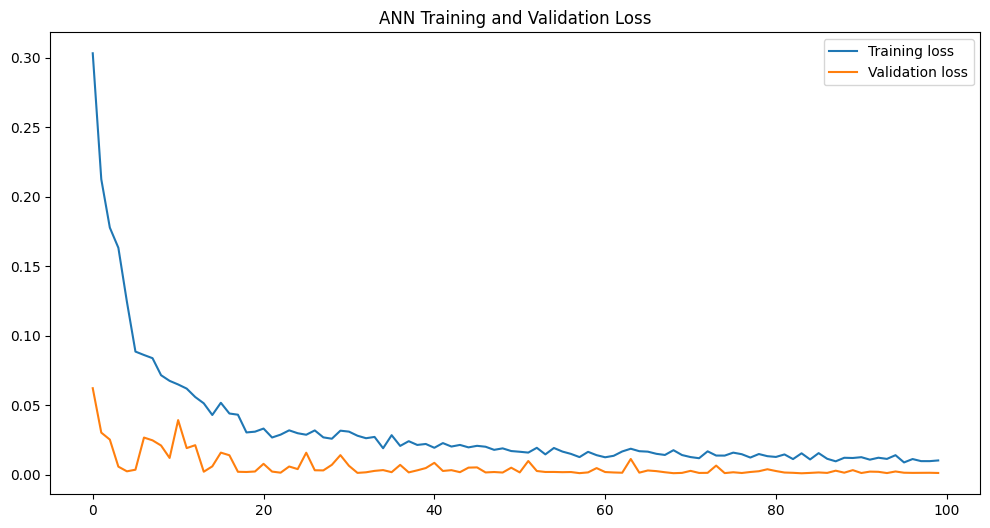

In [287]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [288]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [289]:
len(test_predictions)

60

In [290]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 86.1565
RMSE: 9.2821
MAE: 5.4707
MAPE: 56.62%
R²: 0.8120


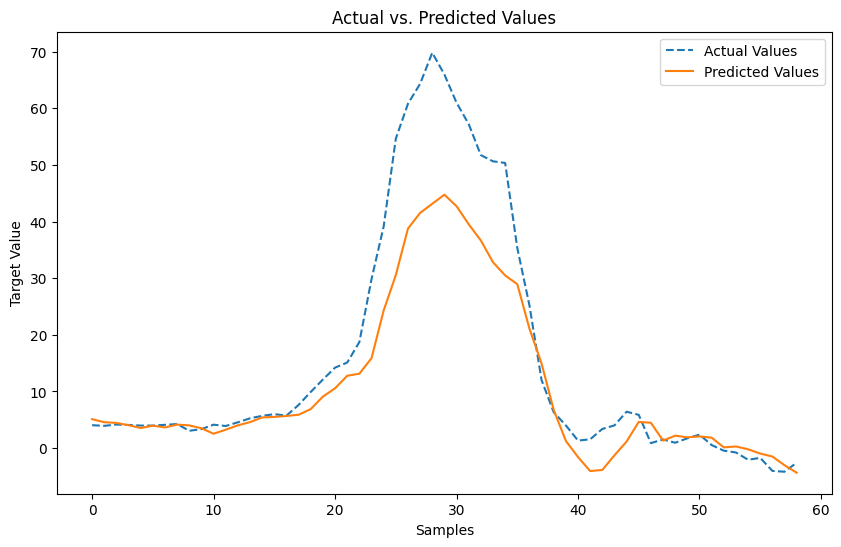

In [291]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 9

In [292]:

df=data.copy()
df = df.astype(float)


In [293]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [294]:
# Number of lags to create
lags = 9
lagged_features = create_lagged_features(df, lags)


In [295]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [296]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation

In [297]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7',
       'Year_lag_8', 'Year_lag_9', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Month_lag_5', 'Month_lag_6', 'Month_lag_7',
       'Month_lag_8', 'Month_lag_9', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3',
       'Day_lag_4', 'Day_lag_5', 'Day_lag_6', 'Day_lag_7', 'Day_lag_8',
       'Day_lag_9', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')


In [298]:
df2=lagged_features.dropna()

In [299]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation_lag_1  \
9        2000.0      20

294

In [300]:
df2.isnull().sum()

Year               0
Month              0
Day                0
Inflation          0
Year_lag_1         0
Year_lag_2         0
Year_lag_3         0
Year_lag_4         0
Year_lag_5         0
Year_lag_6         0
Year_lag_7         0
Year_lag_8         0
Year_lag_9         0
Month_lag_1        0
Month_lag_2        0
Month_lag_3        0
Month_lag_4        0
Month_lag_5        0
Month_lag_6        0
Month_lag_7        0
Month_lag_8        0
Month_lag_9        0
Day_lag_1          0
Day_lag_2          0
Day_lag_3          0
Day_lag_4          0
Day_lag_5          0
Day_lag_6          0
Day_lag_7          0
Day_lag_8          0
Day_lag_9          0
Inflation_lag_1    0
Inflation_lag_2    0
Inflation_lag_3    0
Inflation_lag_4    0
Inflation_lag_5    0
Inflation_lag_6    0
Inflation_lag_7    0
Inflation_lag_8    0
Inflation_lag_9    0
dtype: int64

In [301]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [302]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation_lag_1  \
9        2000.0      2000.0      2000.0  ...       31.0         8.455851   
10       2000.0      2000.0      2000.0  ...       28.0         7.794494   
11       2000.0      2000.0      2000.0  ...       31.0         7.559566   
12       2000.0      2000.0      2000.0  ...       30.0        10.836729   
13       2000.0      2000.0      2000.0  ...       31.0        16.170425   
..          ...         ...         ...  ...        ...              ...   
298      2024.0      2024.0      2024.0  ...       28.0        -0.783699   
299      2024.0      2024.0      2024.0  ...       31.0        -2.068252   
300      2024.0      2024.0      2024.0  ...       30.0        -1.742696   
301      2024.0      2024.0      2024.0  ...       31.0        -4.035874   
302      2024.0      2024.0      2024.0  ...       30.0        -4.187438   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           9.876072        10.139831         6.799835         2.382412   
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
298        -0.469239         0.526039         2.365931         1.716069   
299        -0.783699        -0.469239         0.526039         2.365931   
300        -2.068252        -0.783699        -0.469239         0.526039   
301        -1.742696        -2.068252        -0.783699        -0.469239   
302        -4.035874        -1.742696        -2.068252        -0.783699   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           3.672022         4.469678         1.940367         0.329139  
10          2.382412         3.672022         4.469678         1.940367  
11          6.799835         2.382412         3.672022         4.469678  
12         10.139831         6.799835         2.382412         3.672022  
13          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
298         0.936037         1.508060         0.871795         5.857520  
299         1.716069         0.936037         1.508060         0.871795  
300         2.365931         1.716069         0.936037         1.508060  
301         0.526039         2.365931         1.716069         0.936037  
302        -0.469239         0.526039         2.365931         1.716069  

[294 rows x 40 columns]

In [303]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [304]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation_lag_1  \
9        2000.0      2000.0      2000.0  ...       31.0         8.455851   
10       2000.0      2000.0      2000.0  ...       28.0         7.794494   
11       2000.0      2000.0      2000.0  ...       31.0         7.559566   
12       2000.0      2000.0      2000.0  ...       30.0        10.836729   
13       2000.0      2000.0      2000.0  ...       31.0        16.170425   
..          ...         ...         ...  ...        ...              ...   
239      2019.0      2019.0      2019.0  ...       31.0         4.358162   
240      2019.0      2019.0      2019.0  ...       30.0         4.829770   
241      2019.0      2019.0      2019.0  ...       31.0         5.651491   
242      2019.0      2019.0      2019.0  ...       30.0         6.151420   
243      2019.0      2019.0      2019.0  ...       31.0         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           9.876072        10.139831         6.799835         2.382412   
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           3.672022         4.469678         1.940367         0.329139  
10          2.382412         3.672022         4.469678         1.940367  
11          6.799835         2.382412         3.672022         4.469678  
12         10.139831         6.799835         2.382412         3.672022  
13          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.827751         4.963385         4.526749         4.283361  
240         3.338633         3.827751         4.963385         4.526749  
241         3.418124         3.338633         3.827751         4.963385  
242         4.963971         3.418124         3.338633         3.827751  
243         5.377207         4.963971         3.418124         3.338633  

[235 rows x 40 columns]

In [305]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [306]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
9    2000.0   10.0  31.0   7.794494      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation_lag_1  \
9        2000.0      2000.0      2000.0  ...       31.0         8.455851   
10       2000.0      2000.0      2000.0  ...       28.0         7.794494   
11       2000.0      2000.0      2000.0  ...       31.0         7.559566   
12       2000.0      2000.0      2000.0  ...       30.0        10.836729   
13       2000.0      2000.0      2000.0  ...       31.0        16.170425   
..          ...         ...         ...  ...        ...              ...   
239      2019.0      2019.0      2019.0  ...       31.0         4.358162   
240      2019.0      2019.0      2019.0  ...       30.0         4.829770   
241      2019.0      2019.0      2019.0  ...       31.0         5.651491   
242      2019.0      2019.0      2019.0  ...       30.0         6.151420   
243      2019.0      2019.0      2019.0  ...       31.0         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           9.876072        10.139831         6.799835         2.382412   
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           3.672022         4.469678         1.940367         0.329139  
10          2.382412         3.672022         4.469678         1.940367  
11          6.799835         2.382412         3.672022         4.469678  
12         10.139831         6.799835         2.382412         3.672022  
13          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.827751         4.963385         4.526749         4.283361  
240         3.338633         3.827751         4.963385         4.526749  
241         3.418124         3.338633         3.827751         4.963385  
242         4.963971         3.418124         3.338633         3.827751  
243         5.377207         4.963971         3.418124         3.338633  

[235 rows x 40 columns]

In [307]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [308]:
from sklearn.preprocessing import MinMaxScaler

In [309]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7', 'Year_lag_8',
       'Year_lag_9', 'Month_lag_1', 'Month_lag_2', 'Month_lag_3',
       'Month_lag_4', 'Month_lag_5', 'Month_lag_6', 'Month_lag_7',
       'Month_lag_8', 'Month_lag_9', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3',
       'Day_lag_4', 'Day_lag_5', 'Day_lag_6', 'Day_lag_7', 'Day_lag_8',
       'Day_lag_9', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9'],
      dtype='object')

In [310]:
ytrain

9       7.794494
10      7.559566
11     10.836729
12     16.170425
13     16.618124
         ...    
239     4.829770
240     5.651491
241     6.151420
242     5.371248
243     5.196850
Name: Inflation, Length: 235, dtype: float64

In [311]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [312]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [313]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
9    2000.0   10.0  31.0      2000.0      2000.0      2000.0      2000.0   
10   2000.0   11.0  30.0      2000.0      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0      2000.0      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0      2000.0      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0      2001.0      2000.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   
243  2020.0    4.0  30.0      2020.0      2020.0      2020.0      2019.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_9  Inflation_lag_1  \
9        2000.0      2000.0      2000.0  ...       31.0         8.455851   
10       2000.0      2000.0      2000.0  ...       28.0         7.794494   
11       2000.0      2000.0      2000.0  ...       31.0         7.559566   
12       2000.0      2000.0      2000.0  ...       30.0        10.836729   
13       2000.0      2000.0      2000.0  ...       31.0        16.170425   
..          ...         ...         ...  ...        ...              ...   
239      2019.0      2019.0      2019.0  ...       31.0         4.358162   
240      2019.0      2019.0      2019.0  ...       30.0         4.829770   
241      2019.0      2019.0      2019.0  ...       31.0         5.651491   
242      2019.0      2019.0      2019.0  ...       30.0         6.151420   
243      2019.0      2019.0      2019.0  ...       31.0         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           9.876072        10.139831         6.799835         2.382412   
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           3.672022         4.469678         1.940367         0.329139  
10          2.382412         3.672022         4.469678         1.940367  
11          6.799835         2.382412         3.672022         4.469678  
12         10.139831         6.799835         2.382412         3.672022  
13          9.876072        10.139831         6.799835         2.382412  
..               ...              ...              ...              ...  
239         3.827751         4.963385         4.526749         4.283361  
240         3.338633         3.827751         4.963385         4.526749  
241         3.418124         3.338633         3.827751         4.963385  
242         4.963971         3.418124         3.338633         3.827751  
243         5.377207         4.963971         3.418124         3.338633  

[235 rows x 39 columns]

In [314]:
df1=pd.DataFrame(ytrain)

In [315]:
X_train_scaled

array([[0.        , 0.81818182, 1.        , ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 0.90909091, 0.66666667, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.        , 1.        , 1.        , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.09090909, 0.        , ..., 0.09427428, 0.11208856,
        0.16623555],
       [1.        , 0.18181818, 1.        , ..., 0.09716944, 0.09427428,
        0.1254991 ],
       [1.        , 0.27272727, 0.66666667, ..., 0.15347105, 0.09716944,
        0.10795388]])

In [316]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [317]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
9    0.00  0.818182  1.000000        0.00        0.00        0.00         0.0   
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
13   0.05  0.090909  0.000000        0.05        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_9  Inflation_lag_1  \
9           0.0         0.0         0.0  ...   1.000000         0.280650   
10          0.0         0.0         0.0  ...   0.000000         0.256562   
11          0.0         0.0         0.0  ...   1.000000         0.248006   
12          0.0         0.0         0.0  ...   0.666667         0.367364   
13          0.0         0.0         0.0  ...   1.000000         0.561624   
..          ...         ...         ...  ...        ...              ...   
239         1.0         1.0         1.0  ...   1.000000         0.131407   
240         1.0         1.0         1.0  ...   0.666667         0.148583   
241         1.0         1.0         1.0  ...   1.000000         0.178511   
242         1.0         1.0         1.0  ...   0.666667         0.196719   
243         1.0         1.0         1.0  ...   1.000000         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           0.332376         0.341982         0.220335         0.059448   
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           0.106417         0.135468         0.043348         0.000000  
10          0.059448         0.106417         0.135468         0.057797  
11          0.220335         0.059448         0.106417         0.148526  
12          0.341982         0.220335         0.059448         0.119913  
13          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.112089         0.153450         0.137547         0.141842  
240         0.094274         0.112089         0.153450         0.150573  
241         0.097169         0.094274         0.112089         0.166236  
242         0.153471         0.097169         0.094274         0.125499  
243         0.168522         0.153471         0.097169         0.107954  

[235 rows x 39 columns]

In [318]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [319]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
9     7.794494  0.00  0.818182  1.000000        0.00        0.00        0.00   
10    7.559566  0.00  0.909091  0.666667        0.00        0.00        0.00   
11   10.836729  0.00  1.000000  1.000000        0.00        0.00        0.00   
12   16.170425  0.05  0.000000  1.000000        0.00        0.00        0.00   
13   16.618124  0.05  0.090909  0.000000        0.05        0.00        0.00   
..         ...   ...       ...       ...         ...         ...         ...   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95        0.95   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95        0.95   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95        0.95   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00        0.95   
243   5.196850  1.00  0.272727  0.666667        1.00        1.00        1.00   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Day_lag_9  Inflation_lag_1  \
9           0.0         0.0         0.0  ...   1.000000         0.280650   
10          0.0         0.0         0.0  ...   0.000000         0.256562   
11          0.0         0.0         0.0  ...   1.000000         0.248006   
12          0.0         0.0         0.0  ...   0.666667         0.367364   
13          0.0         0.0         0.0  ...   1.000000         0.561624   
..          ...         ...         ...  ...        ...              ...   
239         1.0         1.0         1.0  ...   1.000000         0.131407   
240         1.0         1.0         1.0  ...   0.666667         0.148583   
241         1.0         1.0         1.0  ...   1.000000         0.178511   
242         1.0         1.0         1.0  ...   0.666667         0.196719   
243         1.0         1.0         1.0  ...   1.000000         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           0.332376         0.341982         0.220335         0.059448   
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           0.106417         0.135468         0.043348         0.000000  
10          0.059448         0.106417         0.135468         0.057797  
11          0.220335         0.059448         0.106417         0.148526  
12          0.341982         0.220335         0.059448         0.119913  
13          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.112089         0.153450         0.137547         0.141842  
240         0.094274         0.112089         0.153450         0.150573  
241         0.097169         0.094274         0.112089         0.166236  
242         0.153471         0.097169         0.094274         0.125499  
243         0.168522         0.153471         0.097169         0.107954  

[235 rows x 40 columns]

In [320]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
9    0.00  0.818182  1.000000        0.00        0.00        0.00         0.0   
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
13   0.05  0.090909  0.000000        0.05        0.00        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Day_lag_9  Inflation_lag_1  \
9           0.0         0.0         0.0  ...   1.000000         0.280650   
10          0.0         0.0         0.0  ...   0.000000         0.256562   
11          0.0         0.0         0.0  ...   1.000000         0.248006   
12          0.0         0.0         0.0  ...   0.666667         0.367364   
13          0.0         0.0         0.0  ...   1.000000         0.561624   
..          ...         ...         ...  ...        ...              ...   
239         1.0         1.0         1.0  ...   1.000000         0.131407   
240         1.0         1.0         1.0  ...   0.666667         0.148583   
241         1.0         1.0         1.0  ...   1.000000         0.178511   
242         1.0         1.0         1.0  ...   0.666667         0.196719   
243         1.0         1.0         1.0  ...   1.000000         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
9           0.332376         0.341982         0.220335         0.059448   
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  
9           0.106417         0.135468         0.043348         0.000000  
10          0.059448         0.106417         0.135468         0.057797  
11          0.220335         0.059448         0.106417         0.148526  
12          0.341982         0.220335         0.059448         0.119913  
13          0.332376         0.341982         0.220335         0.073653  
..               ...              ...              ...              ...  
239         0.112089         0.153450         0.137547         0.141842  
240         0.094274         0.112089         0.153450         0.150573  
241         0.097169         0.094274         0.112089         0.166236  
242         0.153471         0.097169         0.094274         0.125499  
243         0.168522         0.153471         0.097169         0.107954  

[235 rows x 39 columns]

In [321]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 07:43:41,325] A new study created in memory with name: no-name-2c5631f6-ea41-4d6e-ad3b-1be36ed5b337
[I 2025-05-29 07:44:26,464] Trial 0 finished with value: 0.04496318940073252 and parameters: {'input_units': 96, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.458695172863492, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 90}. Best is trial 0 with value: 0.04496318940073252.
[I 2025-05-29 07:44:31,827] Trial 1 finished with value: 0.05155138000845909 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 64, 'dropout_rate_0': 0.48879332127196257, 'n_units_1': 80, 'dropout_rate_1': 0.2552709582715774, 'n_units_2': 32, 'dropout_rate_2': 0.22259306962633235, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.04496318940073252.
[I 2025-05-29 07:45:00,402] Trial 2 finished with value: 0.019635526370257138 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 1,

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.39851083007231813, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 40}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.39851083007231813, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 40}
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.5203 - mae: 0.5640 - val_loss: 0.2768 - val_mae: 0.4849
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3465 - mae: 0.4835 - val_loss: 0.0596 - val_mae: 0.1793
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4049 - mae: 0.5047 - val_loss: 0.0539 - val_mae: 0.2003
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2796 - mae: 0.4300 - val_loss: 0.0489 - val_mae: 0.1938
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1933 - mae: 0.3477 - val_loss: 0.0544 - val_mae: 0.2065
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1548 - mae: 0.3228 - val_loss: 0.0144 - val_mae: 0.0905
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1526 - mae: 0.3120 - val_loss: 0.0136 - val_mae: 0.0896
Epoc

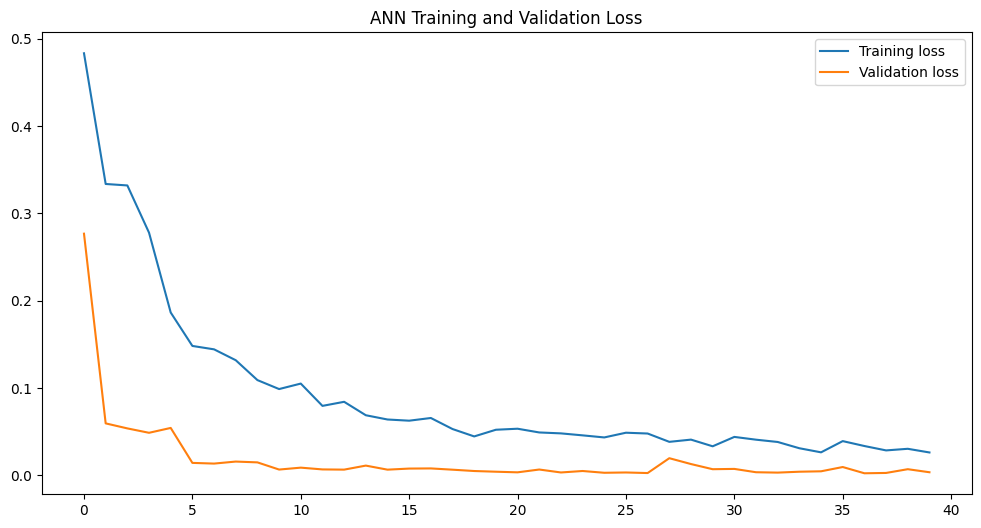

In [322]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [323]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [324]:
len(test_predictions)

59

In [325]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 92.9920
RMSE: 9.6432
MAE: 5.9177
MAPE: 87.22%
R²: 0.7970


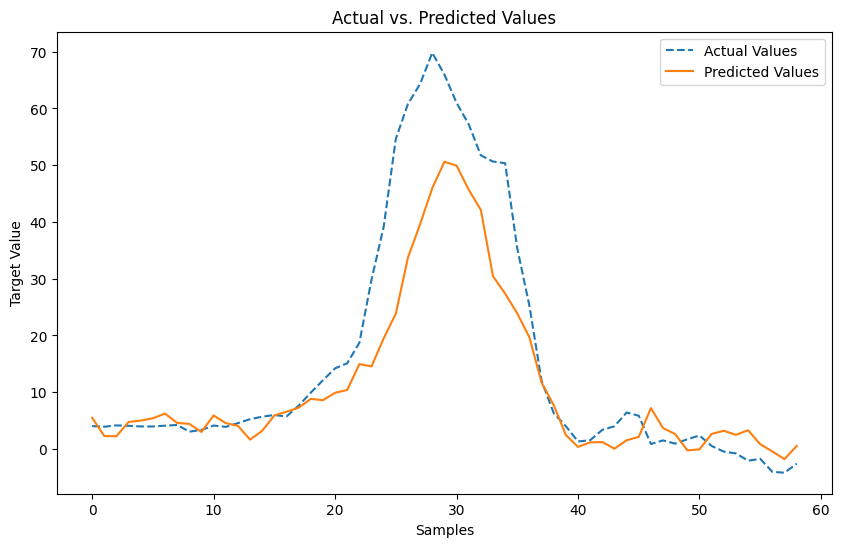

In [326]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 10

In [327]:

df=data.copy()
df = df.astype(float)


In [328]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [329]:
# Number of lags to create
lags = 10
lagged_features = create_lagged_features(df, lags)


In [330]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [331]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
0

In [332]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7',
       'Year_lag_8', 'Year_lag_9', 'Year_lag_10', 'Month_lag_1', 'Month_lag_2',
       'Month_lag_3', 'Month_lag_4', 'Month_lag_5', 'Month_lag_6',
       'Month_lag_7', 'Month_lag_8', 'Month_lag_9', 'Month_lag_10',
       'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4', 'Day_lag_5',
       'Day_lag_6', 'Day_lag_7', 'Day_lag_8', 'Day_lag_9', 'Day_lag_10',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10'],
      dtype='object')


In [333]:
df2=lagged_features.dropna()

In [334]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
14   2001.0    3.0  31.0  13.213922      2001.0      2001.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
10       2000.0      2000.0      2

293

In [335]:
df2.isnull().sum()

Year                0
Month               0
Day                 0
Inflation           0
Year_lag_1          0
Year_lag_2          0
Year_lag_3          0
Year_lag_4          0
Year_lag_5          0
Year_lag_6          0
Year_lag_7          0
Year_lag_8          0
Year_lag_9          0
Year_lag_10         0
Month_lag_1         0
Month_lag_2         0
Month_lag_3         0
Month_lag_4         0
Month_lag_5         0
Month_lag_6         0
Month_lag_7         0
Month_lag_8         0
Month_lag_9         0
Month_lag_10        0
Day_lag_1           0
Day_lag_2           0
Day_lag_3           0
Day_lag_4           0
Day_lag_5           0
Day_lag_6           0
Day_lag_7           0
Day_lag_8           0
Day_lag_9           0
Day_lag_10          0
Inflation_lag_1     0
Inflation_lag_2     0
Inflation_lag_3     0
Inflation_lag_4     0
Inflation_lag_5     0
Inflation_lag_6     0
Inflation_lag_7     0
Inflation_lag_8     0
Inflation_lag_9     0
Inflation_lag_10    0
dtype: int64

In [336]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [337]:
df2

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
14   2001.0    3.0  31.0  13.213922      2001.0      2001.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
10       2000.0      2000.0      2000.0  ...         7.794494   
11       2000.0      2000.0      2000.0  ...         7.559566   
12       2000.0      2000.0      2000.0  ...        10.836729   
13       2000.0      2000.0      2000.0  ...        16.170425   
14       2000.0      2000.0      2000.0  ...        16.618124   
..          ...         ...         ...  ...              ...   
298      2024.0      2024.0      2024.0  ...        -0.783699   
299      2024.0      2024.0      2024.0  ...        -2.068252   
300      2024.0      2024.0      2024.0  ...        -1.742696   
301      2024.0      2024.0      2024.0  ...        -4.035874   
302      2024.0      2024.0      2024.0  ...        -4.187438   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
14         16.170425        10.836729         7.559566         7.794494   
..               ...              ...              ...              ...   
298        -0.469239         0.526039         2.365931         1.716069   
299        -0.783699        -0.469239         0.526039         2.365931   
300        -2.068252        -0.783699        -0.469239         0.526039   
301        -1.742696        -2.068252        -0.783699        -0.469239   
302        -4.035874        -1.742696        -2.068252        -0.783699   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          2.382412         3.672022         4.469678         1.940367   
11          6.799835         2.382412         3.672022         4.469678   
12         10.139831         6.799835         2.382412         3.672022   
13          9.876072        10.139831         6.799835         2.382412   
14          8.455851         9.876072        10.139831         6.799835   
..               ...              ...              ...              ...   
298         0.936037         1.508060         0.871795         5.857520   
299         1.716069         0.936037         1.508060         0.871795   
300         2.365931         1.716069         0.936037         1.508060   
301         0.526039         2.365931         1.716069         0.936037   
302        -0.469239         0.526039         2.365931         1.716069   

     Inflation_lag_10  
10           0.329139  
11           1.940367  
12           4.469678  
13           3.672022  
14           2.382412  
..                ...  
298          6.415695  
299          5.857520  
300          0.871795  
301          1.508060  
302          0.936037  

[293 rows x 44 columns]

In [338]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [339]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
14   2001.0    3.0  31.0  13.213922      2001.0      2001.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
10       2000.0      2000.0      2000.0  ...         7.794494   
11       2000.0      2000.0      2000.0  ...         7.559566   
12       2000.0      2000.0      2000.0  ...        10.836729   
13       2000.0      2000.0      2000.0  ...        16.170425   
14       2000.0      2000.0      2000.0  ...        16.618124   
..          ...         ...         ...  ...              ...   
239      2019.0      2019.0      2019.0  ...         4.358162   
240      2019.0      2019.0      2019.0  ...         4.829770   
241      2019.0      2019.0      2019.0  ...         5.651491   
242      2019.0      2019.0      2019.0  ...         6.151420   
243      2019.0      2019.0      2019.0  ...         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
14         16.170425        10.836729         7.559566         7.794494   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          2.382412         3.672022         4.469678         1.940367   
11          6.799835         2.382412         3.672022         4.469678   
12         10.139831         6.799835         2.382412         3.672022   
13          9.876072        10.139831         6.799835         2.382412   
14          8.455851         9.876072        10.139831         6.799835   
..               ...              ...              ...              ...   
239         3.827751         4.963385         4.526749         4.283361   
240         3.338633         3.827751         4.963385         4.526749   
241         3.418124         3.338633         3.827751         4.963385   
242         4.963971         3.418124         3.338633         3.827751   
243         5.377207         4.963971         3.418124         3.338633   

     Inflation_lag_10  
10           0.329139  
11           1.940367  
12           4.469678  
13           3.672022  
14           2.382412  
..                ...  
239          4.019688  
240          4.283361  
241          4.526749  
242          4.963385  
243          3.827751  

[234 rows x 44 columns]

In [340]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [341]:
train_data

Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
10   2000.0   11.0  30.0   7.559566      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
14   2001.0    3.0  31.0  13.213922      2001.0      2001.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
239  2019.0   12.0  31.0   4.829770      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0   5.651491      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0   6.151420      2020.0      2019.0      2019.0   
242  2020.0    3.0  31.0   5.371248      2020.0      2020.0      2019.0   
243  2020.0    4.0  30.0   5.196850      2020.0      2020.0      2020.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
10       2000.0      2000.0      2000.0  ...         7.794494   
11       2000.0      2000.0      2000.0  ...         7.559566   
12       2000.0      2000.0      2000.0  ...        10.836729   
13       2000.0      2000.0      2000.0  ...        16.170425   
14       2000.0      2000.0      2000.0  ...        16.618124   
..          ...         ...         ...  ...              ...   
239      2019.0      2019.0      2019.0  ...         4.358162   
240      2019.0      2019.0      2019.0  ...         4.829770   
241      2019.0      2019.0      2019.0  ...         5.651491   
242      2019.0      2019.0      2019.0  ...         6.151420   
243      2019.0      2019.0      2019.0  ...         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
14         16.170425        10.836729         7.559566         7.794494   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          2.382412         3.672022         4.469678         1.940367   
11          6.799835         2.382412         3.672022         4.469678   
12         10.139831         6.799835         2.382412         3.672022   
13          9.876072        10.139831         6.799835         2.382412   
14          8.455851         9.876072        10.139831         6.799835   
..               ...              ...              ...              ...   
239         3.827751         4.963385         4.526749         4.283361   
240         3.338633         3.827751         4.963385         4.526749   
241         3.418124         3.338633         3.827751         4.963385   
242         4.963971         3.418124         3.338633         3.827751   
243         5.377207         4.963971         3.418124         3.338633   

     Inflation_lag_10  
10           0.329139  
11           1.940367  
12           4.469678  
13           3.672022  
14           2.382412  
..                ...  
239          4.019688  
240          4.283361  
241          4.526749  
242          4.963385  
243          3.827751  

[234 rows x 44 columns]

In [342]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

244     4.031008
245     3.917051
246     4.153846
247     4.073789
248     3.966438
249     3.960396
250     4.100228
251     4.229607
252     3.046062
253     3.343239
254     4.122939
255     3.892216
256     4.545455
257     5.247598
258     5.686854
259     5.982275
260     5.722671
261     7.619048
262     9.919767
263    12.101449
264    14.203317
265    15.097052
266    18.718503
267    29.827089
268    39.130435
269    54.634831
270    60.796646
271    64.320557
272    69.812630
273    65.963240
274    60.982084
275    57.207498
276    51.729686
277    50.635930
278    50.346955
279    35.327234
280    25.195313
281    11.997670
282     6.316378
283     3.993435
284     1.320655
285     1.538462
286     3.367183
287     3.997868
288     6.415695
289     5.857520
290     0.871795
291     1.508060
292     0.936037
293     1.716069
294     2.365931
295     0.526039
296    -0.469239
297    -0.783699
298    -2.068252
299    -1.742696
300    -4.035874
301    -4.187438
302    -2.592781
Name: Inflation, dtype: float64

In [343]:
from sklearn.preprocessing import MinMaxScaler

In [344]:
xtrain.columns

Index(['Year', 'Month', 'Day', 'Year_lag_1', 'Year_lag_2', 'Year_lag_3',
       'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7', 'Year_lag_8',
       'Year_lag_9', 'Year_lag_10', 'Month_lag_1', 'Month_lag_2',
       'Month_lag_3', 'Month_lag_4', 'Month_lag_5', 'Month_lag_6',
       'Month_lag_7', 'Month_lag_8', 'Month_lag_9', 'Month_lag_10',
       'Day_lag_1', 'Day_lag_2', 'Day_lag_3', 'Day_lag_4', 'Day_lag_5',
       'Day_lag_6', 'Day_lag_7', 'Day_lag_8', 'Day_lag_9', 'Day_lag_10',
       'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10'],
      dtype='object')

In [345]:
ytrain

10      7.559566
11     10.836729
12     16.170425
13     16.618124
14     13.213922
         ...    
239     4.829770
240     5.651491
241     6.151420
242     5.371248
243     5.196850
Name: Inflation, Length: 234, dtype: float64

In [346]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [347]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [348]:
xtrain

Year  Month   Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
10   2000.0   11.0  30.0      2000.0      2000.0      2000.0      2000.0   
11   2000.0   12.0  31.0      2000.0      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0      2000.0      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0      2001.0      2000.0      2000.0      2000.0   
14   2001.0    3.0  31.0      2001.0      2001.0      2000.0      2000.0   
..      ...    ...   ...         ...         ...         ...         ...   
239  2019.0   12.0  31.0      2019.0      2019.0      2019.0      2019.0   
240  2020.0    1.0  31.0      2019.0      2019.0      2019.0      2019.0   
241  2020.0    2.0  28.0      2020.0      2019.0      2019.0      2019.0   
242  2020.0    3.0  31.0      2020.0      2020.0      2019.0      2019.0   
243  2020.0    4.0  30.0      2020.0      2020.0      2020.0      2019.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Inflation_lag_1  \
10       2000.0      2000.0      2000.0  ...         7.794494   
11       2000.0      2000.0      2000.0  ...         7.559566   
12       2000.0      2000.0      2000.0  ...        10.836729   
13       2000.0      2000.0      2000.0  ...        16.170425   
14       2000.0      2000.0      2000.0  ...        16.618124   
..          ...         ...         ...  ...              ...   
239      2019.0      2019.0      2019.0  ...         4.358162   
240      2019.0      2019.0      2019.0  ...         4.829770   
241      2019.0      2019.0      2019.0  ...         5.651491   
242      2019.0      2019.0      2019.0  ...         6.151420   
243      2019.0      2019.0      2019.0  ...         5.371248   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          8.455851         9.876072        10.139831         6.799835   
11          7.794494         8.455851         9.876072        10.139831   
12          7.559566         7.794494         8.455851         9.876072   
13         10.836729         7.559566         7.794494         8.455851   
14         16.170425        10.836729         7.559566         7.794494   
..               ...              ...              ...              ...   
239         5.377207         4.963971         3.418124         3.338633   
240         4.358162         5.377207         4.963971         3.418124   
241         4.829770         4.358162         5.377207         4.963971   
242         5.651491         4.829770         4.358162         5.377207   
243         6.151420         5.651491         4.829770         4.358162   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          2.382412         3.672022         4.469678         1.940367   
11          6.799835         2.382412         3.672022         4.469678   
12         10.139831         6.799835         2.382412         3.672022   
13          9.876072        10.139831         6.799835         2.382412   
14          8.455851         9.876072        10.139831         6.799835   
..               ...              ...              ...              ...   
239         3.827751         4.963385         4.526749         4.283361   
240         3.338633         3.827751         4.963385         4.526749   
241         3.418124         3.338633         3.827751         4.963385   
242         4.963971         3.418124         3.338633         3.827751   
243         5.377207         4.963971         3.418124         3.338633   

     Inflation_lag_10  
10           0.329139  
11           1.940367  
12           4.469678  
13           3.672022  
14           2.382412  
..                ...  
239          4.019688  
240          4.283361  
241          4.526749  
242          4.963385  
243          3.827751  

[234 rows x 43 columns]

In [349]:
df1=pd.DataFrame(ytrain)

In [350]:
X_train_scaled

array([[0.        , 0.90909091, 0.66666667, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.05      , 0.        , 1.        , ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [1.        , 0.09090909, 0.        , ..., 0.11208856, 0.1534497 ,
        0.15057293],
       [1.        , 0.18181818, 1.        , ..., 0.09427428, 0.11208856,
        0.16623555],
       [1.        , 0.27272727, 0.66666667, ..., 0.09716944, 0.09427428,
        0.1254991 ]])

In [351]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [352]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
13   0.05  0.090909  0.000000        0.05        0.00        0.00         0.0   
14   0.05  0.181818  1.000000        0.05        0.05        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Inflation_lag_1  \
10          0.0         0.0         0.0  ...         0.256562   
11          0.0         0.0         0.0  ...         0.248006   
12          0.0         0.0         0.0  ...         0.367364   
13          0.0         0.0         0.0  ...         0.561624   
14          0.0         0.0         0.0  ...         0.577929   
..          ...         ...         ...  ...              ...   
239         1.0         1.0         1.0  ...         0.131407   
240         1.0         1.0         1.0  ...         0.148583   
241         1.0         1.0         1.0  ...         0.178511   
242         1.0         1.0         1.0  ...         0.196719   
243         1.0         1.0         1.0  ...         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
14          0.561624         0.367364         0.248006         0.256562   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          0.059448         0.106417         0.135468         0.043348   
11          0.220335         0.059448         0.106417         0.135468   
12          0.341982         0.220335         0.059448         0.106417   
13          0.332376         0.341982         0.220335         0.059448   
14          0.280650         0.332376         0.341982         0.220335   
..               ...              ...              ...              ...   
239         0.112089         0.153450         0.137547         0.128682   
240         0.094274         0.112089         0.153450         0.137547   
241         0.097169         0.094274         0.112089         0.153450   
242         0.153471         0.097169         0.094274         0.112089   
243         0.168522         0.153471         0.097169         0.094274   

     Inflation_lag_10  
10           0.000000  
11           0.057797  
12           0.148526  
13           0.119913  
14           0.073653  
..                ...  
239          0.132384  
240          0.141842  
241          0.150573  
242          0.166236  
243          0.125499  

[234 rows x 43 columns]

In [353]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [354]:
df3

Inflation  Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  \
10    7.559566  0.00  0.909091  0.666667        0.00        0.00        0.00   
11   10.836729  0.00  1.000000  1.000000        0.00        0.00        0.00   
12   16.170425  0.05  0.000000  1.000000        0.00        0.00        0.00   
13   16.618124  0.05  0.090909  0.000000        0.05        0.00        0.00   
14   13.213922  0.05  0.181818  1.000000        0.05        0.05        0.00   
..         ...   ...       ...       ...         ...         ...         ...   
239   4.829770  0.95  1.000000  1.000000        0.95        0.95        0.95   
240   5.651491  1.00  0.000000  1.000000        0.95        0.95        0.95   
241   6.151420  1.00  0.090909  0.000000        1.00        0.95        0.95   
242   5.371248  1.00  0.181818  1.000000        1.00        1.00        0.95   
243   5.196850  1.00  0.272727  0.666667        1.00        1.00        1.00   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_1  \
10          0.0         0.0         0.0  ...         0.256562   
11          0.0         0.0         0.0  ...         0.248006   
12          0.0         0.0         0.0  ...         0.367364   
13          0.0         0.0         0.0  ...         0.561624   
14          0.0         0.0         0.0  ...         0.577929   
..          ...         ...         ...  ...              ...   
239         1.0         1.0         1.0  ...         0.131407   
240         1.0         1.0         1.0  ...         0.148583   
241         1.0         1.0         1.0  ...         0.178511   
242         1.0         1.0         1.0  ...         0.196719   
243         1.0         1.0         1.0  ...         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
14          0.561624         0.367364         0.248006         0.256562   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          0.059448         0.106417         0.135468         0.043348   
11          0.220335         0.059448         0.106417         0.135468   
12          0.341982         0.220335         0.059448         0.106417   
13          0.332376         0.341982         0.220335         0.059448   
14          0.280650         0.332376         0.341982         0.220335   
..               ...              ...              ...              ...   
239         0.112089         0.153450         0.137547         0.128682   
240         0.094274         0.112089         0.153450         0.137547   
241         0.097169         0.094274         0.112089         0.153450   
242         0.153471         0.097169         0.094274         0.112089   
243         0.168522         0.153471         0.097169         0.094274   

     Inflation_lag_10  
10           0.000000  
11           0.057797  
12           0.148526  
13           0.119913  
14           0.073653  
..                ...  
239          0.132384  
240          0.141842  
241          0.150573  
242          0.166236  
243          0.125499  

[234 rows x 44 columns]

In [355]:
X_train_scaled_df

Year     Month       Day  Year_lag_1  Year_lag_2  Year_lag_3  Year_lag_4  \
10   0.00  0.909091  0.666667        0.00        0.00        0.00         0.0   
11   0.00  1.000000  1.000000        0.00        0.00        0.00         0.0   
12   0.05  0.000000  1.000000        0.00        0.00        0.00         0.0   
13   0.05  0.090909  0.000000        0.05        0.00        0.00         0.0   
14   0.05  0.181818  1.000000        0.05        0.05        0.00         0.0   
..    ...       ...       ...         ...         ...         ...         ...   
239  0.95  1.000000  1.000000        0.95        0.95        0.95         1.0   
240  1.00  0.000000  1.000000        0.95        0.95        0.95         1.0   
241  1.00  0.090909  0.000000        1.00        0.95        0.95         1.0   
242  1.00  0.181818  1.000000        1.00        1.00        0.95         1.0   
243  1.00  0.272727  0.666667        1.00        1.00        1.00         1.0   

     Year_lag_5  Year_lag_6  Year_lag_7  ...  Inflation_lag_1  \
10          0.0         0.0         0.0  ...         0.256562   
11          0.0         0.0         0.0  ...         0.248006   
12          0.0         0.0         0.0  ...         0.367364   
13          0.0         0.0         0.0  ...         0.561624   
14          0.0         0.0         0.0  ...         0.577929   
..          ...         ...         ...  ...              ...   
239         1.0         1.0         1.0  ...         0.131407   
240         1.0         1.0         1.0  ...         0.148583   
241         1.0         1.0         1.0  ...         0.178511   
242         1.0         1.0         1.0  ...         0.196719   
243         1.0         1.0         1.0  ...         0.168305   

     Inflation_lag_2  Inflation_lag_3  Inflation_lag_4  Inflation_lag_5  \
10          0.280650         0.332376         0.341982         0.220335   
11          0.256562         0.280650         0.332376         0.341982   
12          0.248006         0.256562         0.280650         0.332376   
13          0.367364         0.248006         0.256562         0.280650   
14          0.561624         0.367364         0.248006         0.256562   
..               ...              ...              ...              ...   
239         0.168522         0.153471         0.097169         0.094274   
240         0.131407         0.168522         0.153471         0.097169   
241         0.148583         0.131407         0.168522         0.153471   
242         0.178511         0.148583         0.131407         0.168522   
243         0.196719         0.178511         0.148583         0.131407   

     Inflation_lag_6  Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
10          0.059448         0.106417         0.135468         0.043348   
11          0.220335         0.059448         0.106417         0.135468   
12          0.341982         0.220335         0.059448         0.106417   
13          0.332376         0.341982         0.220335         0.059448   
14          0.280650         0.332376         0.341982         0.220335   
..               ...              ...              ...              ...   
239         0.112089         0.153450         0.137547         0.128682   
240         0.094274         0.112089         0.153450         0.137547   
241         0.097169         0.094274         0.112089         0.153450   
242         0.153471         0.097169         0.094274         0.112089   
243         0.168522         0.153471         0.097169         0.094274   

     Inflation_lag_10  
10           0.000000  
11           0.057797  
12           0.148526  
13           0.119913  
14           0.073653  
..                ...  
239          0.132384  
240          0.141842  
241          0.150573  
242          0.166236  
243          0.125499  

[234 rows x 43 columns]

In [356]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-29 08:08:26,908] A new study created in memory with name: no-name-d5d90728-bd91-4378-b038-f1ca709cacf8
[I 2025-05-29 08:08:51,813] Trial 0 finished with value: 0.04003409743309021 and parameters: {'input_units': 112, 'activation': 'relu', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.4914961524758553, 'n_units_1': 112, 'dropout_rate_1': 0.030908674849649542, 'n_units_2': 32, 'dropout_rate_2': 0.4885051442920975, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 60}. Best is trial 0 with value: 0.04003409743309021.
[I 2025-05-29 08:08:58,243] Trial 1 finished with value: 0.01815253244712949 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.1635723239373768, 'n_units_1': 96, 'dropout_rate_1': 0.036625420510532636, 'optimizer': 'RMSprop', 'batch_size': 48, 'epochs': 10}. Best is trial 1 with value: 0.01815253244712949.
[I 2025-05-29 08:09:48,655] Trial 2 finished with value: 0.015975498594343662 and parameters

Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.07633993313448992, 'n_units_1': 32, 'dropout_rate_1': 0.12746999468063805, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 60}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.07633993313448992, 'n_units_1': 32, 'dropout_rate_1': 0.12746999468063805, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 60}
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1022 - mae: 0.2539 - val_loss: 0.1162 - val_mae: 0.3341
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1546 - mae: 0.3223 - val_loss: 0.0944 - val_mae: 0.3019
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0678 - mae: 0.2058 - val_loss: 0.0022 - val_mae: 0.0389
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0427 - mae: 0.1669 - val_loss: 0.0128 - val_mae: 0.1035
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0235 - mae: 0.1225 - val_loss: 0.0068 - val_mae: 0.0720
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0273 - mae: 0.1274 - val_loss: 0.0103 - val_mae: 0.0877
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

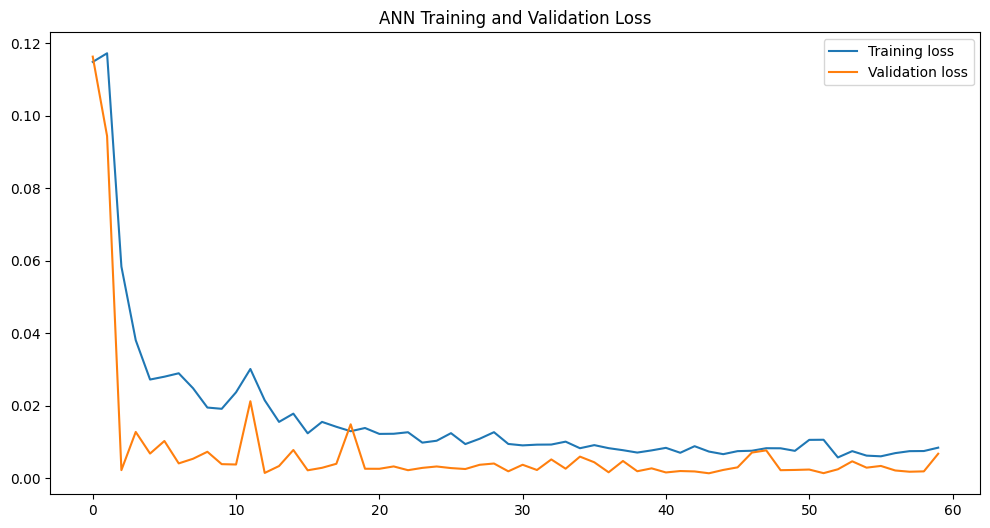

In [357]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [358]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [359]:
len(test_predictions)

59

In [360]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 117.8999
RMSE: 10.8582
MAE: 7.2868
MAPE: 82.33%
R²: 0.7427


In [361]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 117.8999
RMSE: 10.8582
MAE: 7.2868
MAPE: 82.33%
R²: 0.7427


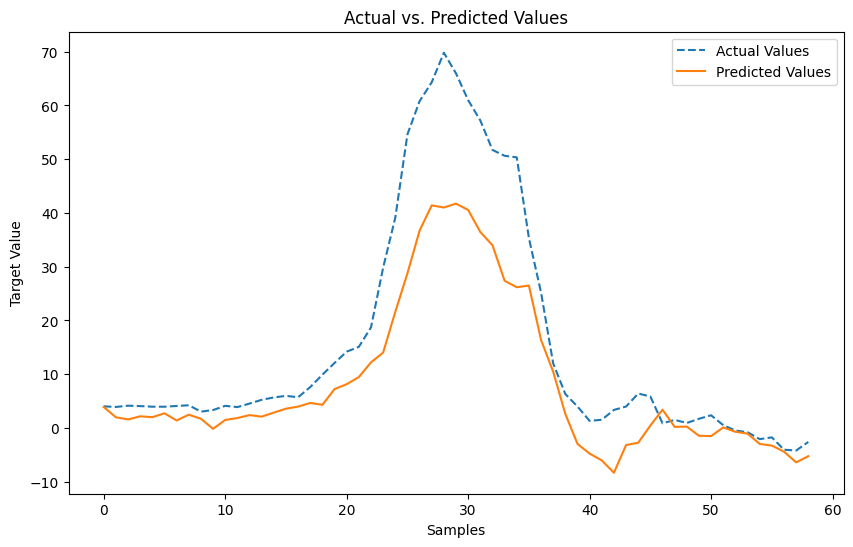

In [362]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 11

In [363]:

df=data.copy()
df = df.astype(float)


In [364]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [365]:
# Number of lags to create
lags = 11
lagged_features = create_lagged_features(df, lags)


In [366]:
print("Original DataFrame:")
print(df)



Original DataFrame:
       Year  Month   Day  Inflation
0    2000.0    1.0  31.0   0.329139
1    2000.0    2.0  28.0   1.940367
2    2000.0    3.0  31.0   4.469678
3    2000.0    4.0  30.0   3.672022
4    2000.0    5.0  31.0   2.382412
..      ...    ...   ...        ...
298  2024.0   11.0  30.0  -2.068252
299  2024.0   12.0  31.0  -1.742696
300  2025.0    1.0  31.0  -4.035874
301  2025.0    2.0  28.0  -4.187438
302  2025.0    3.0  31.0  -2.592781

[303 rows x 4 columns]


In [367]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
0    2000.0    1.0  31.0   0.329139         NaN         NaN         NaN   
1    2000.0    2.0  28.0   1.940367      2000.0         NaN         NaN   
2    2000.0    3.0  31.0   4.469678      2000.0      2000.0         NaN   
3    2000.0    4.0  30.0   3.672022      2000.0      2000.0      2000.0   
4    2000.0    5.0  31.0   2.382412      2000.0      2000.0      2000.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_2  \
0

In [368]:
print(lagged_features.columns)

Index(['Year', 'Month', 'Day', 'Inflation', 'Year_lag_1', 'Year_lag_2',
       'Year_lag_3', 'Year_lag_4', 'Year_lag_5', 'Year_lag_6', 'Year_lag_7',
       'Year_lag_8', 'Year_lag_9', 'Year_lag_10', 'Year_lag_11', 'Month_lag_1',
       'Month_lag_2', 'Month_lag_3', 'Month_lag_4', 'Month_lag_5',
       'Month_lag_6', 'Month_lag_7', 'Month_lag_8', 'Month_lag_9',
       'Month_lag_10', 'Month_lag_11', 'Day_lag_1', 'Day_lag_2', 'Day_lag_3',
       'Day_lag_4', 'Day_lag_5', 'Day_lag_6', 'Day_lag_7', 'Day_lag_8',
       'Day_lag_9', 'Day_lag_10', 'Day_lag_11', 'Inflation_lag_1',
       'Inflation_lag_2', 'Inflation_lag_3', 'Inflation_lag_4',
       'Inflation_lag_5', 'Inflation_lag_6', 'Inflation_lag_7',
       'Inflation_lag_8', 'Inflation_lag_9', 'Inflation_lag_10',
       'Inflation_lag_11'],
      dtype='object')


In [369]:
df2=lagged_features.dropna()

In [370]:
print(df2)
len(df2)

       Year  Month   Day  Inflation  Year_lag_1  Year_lag_2  Year_lag_3  \
11   2000.0   12.0  31.0  10.836729      2000.0      2000.0      2000.0   
12   2001.0    1.0  31.0  16.170425      2000.0      2000.0      2000.0   
13   2001.0    2.0  28.0  16.618124      2001.0      2000.0      2000.0   
14   2001.0    3.0  31.0  13.213922      2001.0      2001.0      2000.0   
15   2001.0    4.0  30.0  13.874019      2001.0      2001.0      2001.0   
..      ...    ...   ...        ...         ...         ...         ...   
298  2024.0   11.0  30.0  -2.068252      2024.0      2024.0      2024.0   
299  2024.0   12.0  31.0  -1.742696      2024.0      2024.0      2024.0   
300  2025.0    1.0  31.0  -4.035874      2024.0      2024.0      2024.0   
301  2025.0    2.0  28.0  -4.187438      2025.0      2024.0      2024.0   
302  2025.0    3.0  31.0  -2.592781      2025.0      2025.0      2024.0   

     Year_lag_4  Year_lag_5  Year_lag_6  ...  Inflation_lag_2  \
11       2000.0      2000.0      2

292

In [371]:
df2.isnull().sum()

Year                0
Month               0
Day                 0
Inflation           0
Year_lag_1          0
Year_lag_2          0
Year_lag_3          0
Year_lag_4          0
Year_lag_5          0
Year_lag_6          0
Year_lag_7          0
Year_lag_8          0
Year_lag_9          0
Year_lag_10         0
Year_lag_11         0
Month_lag_1         0
Month_lag_2         0
Month_lag_3         0
Month_lag_4         0
Month_lag_5         0
Month_lag_6         0
Month_lag_7         0
Month_lag_8         0
Month_lag_9         0
Month_lag_10        0
Month_lag_11        0
Day_lag_1           0
Day_lag_2           0
Day_lag_3           0
Day_lag_4           0
Day_lag_5           0
Day_lag_6           0
Day_lag_7           0
Day_lag_8           0
Day_lag_9           0
Day_lag_10          0
Day_lag_11          0
Inflation_lag_1     0
Inflation_lag_2     0
Inflation_lag_3     0
Inflation_lag_4     0
Inflation_lag_5     0
Inflation_lag_6     0
Inflation_lag_7     0
Inflation_lag_8     0
Inflation_lag_9     0
Inflation_lag_10    0
Inflation_lag_11    0
dtype: int64

In [372]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         9.876072        10.139831         6.799835   
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
...                     ...              ...              ...   
2024-11-30         2.365931         1.716069         0.936037   
2024-12-31         0.526039         2.365931         1.716069   
2025-01-31        -0.469239         0.526039         2.365931   
2025-02-28        -0.783699        -0.469239         0.526039   
2025-03-31        -2.068252        -0.783699        -0.469239   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         2.382412         3.672022         4.469678   
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
...                     ...              ...              ...   
2024-11-30         1.508060         0.871795         5.857520   
2024-12-31         0.936037         1.508060         0.871795   
2025-01-31         1.716069         0.936037         1.508060   
2025-02-28         2.365931         1.716069         0.936037   
2025-03-31         0.526039         2.365931         1.716069   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          1.940367          0.329139  
2001-01-31          4.469678          1.940367  
2001-02-28          3.672022          4.469678  
2001-03-31          2.382412          3.672022  
2001-04-30          6.799835          2.382412  
...                      ...               ...  
2024-11-30          6.415695          3.997868  
2024-12-31          5.857520          6.415695  
2025-01-31          0.871795          5.857520  
2025-02-28          1.508060          0.871795  
2025-03-31          0.936037          1.508060  

[292 rows x 12 columns]

In [ ]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
...               ...              ...              ...              ...   
2019-12-31   4.829770         4.358162         5.377207         4.963971   
2020-01-31   5.651491         4.829770         4.358162         5.377207   
2020-02-28   6.151420         5.651491         4.829770         4.358162   
2020-03-31   5.371248         6.151420         5.651491         4.829770   
2020-04-30   5.196850         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         9.876072        10.139831         6.799835   
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         2.382412         3.672022         4.469678   
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          1.940367          0.329139  
2001-01-31          4.469678          1.940367  
2001-02-28          3.672022          4.469678  
2001-03-31          2.382412          3.672022  
2001-04-30          6.799835          2.382412  
...                      ...               ...  
2019-12-31          4.019688          3.745928  
2020-01-31          4.283361          4.019688  
2020-02-28          4.526749          4.283361  
2020-03-31          4.963385          4.526749  
2020-04-30          3.827751          4.963385  

[233 rows x 12 columns]

In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
...               ...              ...              ...              ...   
2019-12-31   4.829770         4.358162         5.377207         4.963971   
2020-01-31   5.651491         4.829770         4.358162         5.377207   
2020-02-28   6.151420         5.651491         4.829770         4.358162   
2020-03-31   5.371248         6.151420         5.651491         4.829770   
2020-04-30   5.196850         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         9.876072        10.139831         6.799835   
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         2.382412         3.672022         4.469678   
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          1.940367          0.329139  
2001-01-31          4.469678          1.940367  
2001-02-28          3.672022          4.469678  
2001-03-31          2.382412          3.672022  
2001-04-30          6.799835          2.382412  
...                      ...               ...  
2019-12-31          4.019688          3.745928  
2020-01-31          4.283361          4.019688  
2020-02-28          4.526749          4.283361  
2020-03-31          4.963385          4.526749  
2020-04-30          3.827751          4.963385  

[233 rows x 12 columns]

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

Date
2020-05-31     4.031008
2020-06-30     3.917051
2020-07-31     4.153846
2020-08-31     4.073789
2020-09-30     3.966438
2020-10-31     3.960396
2020-11-30     4.100228
2020-12-31     4.229607
2021-01-31     3.046062
2021-02-28     3.343239
2021-03-31     4.122939
2021-04-30     3.892216
2021-05-31     4.545455
2021-06-30     5.247598
2021-07-31     5.686854
2021-08-31     5.982275
2021-09-30     5.722671
2021-10-31     7.619048
2021-11-30     9.919767
2021-12-31    12.101449
2022-01-31    14.203317
2022-02-28    15.097052
2022-03-31    18.718503
2022-04-30    29.827089
2022-05-31    39.130435
2022-06-30    54.634831
2022-07-31    60.796646
2022-08-31    64.320557
2022-09-30    69.812630
2022-10-31    65.963240
2022-11-30    60.982084
2022-12-31    57.207498
2023-01-31    51.729686
2023-02-28    50.635930
2023-03-31    50.346955
2023-04-30    35.327234
2023-05-31    25.195313
2023-06-30    11.997670
2023-07-31     6.316378
2023-08-31     3.993435
2023-09-30     1.320655
2023-10-31     1.538462
2023-11-30     3.367183
2023-12-31     3.997868
2024-01-31     6.415695
2024-02-28     5.857520
2024-03-31     0.871795
2024-04-30     1.508060
2024-05-31     0.936037
2024-06-30     1.716069
2024-07-31     2.365931
2024-08-31     0.526039
2024-09-30    -0.469239
2024-10-31    -0.783699
2024-11-30    -2.068252
2024-12-31    -1.742696
2025-01-31    -4.035874
2025-02-28    -4.187438
2025-03-31    -2.592781
Name: Inflation, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11'],
      dtype='object')

In [ ]:
ytrain

Date
2000-12-31    10.836729
2001-01-31    16.170425
2001-02-28    16.618124
2001-03-31    13.213922
2001-04-30    13.874019
                ...    
2019-12-31     4.829770
2020-01-31     5.651491
2020-02-28     6.151420
2020-03-31     5.371248
2020-04-30     5.196850
Name: Inflation, Length: 233, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2000-12-31         7.559566         7.794494         8.455851   
2001-01-31        10.836729         7.559566         7.794494   
2001-02-28        16.170425        10.836729         7.559566   
2001-03-31        16.618124        16.170425        10.836729   
2001-04-30        13.213922        16.618124        16.170425   
...                     ...              ...              ...   
2019-12-31         4.358162         5.377207         4.963971   
2020-01-31         4.829770         4.358162         5.377207   
2020-02-28         5.651491         4.829770         4.358162   
2020-03-31         6.151420         5.651491         4.829770   
2020-04-30         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         9.876072        10.139831         6.799835   
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         2.382412         3.672022         4.469678   
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          1.940367          0.329139  
2001-01-31          4.469678          1.940367  
2001-02-28          3.672022          4.469678  
2001-03-31          2.382412          3.672022  
2001-04-30          6.799835          2.382412  
...                      ...               ...  
2019-12-31          4.019688          3.745928  
2020-01-31          4.283361          4.019688  
2020-02-28          4.526749          4.283361  
2020-03-31          4.963385          4.526749  
2020-04-30          3.827751          4.963385  

[233 rows x 11 columns]

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.24800572, 0.25656207, 0.2806495 , ..., 0.13546829, 0.04334777,
        0.        ],
       [0.36736392, 0.24800572, 0.25656207, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.56162353, 0.36736392, 0.24800572, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.17851136, 0.1485833 , 0.13140674, ..., 0.1534497 , 0.13754689,
        0.14184233],
       [0.19671934, 0.17851136, 0.1485833 , ..., 0.11208856, 0.1534497 ,
        0.15057293],
       [0.16830456, 0.19671934, 0.17851136, ..., 0.09427428, 0.11208856,
        0.16623555]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2000-12-31         0.248006         0.256562         0.280650   
2001-01-31         0.367364         0.248006         0.256562   
2001-02-28         0.561624         0.367364         0.248006   
2001-03-31         0.577929         0.561624         0.367364   
2001-04-30         0.453944         0.577929         0.561624   
...                     ...              ...              ...   
2019-12-31         0.131407         0.168522         0.153471   
2020-01-31         0.148583         0.131407         0.168522   
2020-02-28         0.178511         0.148583         0.131407   
2020-03-31         0.196719         0.178511         0.148583   
2020-04-30         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         0.332376         0.341982         0.220335   
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         0.059448         0.106417         0.135468   
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          0.043348          0.000000  
2001-01-31          0.135468          0.057797  
2001-02-28          0.106417          0.148526  
2001-03-31          0.059448          0.119913  
2001-04-30          0.220335          0.073653  
...                      ...               ...  
2019-12-31          0.119079          0.122564  
2020-01-31          0.128682          0.132384  
2020-02-28          0.137547          0.141842  
2020-03-31          0.153450          0.150573  
2020-04-30          0.112089          0.166236  

[233 rows x 11 columns]

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-12-31  10.836729         0.248006         0.256562         0.280650   
2001-01-31  16.170425         0.367364         0.248006         0.256562   
2001-02-28  16.618124         0.561624         0.367364         0.248006   
2001-03-31  13.213922         0.577929         0.561624         0.367364   
2001-04-30  13.874019         0.453944         0.577929         0.561624   
...               ...              ...              ...              ...   
2019-12-31   4.829770         0.131407         0.168522         0.153471   
2020-01-31   5.651491         0.148583         0.131407         0.168522   
2020-02-28   6.151420         0.178511         0.148583         0.131407   
2020-03-31   5.371248         0.196719         0.178511         0.148583   
2020-04-30   5.196850         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         0.332376         0.341982         0.220335   
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         0.059448         0.106417         0.135468   
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          0.043348          0.000000  
2001-01-31          0.135468          0.057797  
2001-02-28          0.106417          0.148526  
2001-03-31          0.059448          0.119913  
2001-04-30          0.220335          0.073653  
...                      ...               ...  
2019-12-31          0.119079          0.122564  
2020-01-31          0.128682          0.132384  
2020-02-28          0.137547          0.141842  
2020-03-31          0.153450          0.150573  
2020-04-30          0.112089          0.166236  

[233 rows x 12 columns]

In [ ]:
X_train_scaled_df

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2000-12-31         0.248006         0.256562         0.280650   
2001-01-31         0.367364         0.248006         0.256562   
2001-02-28         0.561624         0.367364         0.248006   
2001-03-31         0.577929         0.561624         0.367364   
2001-04-30         0.453944         0.577929         0.561624   
...                     ...              ...              ...   
2019-12-31         0.131407         0.168522         0.153471   
2020-01-31         0.148583         0.131407         0.168522   
2020-02-28         0.178511         0.148583         0.131407   
2020-03-31         0.196719         0.178511         0.148583   
2020-04-30         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2000-12-31         0.332376         0.341982         0.220335   
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2000-12-31         0.059448         0.106417         0.135468   
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  
Date                                            
2000-12-31          0.043348          0.000000  
2001-01-31          0.135468          0.057797  
2001-02-28          0.106417          0.148526  
2001-03-31          0.059448          0.119913  
2001-04-30          0.220335          0.073653  
...                      ...               ...  
2019-12-31          0.119079          0.122564  
2020-01-31          0.128682          0.132384  
2020-02-28          0.137547          0.141842  
2020-03-31          0.153450          0.150573  
2020-04-30          0.112089          0.166236  

[233 rows x 11 columns]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-28 06:41:18,629] A new study created in memory with name: no-name-af7191c4-8fc6-4321-9752-6f03a907de54
[I 2025-05-28 06:41:34,996] Trial 0 finished with value: 0.023719593277201058 and parameters: {'input_units': 96, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.2661048567324733, 'n_units_1': 32, 'dropout_rate_1': 0.01133029110695466, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 50}. Best is trial 0 with value: 0.023719593277201058.
[I 2025-05-28 06:41:53,316] Trial 1 finished with value: 0.0033198646269738674 and parameters: {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.06062520570116553, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 60}. Best is trial 1 with value: 0.0033198646269738674.
[I 2025-05-28 06:42:00,963] Trial 2 finished with value: 0.048025415185838936 and parameters: {'input_units': 128, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.08181

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.019281114859567433, 'n_units_1': 80, 'dropout_rate_1': 0.2658629923365772, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.019281114859567433, 'n_units_1': 80, 'dropout_rate_1': 0.2658629923365772, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 70}
Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0420 - mae: 0.1645 - val_loss: 0.0043 - val_mae: 0.0571
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - mae: 0.1087 - val_loss: 0.0011 - val_mae: 0.0300
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - mae: 0.0874 - val_loss: 0.0019 - val_mae: 0.0328
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0091 - mae: 0.0717 - val_loss: 0.0015 - val_mae: 0.0341
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - mae: 0.0666 - val_loss: 0.0012 - val_mae: 0.0305
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - mae: 0.0570 - val_loss: 0.0015 - val_mae: 0.0329
Epoch 7/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.00

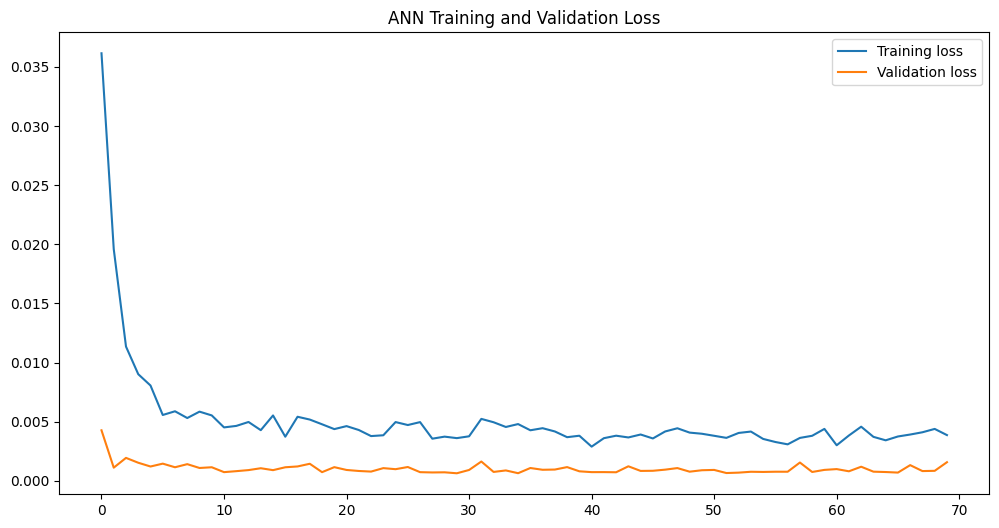

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 42.3617
RMSE: 6.5086
MAE: 4.0581
MAPE: 65.42%
R²: 0.9075


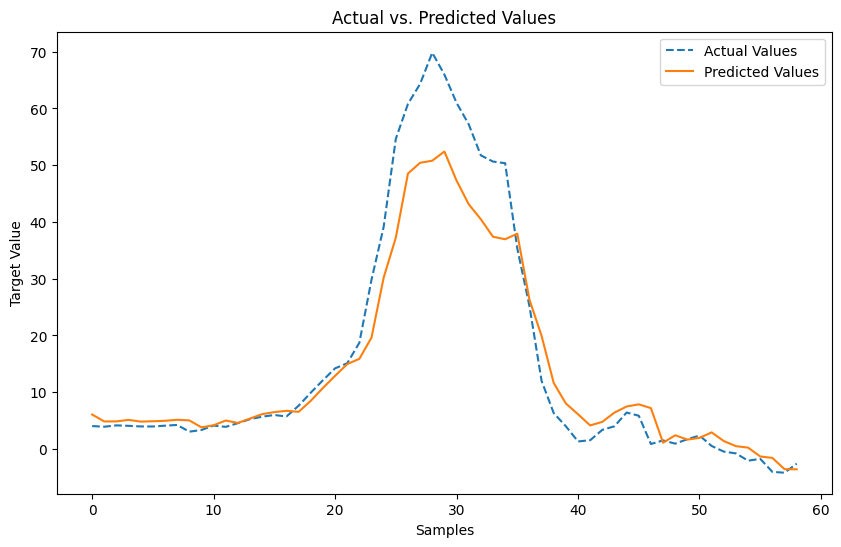

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 12

In [ ]:
data

Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 12
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11', 'Inflation_lag_12'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
2001-05-31  16.256885        13.874019        13.213922        16.618124   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

291

In [ ]:
df2.isnull().sum()

Inflation           0
Inflation_lag_1     0
Inflation_lag_2     0
Inflation_lag_3     0
Inflation_lag_4     0
Inflation_lag_5     0
Inflation_lag_6     0
Inflation_lag_7     0
Inflation_lag_8     0
Inflation_lag_9     0
Inflation_lag_10    0
Inflation_lag_11    0
Inflation_lag_12    0
dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
2001-05-31  16.256885        13.874019        13.213922        16.618124   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
2001-05-31        16.170425        10.836729         7.559566   
...                     ...              ...              ...   
2024-11-30         2.365931         1.716069         0.936037   
2024-12-31         0.526039         2.365931         1.716069   
2025-01-31        -0.469239         0.526039         2.365931   
2025-02-28        -0.783699        -0.469239         0.526039   
2025-03-31        -2.068252        -0.783699        -0.469239   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
2001-05-31         7.794494         8.455851         9.876072   
...                     ...              ...              ...   
2024-11-30         1.508060         0.871795         5.857520   
2024-12-31         0.936037         1.508060         0.871795   
2025-01-31         1.716069         0.936037         1.508060   
2025-02-28         2.365931         1.716069         0.936037   
2025-03-31         0.526039         2.365931         1.716069   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          4.469678          1.940367          0.329139  
2001-02-28          3.672022          4.469678          1.940367  
2001-03-31          2.382412          3.672022          4.469678  
2001-04-30          6.799835          2.382412          3.672022  
2001-05-31         10.139831          6.799835          2.382412  
...                      ...               ...               ...  
2024-11-30          6.415695          3.997868          3.367183  
2024-12-31          5.857520          6.415695          3.997868  
2025-01-31          0.871795          5.857520          6.415695  
2025-02-28          1.508060          0.871795          5.857520  
2025-03-31          0.936037          1.508060          0.871795  

[291 rows x 13 columns]

In [ ]:
train_size = int(len(df2) * 0.8)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
2001-05-31  16.256885        13.874019        13.213922        16.618124   
...               ...              ...              ...              ...   
2019-12-31   4.829770         4.358162         5.377207         4.963971   
2020-01-31   5.651491         4.829770         4.358162         5.377207   
2020-02-28   6.151420         5.651491         4.829770         4.358162   
2020-03-31   5.371248         6.151420         5.651491         4.829770   
2020-04-30   5.196850         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
2001-05-31        16.170425        10.836729         7.559566   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
2001-05-31         7.794494         8.455851         9.876072   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          4.469678          1.940367          0.329139  
2001-02-28          3.672022          4.469678          1.940367  
2001-03-31          2.382412          3.672022          4.469678  
2001-04-30          6.799835          2.382412          3.672022  
2001-05-31         10.139831          6.799835          2.382412  
...                      ...               ...               ...  
2019-12-31          4.019688          3.745928          2.766477  
2020-01-31          4.283361          4.019688          3.745928  
2020-02-28          4.526749          4.283361          4.019688  
2020-03-31          4.963385          4.526749          4.283361  
2020-04-30          3.827751          4.963385          4.526749  

[232 rows x 13 columns]

In [ ]:
xtrain=train_data.drop(columns=['Inflation'])
xtest=test_data.drop(columns=['Inflation'])

In [ ]:
train_data

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
2001-05-31  16.256885        13.874019        13.213922        16.618124   
...               ...              ...              ...              ...   
2019-12-31   4.829770         4.358162         5.377207         4.963971   
2020-01-31   5.651491         4.829770         4.358162         5.377207   
2020-02-28   6.151420         5.651491         4.829770         4.358162   
2020-03-31   5.371248         6.151420         5.651491         4.829770   
2020-04-30   5.196850         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
2001-05-31        16.170425        10.836729         7.559566   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
2001-05-31         7.794494         8.455851         9.876072   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          4.469678          1.940367          0.329139  
2001-02-28          3.672022          4.469678          1.940367  
2001-03-31          2.382412          3.672022          4.469678  
2001-04-30          6.799835          2.382412          3.672022  
2001-05-31         10.139831          6.799835          2.382412  
...                      ...               ...               ...  
2019-12-31          4.019688          3.745928          2.766477  
2020-01-31          4.283361          4.019688          3.745928  
2020-02-28          4.526749          4.283361          4.019688  
2020-03-31          4.963385          4.526749          4.283361  
2020-04-30          3.827751          4.963385          4.526749  

[232 rows x 13 columns]

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Inflation"]
ytest=test_data["Inflation"]
ytest

Date
2020-05-31     4.031008
2020-06-30     3.917051
2020-07-31     4.153846
2020-08-31     4.073789
2020-09-30     3.966438
2020-10-31     3.960396
2020-11-30     4.100228
2020-12-31     4.229607
2021-01-31     3.046062
2021-02-28     3.343239
2021-03-31     4.122939
2021-04-30     3.892216
2021-05-31     4.545455
2021-06-30     5.247598
2021-07-31     5.686854
2021-08-31     5.982275
2021-09-30     5.722671
2021-10-31     7.619048
2021-11-30     9.919767
2021-12-31    12.101449
2022-01-31    14.203317
2022-02-28    15.097052
2022-03-31    18.718503
2022-04-30    29.827089
2022-05-31    39.130435
2022-06-30    54.634831
2022-07-31    60.796646
2022-08-31    64.320557
2022-09-30    69.812630
2022-10-31    65.963240
2022-11-30    60.982084
2022-12-31    57.207498
2023-01-31    51.729686
2023-02-28    50.635930
2023-03-31    50.346955
2023-04-30    35.327234
2023-05-31    25.195313
2023-06-30    11.997670
2023-07-31     6.316378
2023-08-31     3.993435
2023-09-30     1.320655
2023-10-31     1.538462
2023-11-30     3.367183
2023-12-31     3.997868
2024-01-31     6.415695
2024-02-28     5.857520
2024-03-31     0.871795
2024-04-30     1.508060
2024-05-31     0.936037
2024-06-30     1.716069
2024-07-31     2.365931
2024-08-31     0.526039
2024-09-30    -0.469239
2024-10-31    -0.783699
2024-11-30    -2.068252
2024-12-31    -1.742696
2025-01-31    -4.035874
2025-02-28    -4.187438
2025-03-31    -2.592781
Name: Inflation, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11', 'Inflation_lag_12'],
      dtype='object')

In [ ]:
ytrain

Date
2001-01-31    16.170425
2001-02-28    16.618124
2001-03-31    13.213922
2001-04-30    13.874019
2001-05-31    16.256885
                ...    
2019-12-31     4.829770
2020-01-31     5.651491
2020-02-28     6.151420
2020-03-31     5.371248
2020-04-30     5.196850
Name: Inflation, Length: 232, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2001-01-31        10.836729         7.559566         7.794494   
2001-02-28        16.170425        10.836729         7.559566   
2001-03-31        16.618124        16.170425        10.836729   
2001-04-30        13.213922        16.618124        16.170425   
2001-05-31        13.874019        13.213922        16.618124   
...                     ...              ...              ...   
2019-12-31         4.358162         5.377207         4.963971   
2020-01-31         4.829770         4.358162         5.377207   
2020-02-28         5.651491         4.829770         4.358162   
2020-03-31         6.151420         5.651491         4.829770   
2020-04-30         5.371248         6.151420         5.651491   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         8.455851         9.876072        10.139831   
2001-02-28         7.794494         8.455851         9.876072   
2001-03-31         7.559566         7.794494         8.455851   
2001-04-30        10.836729         7.559566         7.794494   
2001-05-31        16.170425        10.836729         7.559566   
...                     ...              ...              ...   
2019-12-31         3.418124         3.338633         3.827751   
2020-01-31         4.963971         3.418124         3.338633   
2020-02-28         5.377207         4.963971         3.418124   
2020-03-31         4.358162         5.377207         4.963971   
2020-04-30         4.829770         4.358162         5.377207   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         6.799835         2.382412         3.672022   
2001-02-28        10.139831         6.799835         2.382412   
2001-03-31         9.876072        10.139831         6.799835   
2001-04-30         8.455851         9.876072        10.139831   
2001-05-31         7.794494         8.455851         9.876072   
...                     ...              ...              ...   
2019-12-31         4.963385         4.526749         4.283361   
2020-01-31         3.827751         4.963385         4.526749   
2020-02-28         3.338633         3.827751         4.963385   
2020-03-31         3.418124         3.338633         3.827751   
2020-04-30         4.963971         3.418124         3.338633   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          4.469678          1.940367          0.329139  
2001-02-28          3.672022          4.469678          1.940367  
2001-03-31          2.382412          3.672022          4.469678  
2001-04-30          6.799835          2.382412          3.672022  
2001-05-31         10.139831          6.799835          2.382412  
...                      ...               ...               ...  
2019-12-31          4.019688          3.745928          2.766477  
2020-01-31          4.283361          4.019688          3.745928  
2020-02-28          4.526749          4.283361          4.019688  
2020-03-31          4.963385          4.526749          4.283361  
2020-04-30          3.827751          4.963385          4.526749  

[232 rows x 12 columns]

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.36736392, 0.24800572, 0.25656207, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.56162353, 0.36736392, 0.24800572, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.57792925, 0.56162353, 0.36736392, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.17851136, 0.1485833 , 0.13140674, ..., 0.13754689, 0.1286824 ,
        0.1323841 ],
       [0.19671934, 0.17851136, 0.1485833 , ..., 0.1534497 , 0.13754689,
        0.14184233],
       [0.16830456, 0.19671934, 0.17851136, ..., 0.11208856, 0.1534497 ,
        0.15057293]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2001-01-31         0.367364         0.248006         0.256562   
2001-02-28         0.561624         0.367364         0.248006   
2001-03-31         0.577929         0.561624         0.367364   
2001-04-30         0.453944         0.577929         0.561624   
2001-05-31         0.477986         0.453944         0.577929   
...                     ...              ...              ...   
2019-12-31         0.131407         0.168522         0.153471   
2020-01-31         0.148583         0.131407         0.168522   
2020-02-28         0.178511         0.148583         0.131407   
2020-03-31         0.196719         0.178511         0.148583   
2020-04-30         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
2001-05-31         0.561624         0.367364         0.248006   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
2001-05-31         0.256562         0.280650         0.332376   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          0.135468          0.043348          0.000000  
2001-02-28          0.106417          0.135468          0.057797  
2001-03-31          0.059448          0.106417          0.148526  
2001-04-30          0.220335          0.059448          0.119913  
2001-05-31          0.341982          0.220335          0.073653  
...                      ...               ...               ...  
2019-12-31          0.119079          0.109108          0.087430  
2020-01-31          0.128682          0.119079          0.122564  
2020-02-28          0.137547          0.128682          0.132384  
2020-03-31          0.153450          0.137547          0.141842  
2020-04-30          0.112089          0.153450          0.150573  

[232 rows x 12 columns]

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425         0.367364         0.248006         0.256562   
2001-02-28  16.618124         0.561624         0.367364         0.248006   
2001-03-31  13.213922         0.577929         0.561624         0.367364   
2001-04-30  13.874019         0.453944         0.577929         0.561624   
2001-05-31  16.256885         0.477986         0.453944         0.577929   
...               ...              ...              ...              ...   
2019-12-31   4.829770         0.131407         0.168522         0.153471   
2020-01-31   5.651491         0.148583         0.131407         0.168522   
2020-02-28   6.151420         0.178511         0.148583         0.131407   
2020-03-31   5.371248         0.196719         0.178511         0.148583   
2020-04-30   5.196850         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
2001-05-31         0.561624         0.367364         0.248006   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
2001-05-31         0.256562         0.280650         0.332376   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          0.135468          0.043348          0.000000  
2001-02-28          0.106417          0.135468          0.057797  
2001-03-31          0.059448          0.106417          0.148526  
2001-04-30          0.220335          0.059448          0.119913  
2001-05-31          0.341982          0.220335          0.073653  
...                      ...               ...               ...  
2019-12-31          0.119079          0.109108          0.087430  
2020-01-31          0.128682          0.119079          0.122564  
2020-02-28          0.137547          0.128682          0.132384  
2020-03-31          0.153450          0.137547          0.141842  
2020-04-30          0.112089          0.153450          0.150573  

[232 rows x 13 columns]

In [ ]:
X_train_scaled_df

Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                            
2001-01-31         0.367364         0.248006         0.256562   
2001-02-28         0.561624         0.367364         0.248006   
2001-03-31         0.577929         0.561624         0.367364   
2001-04-30         0.453944         0.577929         0.561624   
2001-05-31         0.477986         0.453944         0.577929   
...                     ...              ...              ...   
2019-12-31         0.131407         0.168522         0.153471   
2020-01-31         0.148583         0.131407         0.168522   
2020-02-28         0.178511         0.148583         0.131407   
2020-03-31         0.196719         0.178511         0.148583   
2020-04-30         0.168305         0.196719         0.178511   

            Inflation_lag_4  Inflation_lag_5  Inflation_lag_6  \
Date                                                            
2001-01-31         0.280650         0.332376         0.341982   
2001-02-28         0.256562         0.280650         0.332376   
2001-03-31         0.248006         0.256562         0.280650   
2001-04-30         0.367364         0.248006         0.256562   
2001-05-31         0.561624         0.367364         0.248006   
...                     ...              ...              ...   
2019-12-31         0.097169         0.094274         0.112089   
2020-01-31         0.153471         0.097169         0.094274   
2020-02-28         0.168522         0.153471         0.097169   
2020-03-31         0.131407         0.168522         0.153471   
2020-04-30         0.148583         0.131407         0.168522   

            Inflation_lag_7  Inflation_lag_8  Inflation_lag_9  \
Date                                                            
2001-01-31         0.220335         0.059448         0.106417   
2001-02-28         0.341982         0.220335         0.059448   
2001-03-31         0.332376         0.341982         0.220335   
2001-04-30         0.280650         0.332376         0.341982   
2001-05-31         0.256562         0.280650         0.332376   
...                     ...              ...              ...   
2019-12-31         0.153450         0.137547         0.128682   
2020-01-31         0.112089         0.153450         0.137547   
2020-02-28         0.094274         0.112089         0.153450   
2020-03-31         0.097169         0.094274         0.112089   
2020-04-30         0.153471         0.097169         0.094274   

            Inflation_lag_10  Inflation_lag_11  Inflation_lag_12  
Date                                                              
2001-01-31          0.135468          0.043348          0.000000  
2001-02-28          0.106417          0.135468          0.057797  
2001-03-31          0.059448          0.106417          0.148526  
2001-04-30          0.220335          0.059448          0.119913  
2001-05-31          0.341982          0.220335          0.073653  
...                      ...               ...               ...  
2019-12-31          0.119079          0.109108          0.087430  
2020-01-31          0.128682          0.119079          0.122564  
2020-02-28          0.137547          0.128682          0.132384  
2020-03-31          0.153450          0.137547          0.141842  
2020-04-30          0.112089          0.153450          0.150573  

[232 rows x 12 columns]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-05-28 06:57:58,418] A new study created in memory with name: no-name-4fe4aa82-0a62-4289-bcf7-059ee042c8f5
[I 2025-05-28 06:58:22,523] Trial 0 finished with value: 0.02327694990672171 and parameters: {'input_units': 128, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.09485040575273346, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 100}. Best is trial 0 with value: 0.02327694990672171.
[I 2025-05-28 06:58:46,084] Trial 1 finished with value: 0.006535705039277672 and parameters: {'input_units': 96, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.34334467584844847, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 80}. Best is trial 1 with value: 0.006535705039277672.
[I 2025-05-28 06:58:50,629] Trial 2 finished with value: 0.008759858878329396 and parameters: {'input_units': 16, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.23260835450228012, 'n_units_1': 48, 'dropout_rate_1': 0.00085

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.34035221280482864, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.13441907234091177, 'n_units_1': 128, 'dropout_rate_1': 0.4830564719642031, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 60}
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1192 - mae: 0.2559 - val_loss: 0.0023 - val_mae: 0.0421
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0401 - mae: 0.1429 - val_loss: 0.0035 - val_mae: 0.0515
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0219 - mae: 0.1139 - val_loss: 0.0033 - val_mae: 0.0502
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - mae: 0.0980 - val_loss: 0.0022 - val_mae: 0.0419
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - mae: 0.0911 - val_loss: 0.0018 - val_mae: 0.0368
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0772 - val_loss: 0.0022 - val_mae: 0.0378
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - 

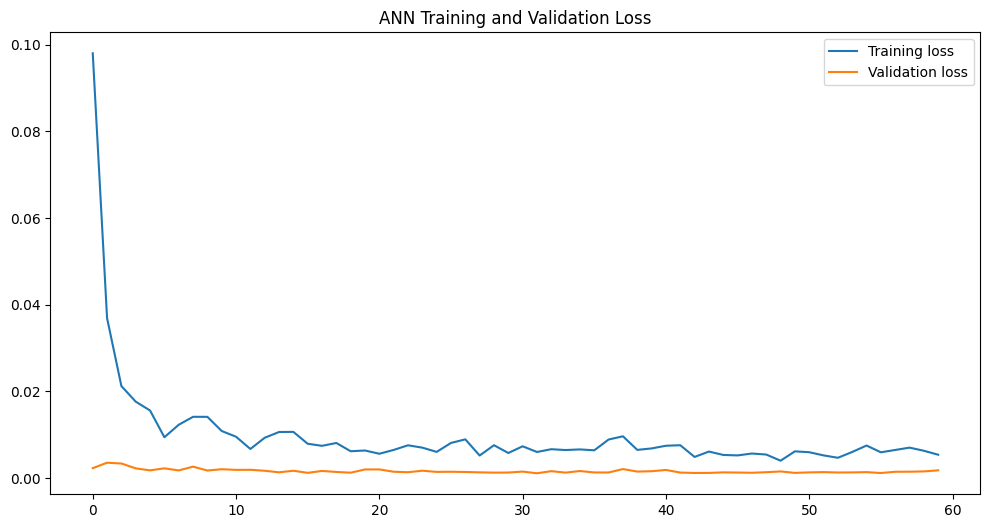

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
len(test_predictions)

88

In [ ]:
# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

MSE: 29.5737
RMSE: 5.4382
MAE: 3.2120
MAPE: 49.20%


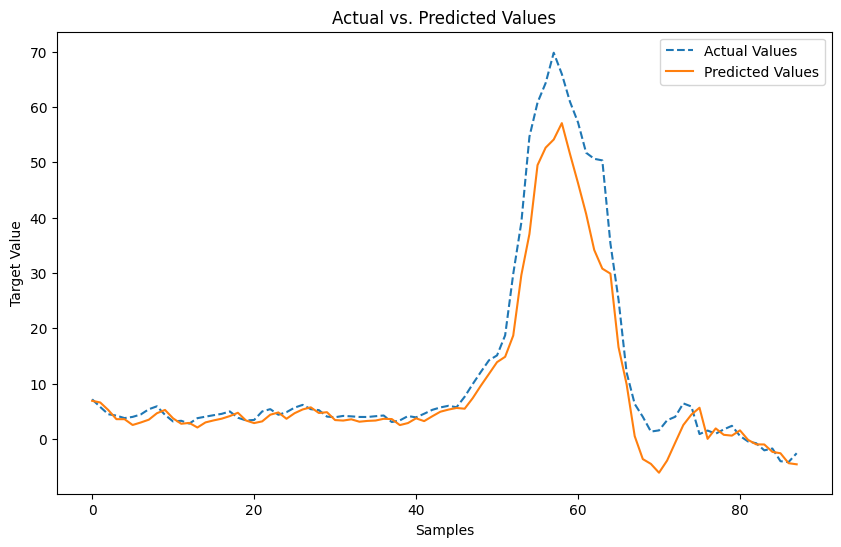

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## K